# Machine Learning

Anggota Kelompok :

1. Haidar Dimas Heryanto - 2022210370311088
2. Alfi Aulia Azzahra - 202210370311095

# PART 1: KLASIK ML

## INSTALL & IMPORT LIBRARIES

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -q roboflow albumentations opencv-python scikit-learn scikit-image matplotlib seaborn imbalanced-learn

import os
import shutil
import cv2
import yaml
import numpy as np
import pandas as pd
import random
import albumentations as A
from roboflow import Roboflow
from skimage.feature import hog, local_binary_pattern, graycomatrix, graycoprops
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import time
from collections import Counter

print("✅ Libraries imported successfully!")

def set_all_seeds(seed=42):
    """Set all random seeds for reproducibility"""
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    print(f"\n🎲 All random seeds set to: {seed}")


set_all_seeds(42)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 45.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 59.5 MB/s eta 0:00:00
✅ Libraries imported successfully!

🎲 All random seeds set to: 42


## LOAD DATASET DARI ROBOFLOW

In [ ]:
rf = Roboflow(api_key="9J11qljgG9odzZnvoVbg")
project = rf.workspace("aa-cqfub").project("h3lm-40l0-oid-xd-3dofr")
version = project.version(5)
dataset = version.download("yolov11")

# Target classes (pakai 2 label saja)
TARGET_CLASSES = {1: 0, 5: 1}  # 1=no_helmet→0, 5=with_helmet→1
CLASS_NAMES = ['no_helmet', 'with_helmet']

print(f"\n✅ Dataset downloaded!")
print(f"📁 Location: {dataset.location}")
print(f"🎯 Target Classes: {CLASS_NAMES}")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to h3Lm-40L0-Oid-XD-5 in yolov11:: 100%|██████████| 2732/2732 [00:03<00:00, 906.73it/s]



✅ Dataset downloaded!
📁 Location: /content/h3Lm-40L0-Oid-XD-5
🎯 Target Classes: ['no_helmet', 'with_helmet']


## PREPROCESSING & AUGMENTASI

In [ ]:
transform_crop = A.Compose([
    A.Resize(128, 128),
    A.GaussianBlur(blur_limit=(3, 5), p=0.3),
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=15, p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
    A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=20, val_shift_limit=20, p=0.5),
])

print("\n✅ Augmentation pipeline configured:")
print("   • Resize: 128x128")
print("   • Gaussian Blur")
print("   • Horizontal Flip")
print("   • Rotation ±15°")
print("   • Brightness/Contrast adjustment")
print("   • HSV color shift")


✅ Augmentation pipeline configured:
   • Resize: 128x128
   • Gaussian Blur
   • Horizontal Flip
   • Rotation ±15°
   • Brightness/Contrast adjustment
   • HSV color shift


### HELPER FUNCTIONS

In [ ]:
# @title
def yolo_to_bbox(x_center, y_center, width, height, img_width, img_height):
    """Convert YOLO format to pixel coordinates"""
    x_center *= img_width
    y_center *= img_height
    width *= img_width
    height *= img_height

    x1 = int(max(0, x_center - width / 2))
    y1 = int(max(0, y_center - height / 2))
    x2 = int(min(img_width, x_center + width / 2))
    y2 = int(min(img_height, y_center + height / 2))

    return x1, y1, x2, y2


def load_cropped_data(dataset_path):
    """
    Load and crop bboxes WITHOUT augmentation
    Augmentation will be applied later ONLY to training set
    """
    print("\n📦 Loading and cropping bboxes...")

    all_images = []
    all_labels = []
    total_bboxes = 0

    for split in ['train', 'valid', 'test']:
        img_folder = os.path.join(dataset_path, split, "images")
        label_folder = os.path.join(dataset_path, split, "labels")

        if not os.path.exists(img_folder):
            continue

        image_files = sorted([f for f in os.listdir(img_folder)
                             if f.endswith(('.jpg', '.png'))])

        for img_file in image_files:
            img_path = os.path.join(img_folder, img_file)
            label_path = os.path.join(label_folder,
                                     img_file.replace('.jpg', '.txt').replace('.png', '.txt'))

            image = cv2.imread(img_path)
            if image is None:
                continue

            img_height, img_width = image.shape[:2]
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            if not os.path.exists(label_path):
                continue

            with open(label_path, 'r') as f:
                lines = f.readlines()
                lines = sorted(lines)

                for line in lines:
                    parts = line.strip().split()
                    if len(parts) == 5:
                        cls = int(parts[0])

                        if cls not in TARGET_CLASSES:
                            continue

                        x_c, y_c, w, h = map(float, parts[1:])
                        x1, y1, x2, y2 = yolo_to_bbox(x_c, y_c, w, h, img_width, img_height)

                        if (x2 - x1) < 10 or (y2 - y1) < 10:
                            continue

                        cropped = image_rgb[y1:y2, x1:x2]
                        if cropped.size == 0:
                            continue

                        try:
                            # Only resize - NO augmentation yet
                            resized = cv2.resize(cropped, (128, 128))
                            resized_bgr = cv2.cvtColor(resized, cv2.COLOR_RGB2BGR)

                            all_images.append(resized_bgr)
                            all_labels.append(TARGET_CLASSES[cls])
                            total_bboxes += 1
                        except:
                            continue

    print(f"✅ Processed: {total_bboxes} bboxes")
    print(f"   Distribution: {np.bincount(all_labels).tolist()} (0=no_helmet, 1=with_helmet)")

    return all_images, np.array(all_labels)


def augment_training_data(X_train, y_train, augmentation_seed=42, target_balance_ratio=1.0):
    """
    Apply CLASS-SPECIFIC augmentation to balance dataset

    Parameters:
    -----------
    X_train : array
        Training images
    y_train : array
        Training labels
    augmentation_seed : int
        Random seed for reproducibility
    target_balance_ratio : float
        Target ratio between classes (1.0 = perfect balance)

    Returns:
    --------
    X_aug, y_aug : Augmented and balanced dataset
    """

    print(f"\n🔄 Applying class-specific augmentation...")
    print(f"   Original training size: {len(X_train)}")
    print(f"   Original distribution: {np.bincount(y_train).tolist()}")

    # Set seed ONCE at the beginning
    random.seed(augmentation_seed)
    np.random.seed(augmentation_seed)

    # Separate by class
    class_counts = np.bincount(y_train)
    majority_count = max(class_counts)

    X_augmented = []
    y_augmented = []

    for cls in range(len(class_counts)):
        cls_indices = np.where(y_train == cls)[0]
        cls_images = X_train[cls_indices]

        # Calculate target count
        current_count = len(cls_images)
        target_count = int(majority_count * target_balance_ratio)

        # Add original images
        X_augmented.extend(cls_images)
        y_augmented.extend([cls] * len(cls_images))

        # Calculate how many augmentations needed
        n_augmentations_needed = max(0, target_count - current_count)

        if n_augmentations_needed > 0:
            print(f"   Class {cls} ({CLASS_NAMES[cls]}): {current_count} → {target_count} samples")
            print(f"      Generating {n_augmentations_needed} augmented samples...")

            # Generate augmentations
            for _ in range(n_augmentations_needed):
                # Randomly select image from this class
                idx = np.random.randint(0, len(cls_images))
                img = cls_images[idx]

                try:
                    # Convert BGR to RGB
                    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

                    # Apply augmentation
                    aug = transform_crop(image=img_rgb)
                    aug_img = np.clip(aug['image'], 0, 255).astype(np.uint8)
                    aug_img_bgr = cv2.cvtColor(aug_img, cv2.COLOR_RGB2BGR)

                    X_augmented.append(aug_img_bgr)
                    y_augmented.append(cls)

                except Exception as e:
                    print(f"⚠️ Augmentation failed: {e}")
                    continue

    X_train_aug = np.array(X_augmented)
    y_train_aug = np.array(y_augmented)

    # Shuffle with seed
    shuffle_idx = np.arange(len(X_train_aug))
    np.random.shuffle(shuffle_idx)
    X_train_aug = X_train_aug[shuffle_idx]
    y_train_aug = y_train_aug[shuffle_idx]

    print(f"\n   ✅ After augmentation: {len(X_train_aug)} samples")
    print(f"   Final distribution: {np.bincount(y_train_aug).tolist()}")

    return X_train_aug, y_train_aug


def run_experiment(X, y, feature_name, algorithms_dict,
                   feature_extractor=None,
                   apply_augmentation=False,
                   augmentation_seed=42,
                   show_plots=True):
    """
    Universal experiment runner (WITHOUT CROSS-VALIDATION)

    Parameters:
    -----------
    X : array-like
        Raw images or pre-extracted features
    y : array-like
        Labels
    feature_name : str
        Name of feature set
    algorithms_dict : dict
        Dictionary of algorithms to test
    feature_extractor : function, optional
        Feature extraction function (None if X is already features)
    apply_augmentation : bool
        If True, augment training images
    augmentation_seed : int
        Seed for augmentation
    show_plots : bool
        Whether to show plots

    Returns:
    --------
    results : list
        List of result dictionaries
    best : dict
        Best model result
    """

    print(f"🧪 RUNNING EXPERIMENTS: {feature_name}")


    results = []
    is_image_mode = feature_extractor is not None

    if is_image_mode:
        print(f"📸 Mode: RAW IMAGES → will extract features per-split")
    else:
        print(f"📊 Mode: PRE-EXTRACTED FEATURES")

    # Convert to numpy
    X = np.array(X)
    y = np.array(y)

    # Split data: 80% train, 10% val, 10% test
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
    )

    print(f"\n📊 Data Split:")
    print(f"   Train: {len(y_train)} samples - {np.bincount(y_train).tolist()}")
    print(f"   Val:   {len(y_val)} samples - {np.bincount(y_val).tolist()}")
    print(f"   Test:  {len(y_test)} samples - {np.bincount(y_test).tolist()}")

    # Augmentation + Feature extraction (if image mode)
    if is_image_mode:
        if apply_augmentation:
            print(f"\n🔄 Augmenting training images...")
            try:
                X_train, y_train = augment_training_data(
                    X_train, y_train,
                    augmentation_seed,
                    target_balance_ratio=1.0
                )
            except Exception as e:
                print(f"⚠️ Augmentation failed: {e}")
                print(f"   Continuing with original training data...")

        # Extract features
        print(f"\n📊 Extracting features...")
        print(f"   Train: {len(X_train)} images")
        X_train = np.array([feature_extractor(img) for img in X_train])

        print(f"   Val: {len(X_val)} images")
        X_val = np.array([feature_extractor(img) for img in X_val])

        print(f"   Test: {len(X_test)} images")
        X_test = np.array([feature_extractor(img) for img in X_test])

        print(f"✅ Features extracted: Train={X_train.shape}, Val={X_val.shape}, Test={X_test.shape}")

    # SMOTE for class imbalance
    class_counts = np.bincount(y_train)
    min_class_count = min(class_counts)
    imbalance_ratio = max(class_counts) / min_class_count

    print(f"\n⚖️ Class balance check:")
    print(f"   Distribution: {class_counts.tolist()}")
    print(f"   Imbalance ratio: {imbalance_ratio:.2f}:1")

    if imbalance_ratio > 1.5 and min_class_count >= 6:
        k_neighbors = min(5, min_class_count - 1)

        try:
            smote = SMOTE(
                random_state=42,
                k_neighbors=k_neighbors,
                sampling_strategy='auto'
            )
            X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)
            print(f"   ✅ SMOTE applied: {class_counts.tolist()} → {np.bincount(y_train_bal).tolist()}")

        except Exception as e:
            print(f"   ⚠️ SMOTE failed: {e}, using original data")
            X_train_bal, y_train_bal = X_train, y_train

    elif min_class_count < 6:
        print(f"   ⚠️ SMOTE skipped: minority class too small ({min_class_count} < 6)")
        X_train_bal, y_train_bal = X_train, y_train
    else:
        print(f"   ℹ️ Classes relatively balanced, SMOTE not needed")
        X_train_bal, y_train_bal = X_train, y_train

    # Normalize
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_bal)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)

    # PCA
    print(f"\n📉 PCA dimensionality reduction:")
    print(f"   Original features: {X_train_scaled.shape[1]}")

    pca = PCA(n_components=0.95, random_state=42)
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_val_pca = pca.transform(X_val_scaled)
    X_test_pca = pca.transform(X_test_scaled)

    actual_variance = np.sum(pca.explained_variance_ratio_)
    print(f"   Components: {X_train_pca.shape[1]}")
    print(f"   Variance retained: {actual_variance:.4f}")
    print(f"   Compression: {X_train_scaled.shape[1] / X_train_pca.shape[1]:.2f}x")

    # Train & evaluate algorithms
    for algo_name, algorithm in algorithms_dict.items():
        print(f"\n  🔹 Training {algo_name}...")

        start = time.time()
        algorithm.fit(X_train_pca, y_train_bal)
        train_time = time.time() - start

        train_acc = accuracy_score(y_train_bal, algorithm.predict(X_train_pca))
        val_acc = accuracy_score(y_val, algorithm.predict(X_val_pca))
        test_acc = accuracy_score(y_test, algorithm.predict(X_test_pca))

        print(f"     Train: {train_acc:.4f} | Val: {val_acc:.4f} | Test: {test_acc:.4f} | Time: {train_time:.2f}s")

        # Predictions
        y_pred = algorithm.predict(X_test_pca)

        # Calculate metrics
        precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
        recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
        f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

        results.append({
            'algorithm': algo_name,
            'train_acc': train_acc,
            'val_acc': val_acc,
            'test_acc': test_acc,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'overfitting': train_acc - test_acc,
            'train_time': train_time,
            'model': algorithm,
            'scaler': scaler,
            'pca': pca,
            'y_test': y_test,
            'y_pred': y_pred
        })

    # Find best model
    best = max(results, key=lambda x: x['test_acc'])

    # Visualizations
    if show_plots:
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))

        # Confusion matrix
        cm = confusion_matrix(best['y_test'], best['y_pred'])
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES, ax=axes[0])
        axes[0].set_title(f"{feature_name}\nBest: {best['algorithm']} - Acc: {best['test_acc']:.2%}",
                         fontweight='bold')
        axes[0].set_ylabel('True Label')
        axes[0].set_xlabel('Predicted Label')

        # Bar comparison
        test_accs = [r['test_acc'] for r in results]
        algo_names = [r['algorithm'] for r in results]
        colors = ['#6bcf7f' if acc == max(test_accs) else '#ffd93d' if acc > 0.75 else '#ff6b6b'
                 for acc in test_accs]

        axes[1].barh(algo_names, test_accs, color=colors, edgecolor='black')
        axes[1].set_xlabel('Test Accuracy')
        axes[1].set_title(f'{feature_name} - Algorithms Comparison', fontweight='bold')
        axes[1].axvline(x=0.75, color='red', linestyle='--', alpha=0.5, label='75%')
        axes[1].legend()
        axes[1].grid(axis='x', alpha=0.3)

        for i, v in enumerate(test_accs):
            axes[1].text(v + 0.01, i, f'{v:.1%}', va='center', fontweight='bold')

        plt.tight_layout()
        plt.savefig(f"{feature_name.lower().replace(' ', '_').replace(':', '')}_results.png",
                   dpi=300, bbox_inches='tight')
        print(f"\n✅ Plot saved")
        plt.show()

        # Classification report
        print(f"\n📋 Classification Report - Best Model ({best['algorithm']}):")
        print(classification_report(best['y_test'], best['y_pred'],
                                   target_names=CLASS_NAMES, zero_division=0))

    return results, best


def save_best_model(best_result, set_name, feature_extractor_func, save_path):
    """Save best model for each feature set"""
    filename = f"best_model_{set_name.lower().replace(' ', '_').replace(':', '')}.pkl"
    filepath = os.path.join(save_path, filename)

    with open(filepath, 'wb') as f:
        pickle.dump({
            'model': best_result['model'],
            'scaler': best_result['scaler'],
            'pca': best_result['pca'],
            'feature_set': set_name,
            'algorithm': best_result['algorithm'],
            'feature_extractor': feature_extractor_func,
            'class_names': CLASS_NAMES,
            'test_acc': best_result['test_acc'],
            'val_acc': best_result['val_acc'],
            'train_acc': best_result['train_acc'],
            'precision': best_result['precision'],
            'recall': best_result['recall'],
            'f1_score': best_result['f1_score'],
            'overfitting': best_result['overfitting']
        }, f)

    print(f"✅ Model saved: {filename}")
    return filepath

def extract_set1_features(image):
    """Feature Set 1: Histogram + HOG + LBP"""
    # Histogram (Color Distribution)
    hist_features = []
    for i in range(3):
        hist = cv2.calcHist([image], [i], None, [32], [0, 256])
        hist = hist.flatten() / (hist.sum() + 1e-7)
        hist_features.extend(hist)

    # HOG (Shape/Edge)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    hog_feat = hog(gray, orientations=9, pixels_per_cell=(8, 8),
                   cells_per_block=(2, 2), block_norm='L2-Hys',
                   visualize=False, feature_vector=True)

    # LBP (Texture)
    lbp = local_binary_pattern(gray, 24, 3, method='uniform')
    n_bins = int(lbp.max() + 1)
    lbp_hist, _ = np.histogram(lbp, bins=n_bins, range=(0, n_bins), density=True)

    return np.concatenate([hist_features, hog_feat, lbp_hist])


def extract_set2_features(image):
    """Feature Set 2: Color Moments + HOG + GLCM"""
    features = []

    # Color Moments (Mean, Std, Skewness)
    for i in range(3):
        channel = image[:,:,i].astype(np.float64)
        mean_val = np.mean(channel)
        std_val = np.std(channel)
        centered = channel - mean_val
        skew_val = np.mean(centered**3) / (std_val**3 + 1e-7)
        features.extend([mean_val, std_val, skew_val])

    # HOG (optimized)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    hog_feat = hog(gray, orientations=9, pixels_per_cell=(16, 16),
                   cells_per_block=(2, 2), block_norm='L2-Hys',
                   visualize=False, feature_vector=True)

    # GLCM (Texture)
    gray_norm = (gray / 16).astype(np.uint8)
    glcm = graycomatrix(gray_norm, distances=[1], angles=[0, np.pi/4, np.pi/2, 3*np.pi/4],
                        levels=16, symmetric=True, normed=True)

    glcm_features = []
    for prop in ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation']:
        glcm_features.extend(graycoprops(glcm, prop).flatten())

    return np.concatenate([features, hog_feat, glcm_features])


def extract_set3_features(image):
    """Feature Set 3: Edge + HOG + Color Histogram"""
    features = []
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Edge Features (Canny + Sobel)
    edges_canny = cv2.Canny(gray, 50, 150)
    features.extend([
        np.sum(edges_canny > 0) / edges_canny.size,
        np.mean(edges_canny),
        np.std(edges_canny)
    ])

    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
    features.extend([np.mean(np.abs(sobelx)), np.mean(np.abs(sobely))])

    # HOG (compact)
    hog_feat = hog(gray, orientations=8, pixels_per_cell=(16, 16),
                   cells_per_block=(2, 2), block_norm='L2-Hys',
                   visualize=False, feature_vector=True)

    # Color Histogram (reduced)
    hist_features = []
    for i in range(3):
        hist = cv2.calcHist([image], [i], None, [16], [0, 256])
        hist = hist.flatten() / (hist.sum() + 1e-7)
        hist_features.extend(hist)

    return np.concatenate([features, hog_feat, hist_features])


algorithms = {
    'SVM-RBF': SVC(kernel='rbf', C=1.0, gamma='scale', class_weight='balanced', random_state=42),
    'SVM-Linear': SVC(kernel='linear', C=0.5, class_weight='balanced', random_state=42),
    'RandomForest': RandomForestClassifier(n_estimators=100, max_depth=20, random_state=42, n_jobs=-1),
    'GradientBoosting': GradientBoostingClassifier(n_estimators=100, max_depth=5, random_state=42)
}


drive_save_path = "/content/drive/MyDrive/jurnal YOLO/Machine Learning/hasil colab"
os.makedirs(drive_save_path, exist_ok=True)

print(f"\n✅ Save path: {drive_save_path}")


✅ Save path: /content/drive/MyDrive/jurnal YOLO/Machine Learning/hasil colab


### CROP BBOXES (MULTIPLE LABELS)

> pada sebuah citra jika terdapat 2 label, perlabel akan di crop dan dijadikan citra baru. agar menyesuaikan jumlah label yg ada di roboflow (kuliat sama sih jumlahe). dan semua label terbaca walaupun dalam satu citra terdapat multilabel

In [ ]:
cropped_images, labels = load_cropped_data(dataset.location)

print(f"\n✅ Total cropped bboxes: {len(cropped_images)}")
assert len(cropped_images) == len(labels), f"Mismatch! Images: {len(cropped_images)}, Labels: {len(labels)}"



📦 Loading and cropping bboxes...
✅ Processed: 1334 bboxes
   Distribution: [832, 502] (0=no_helmet, 1=with_helmet)

✅ Total cropped bboxes: 1334


> no_helmet	= 837 || with_helmet	= 502

ini dari jumlah label yg ada di roboflow (beda dikit ternyata, kayanya bisa jadi gara-gara label e terlalu kecil)

#### Contoh hasil crop



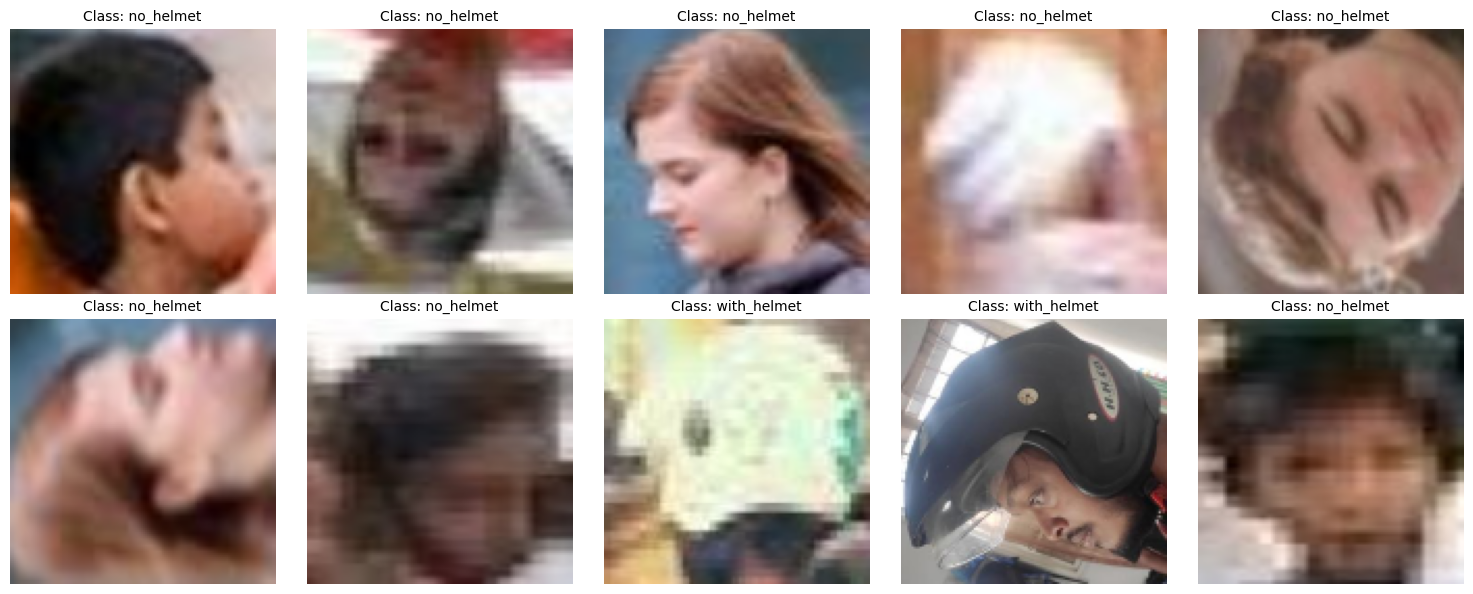

In [ ]:
# @title
num_examples = 10
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()

# Get class names from the loaded dataset config or define them
# Assuming CLASS_NAMES is already defined as ['no_helmet', 'with_helmet']
# If not, uncomment the following lines to load from data.yaml
# original_yaml = os.path.join(dataset.location, "data.yaml")
# with open(original_yaml, 'r') as f:
#     data_config = yaml.safe_load(f)
# CLASS_NAMES = data_config['names'] # Make sure this matches your TARGET_CLASSES mapping


# Select random indices
random_indices = np.random.choice(len(cropped_images), num_examples, replace=False)

for i, idx in enumerate(random_indices):
    img = cropped_images[idx]
    label = labels[idx]
    class_name = CLASS_NAMES[label]

    axes[i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axes[i].set_title(f"Class: {class_name}", fontsize=10)
    axes[i].axis('off')

plt.tight_layout()
plt.show()

## Future Extraction

Terdapat 3 set eksperimen. per set masing-masing menerapkan 3 filter klasik dan 4 algoritma




###  SET 1: HISTOGRAM + HOG + LBP

EXPERIMENT SET 1: HISTOGRAM + HOG + LBP
🧪 RUNNING EXPERIMENTS: SET 1: Histogram+HOG+LBP
📸 Mode: RAW IMAGES → will extract features per-split

📊 Data Split:
   Train: 1067 samples - [665, 402]
   Val:   133 samples - [83, 50]
   Test:  134 samples - [84, 50]

🔄 Augmenting training images...

🔄 Applying class-specific augmentation...
   Original training size: 1067
   Original distribution: [665, 402]
   Class 1 (with_helmet): 402 → 665 samples
      Generating 263 augmented samples...

   ✅ After augmentation: 1330 samples
   Final distribution: [665, 665]

📊 Extracting features...
   Train: 1330 images
   Val: 133 images
   Test: 134 images
✅ Features extracted: Train=(1330, 8222), Val=(133, 8222), Test=(134, 8222)

⚖️ Class balance check:
   Distribution: [665, 665]
   Imbalance ratio: 1.00:1
   ℹ️ Classes relatively balanced, SMOTE not needed

📉 PCA dimensionality reduction:
   Original features: 8222
   Components: 841
   Variance retained: 0.9500
   Compression: 9.78x

  🔹 Training

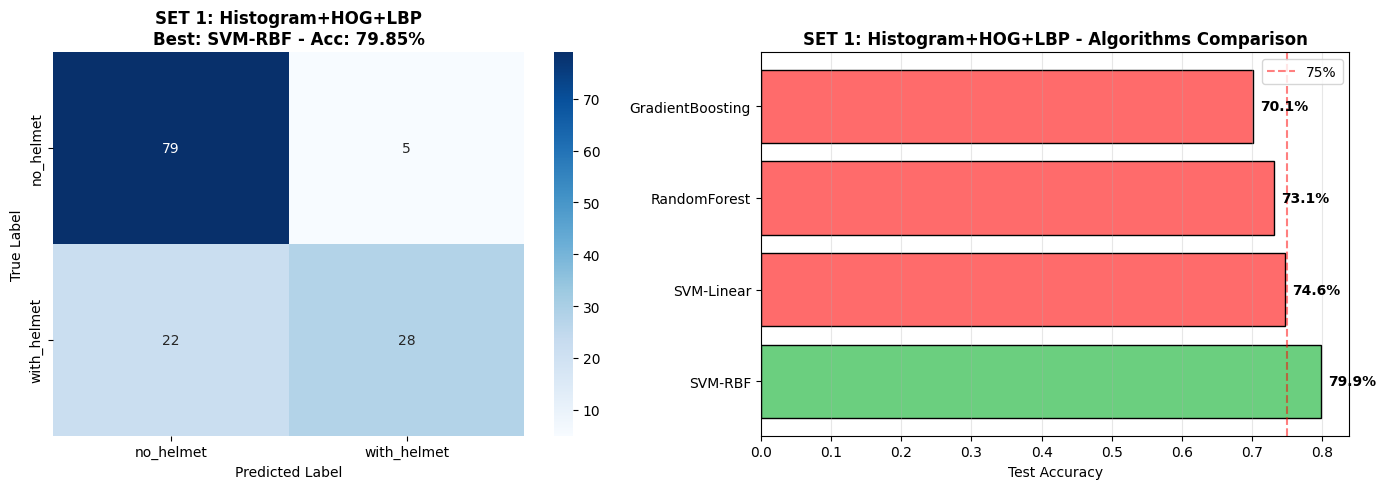


📋 Classification Report - Best Model (SVM-RBF):
              precision    recall  f1-score   support

   no_helmet       0.78      0.94      0.85        84
 with_helmet       0.85      0.56      0.67        50

    accuracy                           0.80       134
   macro avg       0.82      0.75      0.76       134
weighted avg       0.81      0.80      0.79       134

✅ Model saved: best_model_set_1.pkl


In [ ]:
print("EXPERIMENT SET 1: HISTOGRAM + HOG + LBP")

results_set1, best_set1 = run_experiment(
    cropped_images,
    labels,
    "SET 1: Histogram+HOG+LBP",
    algorithms,
    feature_extractor=extract_set1_features,
    apply_augmentation=True
)

saved_file_set1 = save_best_model(best_set1, "SET 1", extract_set1_features, drive_save_path)


### SET 2: COLOR MOMENTS + HOG + GLCM

EXPERIMENT SET 2: COLOR MOMENTS + HOG + GLCM
🧪 RUNNING EXPERIMENTS: SET 2: ColorMoments+HOG+GLCM
📸 Mode: RAW IMAGES → will extract features per-split

📊 Data Split:
   Train: 1067 samples - [665, 402]
   Val:   133 samples - [83, 50]
   Test:  134 samples - [84, 50]

🔄 Augmenting training images...

🔄 Applying class-specific augmentation...
   Original training size: 1067
   Original distribution: [665, 402]
   Class 1 (with_helmet): 402 → 665 samples
      Generating 263 augmented samples...

   ✅ After augmentation: 1330 samples
   Final distribution: [665, 665]

📊 Extracting features...
   Train: 1330 images
   Val: 133 images
   Test: 134 images
✅ Features extracted: Train=(1330, 1793), Val=(133, 1793), Test=(134, 1793)

⚖️ Class balance check:
   Distribution: [665, 665]
   Imbalance ratio: 1.00:1
   ℹ️ Classes relatively balanced, SMOTE not needed

📉 PCA dimensionality reduction:
   Original features: 1793
   Components: 376
   Variance retained: 0.9500
   Compression: 4.77x

  🔹

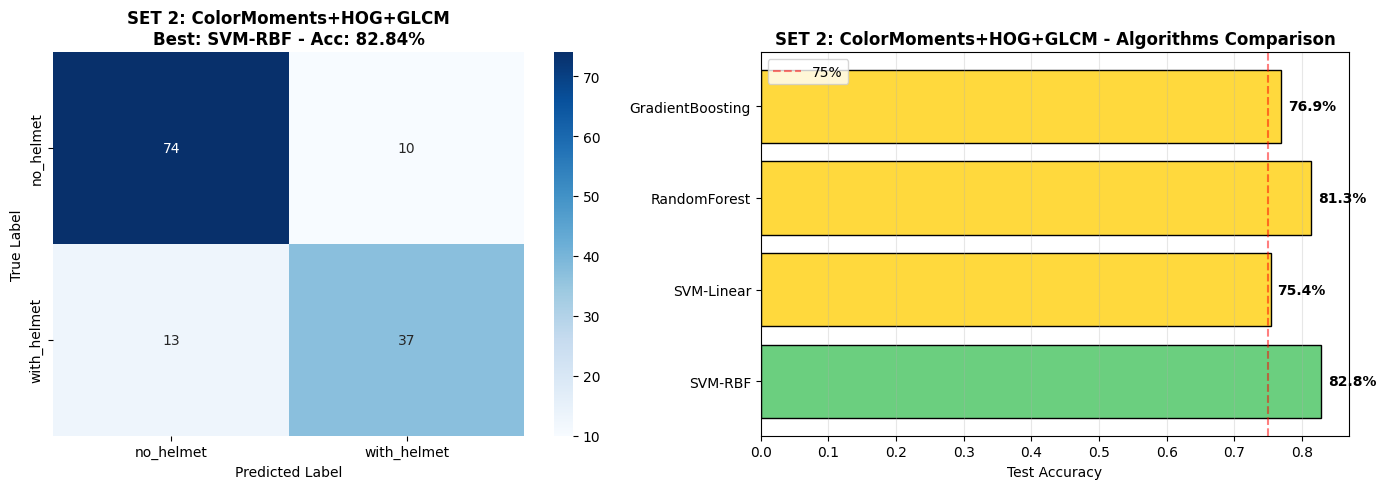


📋 Classification Report - Best Model (SVM-RBF):
              precision    recall  f1-score   support

   no_helmet       0.85      0.88      0.87        84
 with_helmet       0.79      0.74      0.76        50

    accuracy                           0.83       134
   macro avg       0.82      0.81      0.81       134
weighted avg       0.83      0.83      0.83       134

✅ Model saved: best_model_set_2.pkl


In [ ]:
print("EXPERIMENT SET 2: COLOR MOMENTS + HOG + GLCM")

results_set2, best_set2 = run_experiment(
    cropped_images,
    labels,
    "SET 2: ColorMoments+HOG+GLCM",
    algorithms,
    feature_extractor=extract_set2_features,
    apply_augmentation=True
)

saved_file_set2 = save_best_model(best_set2, "SET 2", extract_set2_features, drive_save_path)


### SET 3: EDGE + HOG + COLOR HISTOGRAM

EXPERIMENT SET 3: EDGE + HOG + COLOR HISTOGRAM
🧪 RUNNING EXPERIMENTS: SET 3: Edge+HOG+ColorHist
📸 Mode: RAW IMAGES → will extract features per-split

📊 Data Split:
   Train: 1067 samples - [665, 402]
   Val:   133 samples - [83, 50]
   Test:  134 samples - [84, 50]

🔄 Augmenting training images...

🔄 Applying class-specific augmentation...
   Original training size: 1067
   Original distribution: [665, 402]
   Class 1 (with_helmet): 402 → 665 samples
      Generating 263 augmented samples...

   ✅ After augmentation: 1330 samples
   Final distribution: [665, 665]

📊 Extracting features...
   Train: 1330 images
   Val: 133 images
   Test: 134 images
✅ Features extracted: Train=(1330, 1621), Val=(133, 1621), Test=(134, 1621)

⚖️ Class balance check:
   Distribution: [665, 665]
   Imbalance ratio: 1.00:1
   ℹ️ Classes relatively balanced, SMOTE not needed

📉 PCA dimensionality reduction:
   Original features: 1621
   Components: 362
   Variance retained: 0.9503
   Compression: 4.48x

  🔹 

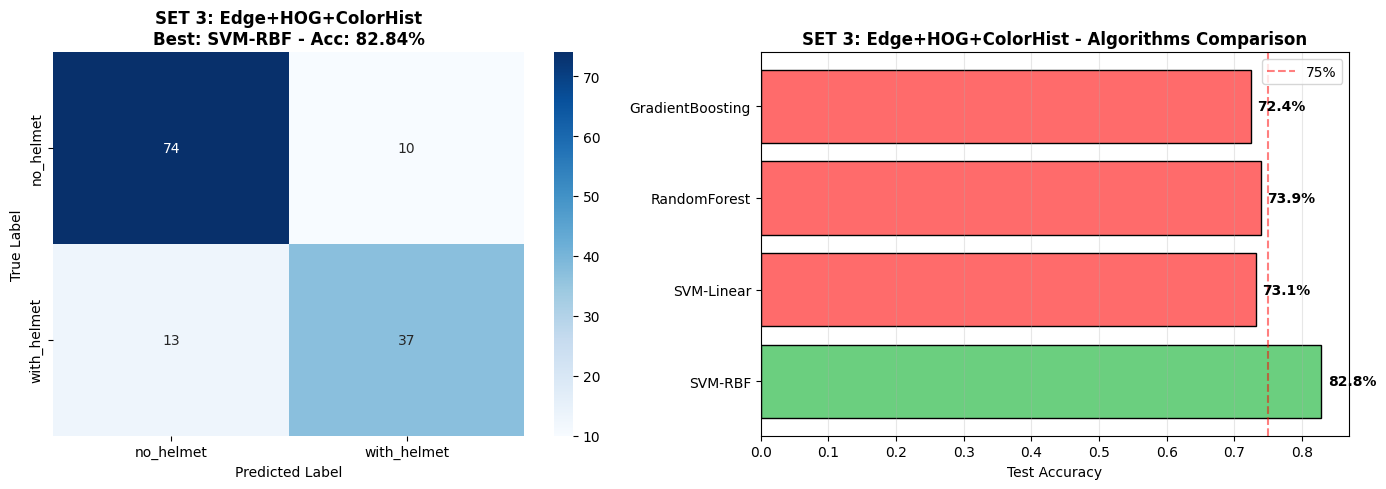


📋 Classification Report - Best Model (SVM-RBF):
              precision    recall  f1-score   support

   no_helmet       0.85      0.88      0.87        84
 with_helmet       0.79      0.74      0.76        50

    accuracy                           0.83       134
   macro avg       0.82      0.81      0.81       134
weighted avg       0.83      0.83      0.83       134

✅ Model saved: best_model_set_3.pkl


In [ ]:

print("EXPERIMENT SET 3: EDGE + HOG + COLOR HISTOGRAM")


results_set3, best_set3 = run_experiment(
    cropped_images,
    labels,
    "SET 3: Edge+HOG+ColorHist",
    algorithms,
    feature_extractor=extract_set3_features,
    apply_augmentation=True
)

saved_file_set3 = save_best_model(best_set3, "SET 3", extract_set3_features, drive_save_path)


## Perbandingan Semua Set

📊 COMPARISON OF ALL FEATURE SETS

📋 RESULTS TABLE:


,Feature Set,Algorithm,Test Acc,Val Acc,Train Acc,Precision,Recall,F1-Score,Overfitting,Time (s)
0,SET 1,SVM-RBF,79.85%,83.46%,99.02%,80.69%,79.85%,78.71%,19.17%,0.86
1,SET 1,SVM-Linear,74.63%,84.21%,100.00%,74.85%,74.63%,74.72%,25.37%,1.09
2,SET 1,RandomForest,73.13%,77.44%,100.00%,72.55%,73.13%,72.20%,26.87%,4.59
3,SET 1,GradientBoosting,70.15%,78.20%,100.00%,70.41%,70.15%,70.26%,29.85%,86.19
4,SET 2,SVM-RBF,82.84%,87.22%,98.65%,82.69%,82.84%,82.72%,15.81%,0.24
5,SET 2,SVM-Linear,75.37%,75.19%,98.42%,75.72%,75.37%,75.51%,23.05%,3.18
6,SET 2,RandomForest,81.34%,78.95%,100.00%,81.26%,81.34%,80.90%,18.66%,1.95
7,SET 2,GradientBoosting,76.87%,75.19%,100.00%,76.64%,76.87%,76.71%,23.13%,38.16
8,SET 3,SVM-RBF,82.84%,85.71%,98.72%,82.69%,82.84%,82.72%,15.89%,0.27
9,SET 3,SVM-Linear,73.13%,75.19%,98.57%,72.94%,73.13%,73.02%,25.44%,3.62



🏆 BEST OVERALL MODEL
   Feature Set: SET 2
   Algorithm: SVM-RBF
   Test Accuracy: 82.84%
   Val Accuracy: 87.22%
   Precision: 82.69%
   Recall: 82.84%
   F1-Score: 82.72%
   Overfitting: 15.81%
   Training Time: 0.24s

✅ Saved: /content/drive/MyDrive/jurnal YOLO/Machine Learning/hasil colab/complete_analysis_all_sets.png


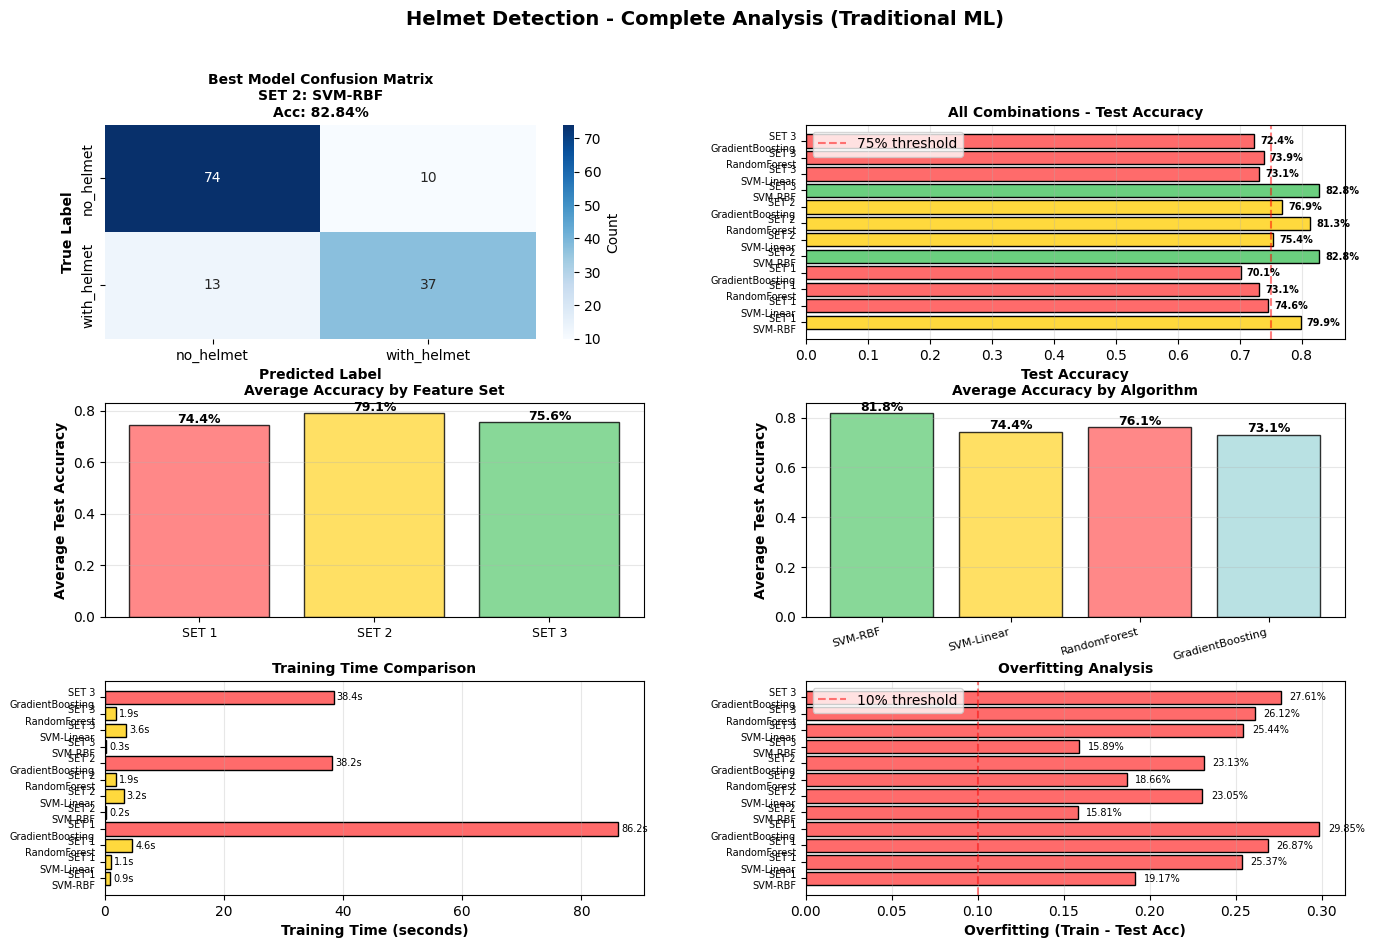

In [ ]:
# @title
print("📊 COMPARISON OF ALL FEATURE SETS")

# Compile all results
all_results = []
for set_name, results in [('SET 1', results_set1), ('SET 2', results_set2), ('SET 3', results_set3)]:
    for r in results:
        all_results.append({
            'Feature Set': set_name,
            'Algorithm': r['algorithm'],
            'Test Acc': f"{r['test_acc']:.2%}",
            'Val Acc': f"{r['val_acc']:.2%}",
            'Train Acc': f"{r['train_acc']:.2%}",
            'Precision': f"{r['precision']:.2%}",
            'Recall': f"{r['recall']:.2%}",
            'F1-Score': f"{r['f1_score']:.2%}",
            'Overfitting': f"{r['overfitting']:.2%}",
            'Time (s)': f"{r['train_time']:.2f}",
            'test_acc_float': r['test_acc']
        })

# Display table
df_comparison = pd.DataFrame(all_results)
print("\n📋 RESULTS TABLE:")
display(df_comparison.drop('test_acc_float', axis=1))

# Find overall best
best_overall = max([best_set1, best_set2, best_set3], key=lambda x: x['test_acc'])
set_names_dict = {id(best_set1): 'SET 1', id(best_set2): 'SET 2', id(best_set3): 'SET 3'}

print(f"\n{'='*60}")
print(f"🏆 BEST OVERALL MODEL")
print(f"{'='*60}")
print(f"   Feature Set: {set_names_dict[id(best_overall)]}")
print(f"   Algorithm: {best_overall['algorithm']}")
print(f"   Test Accuracy: {best_overall['test_acc']:.2%}")
print(f"   Val Accuracy: {best_overall['val_acc']:.2%}")
print(f"   Precision: {best_overall['precision']:.2%}")
print(f"   Recall: {best_overall['recall']:.2%}")
print(f"   F1-Score: {best_overall['f1_score']:.2%}")
print(f"   Overfitting: {best_overall['overfitting']:.2%}")
print(f"   Training Time: {best_overall['train_time']:.2f}s")

# Create comprehensive visualization
fig = plt.figure(figsize=(16, 10))
gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)

# 1. Best Model Confusion Matrix
ax1 = fig.add_subplot(gs[0, 0])
cm = confusion_matrix(best_overall['y_test'], best_overall['y_pred'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES,
            ax=ax1, cbar_kws={'label': 'Count'})
ax1.set_title(f"Best Model Confusion Matrix\n{set_names_dict[id(best_overall)]}: {best_overall['algorithm']}\nAcc: {best_overall['test_acc']:.2%}",
              fontweight='bold', fontsize=10)
ax1.set_ylabel('True Label', fontweight='bold')
ax1.set_xlabel('Predicted Label', fontweight='bold')

# 2. All Models Test Accuracy Comparison
ax2 = fig.add_subplot(gs[0, 1])
test_accs = [r['test_acc_float'] for r in all_results]
labels = [f"{r['Feature Set']}\n{r['Algorithm']}" for r in all_results]
colors = ['#6bcf7f' if acc == max(test_accs) else '#ffd93d' if acc > 0.75 else '#ff6b6b' for acc in test_accs]

bars = ax2.barh(range(len(test_accs)), test_accs, color=colors, edgecolor='black')
ax2.set_yticks(range(len(labels)))
ax2.set_yticklabels(labels, fontsize=7)
ax2.set_xlabel('Test Accuracy', fontweight='bold')
ax2.set_title('All Combinations - Test Accuracy', fontweight='bold', fontsize=10)
ax2.axvline(x=0.75, color='red', linestyle='--', alpha=0.5, label='75% threshold')
ax2.legend()
ax2.grid(axis='x', alpha=0.3)

for i, v in enumerate(test_accs):
    ax2.text(v + 0.01, i, f'{v:.1%}', va='center', fontsize=7, fontweight='bold')

# 3. Accuracy by Feature Set
ax3 = fig.add_subplot(gs[1, 0])
set_names_list = ['SET 1', 'SET 2', 'SET 3']
set_avg_acc = []
for sn in set_names_list:
    accs = [r['test_acc_float'] for r in all_results if r['Feature Set'] == sn]
    set_avg_acc.append(np.mean(accs))

bars = ax3.bar(range(len(set_names_list)), set_avg_acc, color=['#ff6b6b', '#ffd93d', '#6bcf7f'],
               edgecolor='black', alpha=0.8)
ax3.set_xticks(range(len(set_names_list)))
ax3.set_xticklabels(set_names_list, fontsize=9, rotation=0)
ax3.set_ylabel('Average Test Accuracy', fontweight='bold')
ax3.set_title('Average Accuracy by Feature Set', fontweight='bold', fontsize=10)
ax3.grid(axis='y', alpha=0.3)

for i, v in enumerate(set_avg_acc):
    ax3.text(i, v + 0.01, f'{v:.1%}', ha='center', fontweight='bold', fontsize=9)

# 4. Accuracy by Algorithm
ax4 = fig.add_subplot(gs[1, 1])
algo_names = ['SVM-RBF', 'SVM-Linear', 'RandomForest', 'GradientBoosting']
algo_avg_acc = []
for an in algo_names:
    accs = [r['test_acc_float'] for r in all_results if r['Algorithm'] == an]
    algo_avg_acc.append(np.mean(accs))

bars = ax4.bar(range(len(algo_names)), algo_avg_acc, color=['#6bcf7f', '#ffd93d', '#ff6b6b', '#a8dadc'],
               edgecolor='black', alpha=0.8)
ax4.set_xticks(range(len(algo_names)))
ax4.set_xticklabels(algo_names, fontsize=8, rotation=15, ha='right')
ax4.set_ylabel('Average Test Accuracy', fontweight='bold')
ax4.set_title('Average Accuracy by Algorithm', fontweight='bold', fontsize=10)
ax4.grid(axis='y', alpha=0.3)

for i, v in enumerate(algo_avg_acc):
    ax4.text(i, v + 0.01, f'{v:.1%}', ha='center', fontweight='bold', fontsize=9)

# 5. Training Time Comparison
ax5 = fig.add_subplot(gs[2, 0])
train_times = [float(r['Time (s)'].replace('s', '')) for r in all_results]
labels_time = [f"{r['Feature Set']}\n{r['Algorithm']}" for r in all_results]
colors_time = ['#6bcf7f' if t == min(train_times) else '#ffd93d' if t < 10 else '#ff6b6b' for t in train_times]

ax5.barh(range(len(train_times)), train_times, color=colors_time, edgecolor='black')
ax5.set_yticks(range(len(labels_time)))
ax5.set_yticklabels(labels_time, fontsize=7)
ax5.set_xlabel('Training Time (seconds)', fontweight='bold')
ax5.set_title('Training Time Comparison', fontweight='bold', fontsize=10)
ax5.grid(axis='x', alpha=0.3)

for i, v in enumerate(train_times):
    ax5.text(v + 0.5, i, f'{v:.1f}s', va='center', fontsize=7)

# 6. Overfitting Analysis
ax6 = fig.add_subplot(gs[2, 1])
overfits = [float(r['Overfitting'].replace('%', '')) / 100 for r in all_results]
labels_over = [f"{r['Feature Set']}\n{r['Algorithm']}" for r in all_results]
colors_over = ['#6bcf7f' if o < 0.05 else '#ffd93d' if o < 0.10 else '#ff6b6b' for o in overfits]

ax6.barh(range(len(overfits)), overfits, color=colors_over, edgecolor='black')
ax6.set_yticks(range(len(labels_over)))
ax6.set_yticklabels(labels_over, fontsize=7)
ax6.set_xlabel('Overfitting (Train - Test Acc)', fontweight='bold')
ax6.set_title('Overfitting Analysis', fontweight='bold', fontsize=10)
ax6.axvline(x=0.10, color='red', linestyle='--', alpha=0.5, label='10% threshold')
ax6.legend()
ax6.grid(axis='x', alpha=0.3)

for i, v in enumerate(overfits):
    ax6.text(v + 0.005, i, f'{v:.2%}', va='center', fontsize=7)

plt.suptitle('Helmet Detection - Complete Analysis (Traditional ML)',
             fontsize=14, fontweight='bold', y=0.995)

save_path_plot = os.path.join(drive_save_path, 'complete_analysis_all_sets.png')
plt.savefig(save_path_plot, dpi=300, bbox_inches='tight')
print(f"\n✅ Saved: {save_path_plot}")
plt.show()

In [ ]:
# @title
print("📊 MENGHITUNG PRECISION & RECALL")

from sklearn.metrics import precision_score, recall_score

# Hitung untuk best model dari setiap set
for set_name, best_result in [('SET 1', best_set1), ('SET 2', best_set2), ('SET 3', best_set3)]:
    y_true = best_result['y_test']
    y_pred = best_result['y_pred']

    # Calculate metrics
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)

    # Add to best_result dictionary
    best_result['precision'] = precision
    best_result['recall'] = recall

    print(f"\n{set_name}:")
    print(f"   Precision: {precision:.6f}")
    print(f"   Recall: {recall:.6f}")

print("\n✅ Precision & Recall updated for all Traditional ML sets!")

📊 MENGHITUNG PRECISION & RECALL

SET 1:
   Precision: 0.806919
   Recall: 0.798507

SET 2:
   Precision: 0.826940
   Recall: 0.828358

SET 3:
   Precision: 0.826940
   Recall: 0.828358

✅ Precision & Recall updated for all Traditional ML sets!


## Error Analysis

📊 1. BREAKDOWN CONFUSION MATRIX

🎯 Komponen Confusion Matrix:
   True Negatives (TN):   74 - Prediksi benar 'tidak pakai helm'
   False Positives (FP):  10 - Prediksi 'pakai helm' tapi sebenarnya 'tidak pakai helm' ⚠️
   False Negatives (FN):  13 - Prediksi 'tidak pakai helm' tapi sebenarnya 'pakai helm'!
   True Positives (TP):   37 - Prediksi benar 'pakai helm'

📈 Metrik Per-Kelas:

   TIDAK PAKAI HELM (Kelas 0):
      • Total sampel: 84
      • Terklasifikasi benar: 74 (88.1%)
      • Salah klasifikasi: 10 (11.9%)
      • Precision: 85.06%
      • Recall: 88.10%
      • Tingkat Error: 11.9%

   PAKAI HELM (Kelas 1):
      • Total sampel: 50
      • Terklasifikasi benar: 37 (74.0%)
      • Salah klasifikasi: 13 (26.0%)
      • Precision: 78.72%
      • Recall: 74.00%
      • Tingkat Error: 26.0%
🔍 2. ANALISIS TIPE ERROR

📉 Statistik Error Keseluruhan:
   • Total sampel: 134
   • Total error: 23
   • Tingkat error: 17.16%
   • Akurasi: 82.84%

⚠️ Distribusi Error:
   • False Positives

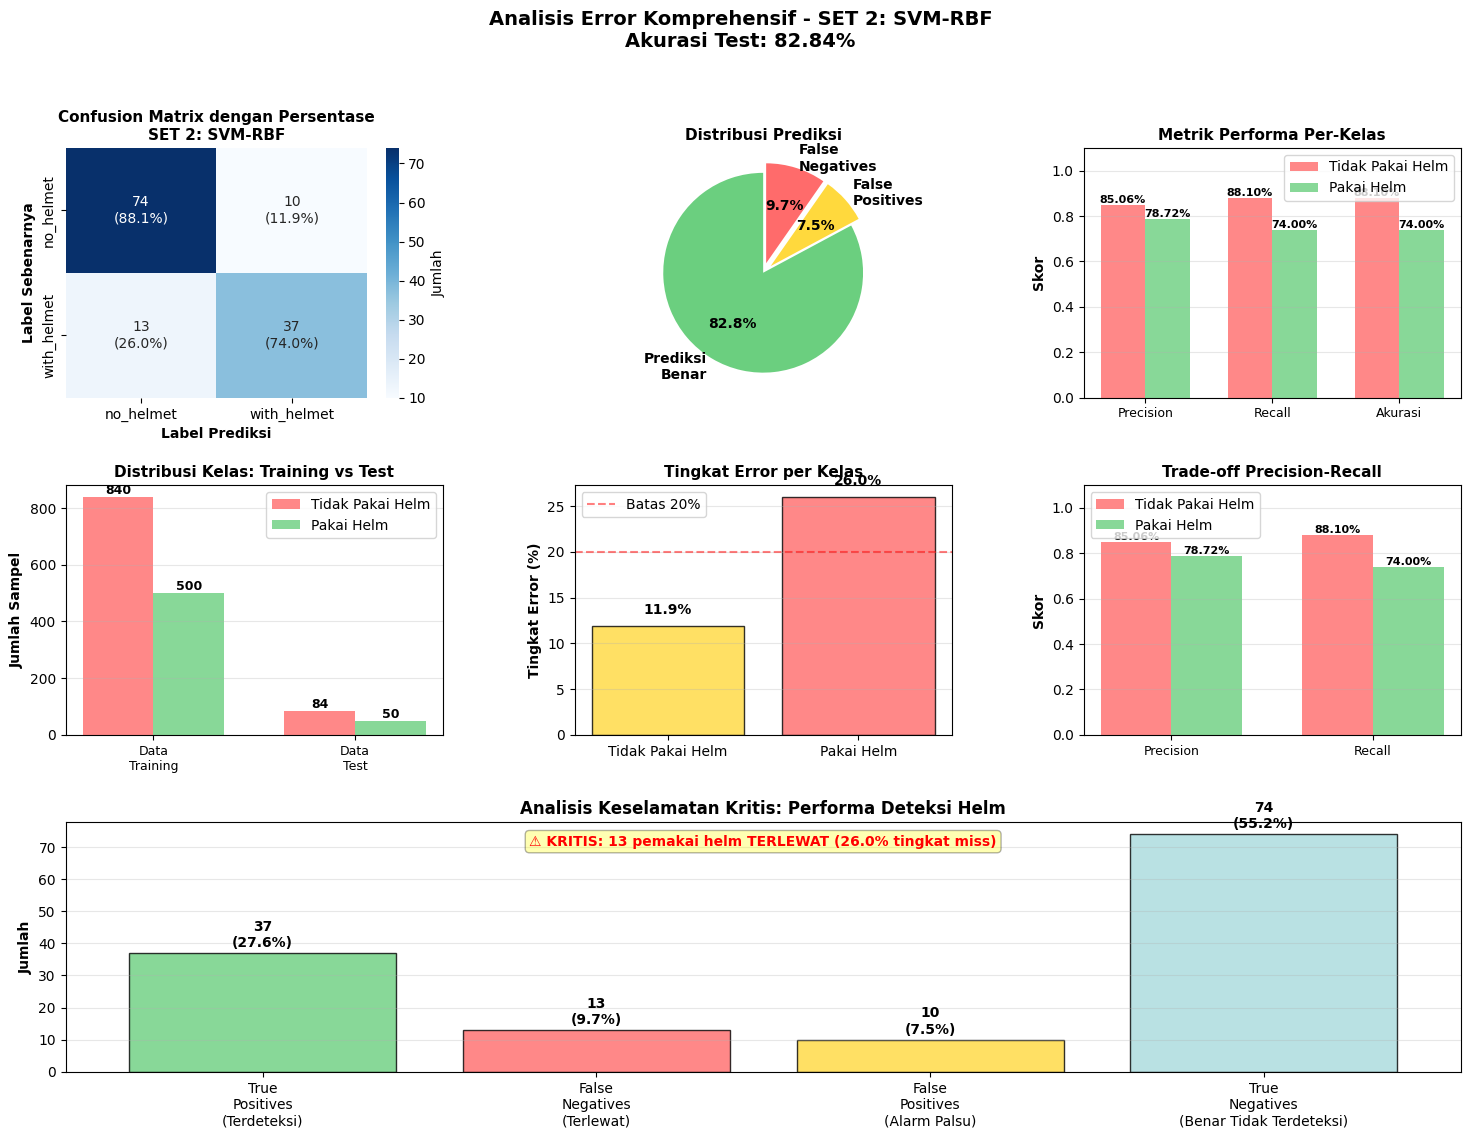

🔎 5. ANALISIS POLA KESALAHAN KLASIFIKASI

📍 Ringkasan Kesalahan Klasifikasi:
   • Total salah klasifikasi: 23 (17.2%)
   • Terklasifikasi benar: 111 (82.8%)

🔴 Analisis False Positives (prediksi PAKAI helm, sebenarnya TIDAK pakai helm):
   • Jumlah: 10
   • Persentase dari test set: 7.5%
   • Dampak: Error berisiko rendah (alarm palsu)

🔴 Analisis False Negatives (prediksi TIDAK pakai helm, sebenarnya PAKAI helm):
   • Jumlah: 13
   • Persentase dari test set: 9.7%
   • Dampak: Error BERISIKO TINGGI (pelanggaran keselamatan terlewat!)
💡 6. REKOMENDASI UNTUK PERBAIKAN

🎯 Berdasarkan Analisis Error:

   ⚠️ TINGKAT FALSE NEGATIVE TINGGI (26.0%):
      1. Tambah data training untuk kelas 'pakai helm'
      2. Terapkan augmentasi data lebih agresif untuk kelas minoritas
      3. Sesuaikan class weights untuk lebih menghukum FN
      4. Pertimbangkan metode ensemble untuk mengurangi miss rate
      5. Tuning threshold: Turunkan threshold prediksi untuk 'pakai helm'

   ⚖️ KETIDAKSEIMBANGAN K

,Metrik,Nilai
0,Total Sampel Test,134
1,Prediksi Benar,111
2,Total Error,23
3,False Positives (FP),10
4,False Negatives (FN),13
5,True Positives (TP),37
6,True Negatives (TN),74
7,Akurasi Keseluruhan,82.84%
8,Tingkat Error,17.16%
9,Precision (Tidak Pakai Helm),85.06%



✅ Ringkasan tersimpan di: /content/drive/MyDrive/jurnal YOLO/Machine Learning/hasil colab/ringkasan_analisis_error.csv


In [ ]:
# @title
# Ambil prediksi dari model terbaik
y_true = best_overall['y_test']
y_pred = best_overall['y_pred']


print("📊 1. BREAKDOWN CONFUSION MATRIX")

cm = confusion_matrix(y_true, y_pred)
tn, fp, fn, tp = cm.ravel()

print(f"\n🎯 Komponen Confusion Matrix:")
print(f"   True Negatives (TN):  {tn:3d} - Prediksi benar 'tidak pakai helm'")
print(f"   False Positives (FP): {fp:3d} - Prediksi 'pakai helm' tapi sebenarnya 'tidak pakai helm' ⚠️")
print(f"   False Negatives (FN): {fn:3d} - Prediksi 'tidak pakai helm' tapi sebenarnya 'pakai helm'!")
print(f"   True Positives (TP):  {tp:3d} - Prediksi benar 'pakai helm'")

# Hitung metrik per kelas
precision_no_helmet = tn / (tn + fn) if (tn + fn) > 0 else 0
recall_no_helmet = tn / (tn + fp) if (tn + fp) > 0 else 0
precision_with_helmet = tp / (tp + fp) if (tp + fp) > 0 else 0
recall_with_helmet = tp / (tp + fn) if (tp + fn) > 0 else 0

print(f"\n📈 Metrik Per-Kelas:")
print(f"\n   TIDAK PAKAI HELM (Kelas 0):")
print(f"      • Total sampel: {tn + fp}")
print(f"      • Terklasifikasi benar: {tn} ({tn/(tn+fp)*100:.1f}%)")
print(f"      • Salah klasifikasi: {fp} ({fp/(tn+fp)*100:.1f}%)")
print(f"      • Precision: {precision_no_helmet:.2%}")
print(f"      • Recall: {recall_no_helmet:.2%}")
print(f"      • Tingkat Error: {fp/(tn+fp)*100:.1f}%")

print(f"\n   PAKAI HELM (Kelas 1):")
print(f"      • Total sampel: {tp + fn}")
print(f"      • Terklasifikasi benar: {tp} ({tp/(tp+fn)*100:.1f}%)")
print(f"      • Salah klasifikasi: {fn} ({fn/(tp+fn)*100:.1f}%)")
print(f"      • Precision: {precision_with_helmet:.2%}")
print(f"      • Recall: {recall_with_helmet:.2%}")
print(f"      • Tingkat Error: {fn/(tp+fn)*100:.1f}%")


print("🔍 2. ANALISIS TIPE ERROR")

total_errors = fp + fn
total_samples = len(y_true)

print(f"\n📉 Statistik Error Keseluruhan:")
print(f"   • Total sampel: {total_samples}")
print(f"   • Total error: {total_errors}")
print(f"   • Tingkat error: {total_errors/total_samples*100:.2f}%")
print(f"   • Akurasi: {(total_samples-total_errors)/total_samples*100:.2f}%")

print(f"\n⚠️ Distribusi Error:")
print(f"   • False Positives: {fp} ({fp/total_errors*100:.1f}% dari total error)")
print(f"     → Model OVER-prediksi 'pakai helm'")
print(f"     → Mengira orang pakai helm padahal TIDAK")
print(f"     → Dampak: Risiko rendah (alarm palsu)")
print(f"\n   • False Negatives: {fn} ({fn/total_errors*100:.1f}% dari total error)")
print(f"     → Model UNDER-prediksi 'pakai helm'")
print(f"     → Melewatkan orang yang SEBENARNYA pakai helm")
print(f"     → Dampak: KRITIS (risiko keselamatan!)")

# Tentukan bias error
if fp > fn:
    print(f"\n🎯 Bias Model: KONSERVATIF (cenderung memprediksi 'pakai helm')")
    print(f"   → Lebih baik untuk aplikasi keselamatan (false negative lebih sedikit)")
elif fn > fp:
    print(f"\n🎯 Bias Model: LIBERAL (cenderung memprediksi 'tidak pakai helm')")
    print(f"   → Berbahaya untuk keselamatan! Lebih banyak false negative = pelanggaran terlewat")
else:
    print(f"\n🎯 Bias Model: SEIMBANG (FP dan FN sama)")


print("⚖️ 3. DAMPAK KETIDAKSEIMBANGAN KELAS")

# Hitung distribusi original dari semua data (gunakan y_train + y_val + y_test atau labels asli)
# Untuk mendapatkan distribusi training yang digunakan, kita ambil dari hasil run_experiment
# Alternatif: hitung dari test set yang tersedia
try:
    # Coba ambil dari labels global jika ada
    unique_all, counts_all = np.unique(labels, return_counts=True)
    class_dist = dict(zip(unique_all.astype(int), counts_all))
except:
    # Jika gagal, estimasi dari test set saja
    unique_all, counts_all = np.unique(y_true, return_counts=True)
    # Estimasi proporsi dari test set (asumsi proporsi sama)
    total_estimated = len(y_true) * 10  # Asumsi test = 10% dari total
    class_dist = {int(k): int(v * 10) for k, v in zip(unique_all, counts_all)}

print(f"\n📊 Distribusi Dataset Awal:")
if 0 in class_dist and 1 in class_dist:
    print(f"   • Tidak pakai helm (0): {class_dist[0]} sampel ({class_dist[0]/sum(class_dist.values())*100:.1f}%)")
    print(f"   • Pakai helm (1): {class_dist[1]} sampel ({class_dist[1]/sum(class_dist.values())*100:.1f}%)")
    print(f"   • Rasio ketidakseimbangan: {class_dist[0]/class_dist[1]:.2f}:1")
else:
    print(f"   ⚠️ Tidak dapat menghitung distribusi dataset awal")
    print(f"   • Menggunakan distribusi test set sebagai referensi")

# Distribusi test set
unique_test, counts_test = np.unique(y_true, return_counts=True)
test_dist = dict(zip(unique_test, counts_test))

print(f"\n📊 Distribusi Test Set:")
print(f"   • Tidak pakai helm (0): {test_dist[0]} sampel ({test_dist[0]/len(y_true)*100:.1f}%)")
print(f"   • Pakai helm (1): {test_dist[1]} sampel ({test_dist[1]/len(y_true)*100:.1f}%)")

# Hitung bias performa
accuracy_no_helmet = tn / (tn + fp)
accuracy_with_helmet = tp / (tp + fn)
performance_gap = abs(accuracy_no_helmet - accuracy_with_helmet)

print(f"\n📈 Perbandingan Performa:")
print(f"   • Akurasi tidak pakai helm: {accuracy_no_helmet:.2%}")
print(f"   • Akurasi pakai helm: {accuracy_with_helmet:.2%}")
print(f"   • Gap performa: {performance_gap:.2%}")

if performance_gap > 0.10:
    print(f"\n⚠️ PERINGATAN: Gap performa signifikan terdeteksi!")
    print(f"   → Model berkinerja lebih baik pada '{CLASS_NAMES[0 if accuracy_no_helmet > accuracy_with_helmet else 1]}'")
    print(f"   → Kemungkinan karena ketidakseimbangan kelas pada data training")
else:
    print(f"\n✅ Performa seimbang antar kelas")


print("📊 4. MEMBUAT VISUALISASI ANALISIS ERROR")

fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 3, hspace=0.35, wspace=0.35)

# 4.1 Confusion Matrix dengan Persentase
ax1 = fig.add_subplot(gs[0, 0])
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
annot_labels = np.array([[f'{cm[i,j]}\n({cm_percent[i,j]:.1%})' for j in range(cm.shape[1])] for i in range(cm.shape[0])])
sns.heatmap(cm, annot=annot_labels, fmt='', cmap='Blues',
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES,
            ax=ax1, cbar_kws={'label': 'Jumlah'})
ax1.set_title(f'Confusion Matrix dengan Persentase\n{set_names_dict[id(best_overall)]}: {best_overall["algorithm"]}',
              fontweight='bold', fontsize=11)
ax1.set_ylabel('Label Sebenarnya', fontweight='bold')
ax1.set_xlabel('Label Prediksi', fontweight='bold')

# 4.2 Distribusi Tipe Error (Pie Chart)
ax2 = fig.add_subplot(gs[0, 1])
error_types = ['Prediksi\nBenar', 'False\nPositives', 'False\nNegatives']
error_counts = [tn + tp, fp, fn]
colors_pie = ['#6bcf7f', '#ffd93d', '#ff6b6b']
explode = (0, 0.1, 0.1)

ax2.pie(error_counts, labels=error_types, autopct='%1.1f%%', startangle=90,
        colors=colors_pie, explode=explode, textprops={'fontweight': 'bold'})
ax2.set_title('Distribusi Prediksi', fontweight='bold', fontsize=11)

# 4.3 Metrik Performa Per-Kelas
ax3 = fig.add_subplot(gs[0, 2])
metrics_data = {
    'Tidak Pakai Helm': [precision_no_helmet, recall_no_helmet, accuracy_no_helmet],
    'Pakai Helm': [precision_with_helmet, recall_with_helmet, accuracy_with_helmet]
}
x = np.arange(len(['Precision', 'Recall', 'Akurasi']))
width = 0.35

bars1 = ax3.bar(x - width/2, metrics_data['Tidak Pakai Helm'], width, label='Tidak Pakai Helm', color='#ff6b6b', alpha=0.8)
bars2 = ax3.bar(x + width/2, metrics_data['Pakai Helm'], width, label='Pakai Helm', color='#6bcf7f', alpha=0.8)

ax3.set_ylabel('Skor', fontweight='bold')
ax3.set_title('Metrik Performa Per-Kelas', fontweight='bold', fontsize=11)
ax3.set_xticks(x)
ax3.set_xticklabels(['Precision', 'Recall', 'Akurasi'], fontsize=9)
ax3.legend()
ax3.grid(axis='y', alpha=0.3)
ax3.set_ylim([0, 1.1])

# Tambah label nilai pada bar
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2%}', ha='center', va='bottom', fontsize=8, fontweight='bold')

# 4.4 Perbandingan Distribusi Kelas
ax4 = fig.add_subplot(gs[1, 0])
categories = ['Data\nTraining', 'Data\nTest']

# Ambil distribusi dengan aman
if 0 in class_dist and 1 in class_dist:
    no_helmet_counts = [class_dist[0], test_dist.get(0, 0)]
    with_helmet_counts = [class_dist[1], test_dist.get(1, 0)]
else:
    # Jika class_dist tidak tersedia, gunakan test dist saja
    no_helmet_counts = [test_dist.get(0, 0) * 8, test_dist.get(0, 0)]  # Estimasi 80% training
    with_helmet_counts = [test_dist.get(1, 0) * 8, test_dist.get(1, 0)]

x = np.arange(len(categories))
width = 0.35

bars1 = ax4.bar(x - width/2, no_helmet_counts, width, label='Tidak Pakai Helm', color='#ff6b6b', alpha=0.8)
bars2 = ax4.bar(x + width/2, with_helmet_counts, width, label='Pakai Helm', color='#6bcf7f', alpha=0.8)

ax4.set_ylabel('Jumlah Sampel', fontweight='bold')
ax4.set_title('Distribusi Kelas: Training vs Test', fontweight='bold', fontsize=11)
ax4.set_xticks(x)
ax4.set_xticklabels(categories, fontsize=9)
ax4.legend()
ax4.grid(axis='y', alpha=0.3)

# Tambah label nilai
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}', ha='center', va='bottom', fontsize=9, fontweight='bold')

# 4.5 Tingkat Error per Kelas
ax5 = fig.add_subplot(gs[1, 1])
classes = ['Tidak Pakai Helm', 'Pakai Helm']
error_rates = [fp/(tn+fp)*100, fn/(tp+fn)*100]
colors_err = ['#ffd93d' if e < 20 else '#ff6b6b' for e in error_rates]

bars = ax5.bar(classes, error_rates, color=colors_err, edgecolor='black', alpha=0.8)
ax5.set_ylabel('Tingkat Error (%)', fontweight='bold')
ax5.set_title('Tingkat Error per Kelas', fontweight='bold', fontsize=11)
ax5.axhline(y=20, color='red', linestyle='--', alpha=0.5, label='Batas 20%')
ax5.legend()
ax5.grid(axis='y', alpha=0.3)

for i, (bar, val) in enumerate(zip(bars, error_rates)):
    ax5.text(bar.get_x() + bar.get_width()/2., val + 1,
            f'{val:.1f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')

# 4.6 Trade-off Precision-Recall
ax6 = fig.add_subplot(gs[1, 2])
metrics_comparison = ['Precision', 'Recall']
no_helmet_metrics = [precision_no_helmet, recall_no_helmet]
with_helmet_metrics = [precision_with_helmet, recall_with_helmet]

x = np.arange(len(metrics_comparison))
width = 0.35

bars1 = ax6.bar(x - width/2, no_helmet_metrics, width, label='Tidak Pakai Helm', color='#ff6b6b', alpha=0.8)
bars2 = ax6.bar(x + width/2, with_helmet_metrics, width, label='Pakai Helm', color='#6bcf7f', alpha=0.8)

ax6.set_ylabel('Skor', fontweight='bold')
ax6.set_title('Trade-off Precision-Recall', fontweight='bold', fontsize=11)
ax6.set_xticks(x)
ax6.set_xticklabels(metrics_comparison, fontsize=9)
ax6.legend()
ax6.grid(axis='y', alpha=0.3)
ax6.set_ylim([0, 1.1])

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax6.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2%}', ha='center', va='bottom', fontsize=8, fontweight='bold')

# 4.7 Analisis Keselamatan Kritis
ax7 = fig.add_subplot(gs[2, :])
safety_metrics = ['True\nPositives\n(Terdeteksi)', 'False\nNegatives\n(Terlewat)', 'False\nPositives\n(Alarm Palsu)', 'True\nNegatives\n(Benar Tidak Terdeteksi)']
safety_counts = [tp, fn, fp, tn]
safety_colors = ['#6bcf7f', '#ff6b6b', '#ffd93d', '#a8dadc']

bars = ax7.bar(safety_metrics, safety_counts, color=safety_colors, edgecolor='black', alpha=0.8)
ax7.set_ylabel('Jumlah', fontweight='bold')
ax7.set_title('Analisis Keselamatan Kritis: Performa Deteksi Helm', fontweight='bold', fontsize=12)
ax7.grid(axis='y', alpha=0.3)

# Tambah anotasi
for i, (bar, val) in enumerate(zip(bars, safety_counts)):
    percentage = val / len(y_true) * 100
    ax7.text(bar.get_x() + bar.get_width()/2., val + 1,
            f'{val}\n({percentage:.1f}%)', ha='center', va='bottom', fontsize=10, fontweight='bold')

# Tambah interpretasi keselamatan
safety_text = f"⚠️ KRITIS: {fn} pemakai helm TERLEWAT ({fn/(tp+fn)*100:.1f}% tingkat miss)"
ax7.text(0.5, 0.95, safety_text, transform=ax7.transAxes,
         ha='center', va='top', fontsize=10, fontweight='bold', color='red',
         bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.3))

plt.suptitle(f'Analisis Error Komprehensif - {set_names_dict[id(best_overall)]}: {best_overall["algorithm"]}\nAkurasi Test: {best_overall["test_acc"]:.2%}',
             fontsize=14, fontweight='bold', y=0.995)

# Simpan ke Google Drive
drive_save_path = "/content/drive/MyDrive/jurnal YOLO/Machine Learning/hasil colab"
os.makedirs(drive_save_path, exist_ok=True)

save_path_error = os.path.join(drive_save_path, 'analisis_error_detail.png')
plt.savefig(save_path_error, dpi=300, bbox_inches='tight')
print(f"✅ Tersimpan: {save_path_error}")
plt.show()


print("🔎 5. ANALISIS POLA KESALAHAN KLASIFIKASI")
# Cari indeks yang salah klasifikasi
misclassified_indices = np.where(y_true != y_pred)[0]
correct_indices = np.where(y_true == y_pred)[0]

print(f"\n📍 Ringkasan Kesalahan Klasifikasi:")
print(f"   • Total salah klasifikasi: {len(misclassified_indices)} ({len(misclassified_indices)/len(y_true)*100:.1f}%)")
print(f"   • Terklasifikasi benar: {len(correct_indices)} ({len(correct_indices)/len(y_true)*100:.1f}%)")

# Analisis FP dan FN terpisah
fp_indices = np.where((y_true == 0) & (y_pred == 1))[0]
fn_indices = np.where((y_true == 1) & (y_pred == 0))[0]

print(f"\n🔴 Analisis False Positives (prediksi PAKAI helm, sebenarnya TIDAK pakai helm):")
print(f"   • Jumlah: {len(fp_indices)}")
print(f"   • Persentase dari test set: {len(fp_indices)/len(y_true)*100:.1f}%")
print(f"   • Dampak: Error berisiko rendah (alarm palsu)")

print(f"\n🔴 Analisis False Negatives (prediksi TIDAK pakai helm, sebenarnya PAKAI helm):")
print(f"   • Jumlah: {len(fn_indices)}")
print(f"   • Persentase dari test set: {len(fn_indices)/len(y_true)*100:.1f}%")
print(f"   • Dampak: Error BERISIKO TINGGI (pelanggaran keselamatan terlewat!)")


print("💡 6. REKOMENDASI UNTUK PERBAIKAN")
print("\n🎯 Berdasarkan Analisis Error:")

# Rekomendasi berdasarkan false negative rate
fn_rate = fn / (tp + fn)
if fn_rate > 0.20:
    print(f"\n   ⚠️ TINGKAT FALSE NEGATIVE TINGGI ({fn_rate:.1%}):")
    print(f"      1. Tambah data training untuk kelas 'pakai helm'")
    print(f"      2. Terapkan augmentasi data lebih agresif untuk kelas minoritas")
    print(f"      3. Sesuaikan class weights untuk lebih menghukum FN")
    print(f"      4. Pertimbangkan metode ensemble untuk mengurangi miss rate")
    print(f"      5. Tuning threshold: Turunkan threshold prediksi untuk 'pakai helm'")

# Rekomendasi berdasarkan class imbalance
if 0 in class_dist and 1 in class_dist:
    imbalance_ratio = class_dist[0] / class_dist[1]
    if imbalance_ratio > 1.5:
        print(f"\n   ⚖️ KETIDAKSEIMBANGAN KELAS TERDETEKSI (rasio {imbalance_ratio:.2f}:1):")
        print(f"      1. Kumpulkan lebih banyak sampel 'pakai helm'")
        print(f"      2. Terapkan SMOTE atau teknik oversampling lain (sudah diterapkan ✓)")
        print(f"      3. Gunakan class_weight='balanced' pada algoritma (sudah diterapkan ✓)")
        print(f"      4. Pertimbangkan focal loss untuk training")

# Rekomendasi berdasarkan performance gap
if performance_gap > 0.10:
    print(f"\n   📊 GAP PERFORMA TERDETEKSI ({performance_gap:.1%}):")
    print(f"      1. Model bias terhadap kelas mayoritas")
    print(f"      2. Butuh representasi fitur yang lebih baik untuk kelas minoritas")
    print(f"      3. Pertimbangkan stratified sampling yang lebih agresif")

# Rekomendasi feature engineering
print(f"\n   🔧 SARAN FEATURE ENGINEERING:")
print(f"      1. Coba gabungkan multiple feature sets (ensemble)")
print(f"      2. Eksperimen dengan konfigurasi HOG yang lebih dalam")
print(f"      3. Tambah transformasi color-space (HSV, LAB)")
print(f"      4. Sertakan fitur spatial pyramid")
print(f"      5. Coba deep features dari CNN pre-trained")

# Rekomendasi algoritma
if best_overall['algorithm'] == 'SVM-RBF':
    print(f"\n   🤖 TUNING ALGORITMA:")
    print(f"      1. Saat ini: SVM-RBF (pilihan bagus ✓)")
    print(f"      2. Fine-tune parameter C dan gamma via GridSearch")
    print(f"      3. Coba ensemble dari 2-3 algoritma terbaik")
    print(f"      4. Pertimbangkan XGBoost atau LightGBM untuk performa lebih baik")

print(f"\n   📈 PERTIMBANGAN DEPLOYMENT:")
print(f"      1. Set threshold lebih tinggi untuk 'pakai helm' untuk kurangi FN")
print(f"      2. Implementasi confidence-based rejection untuk prediksi tidak pasti")
print(f"      3. Tambah human-in-the-loop untuk kasus borderline")
print(f"      4. Lakukan retraining model berkala dengan data baru")


print("📋 7. RINGKASAN STATISTIK")


summary_data = {
    'Metrik': [
        'Total Sampel Test',
        'Prediksi Benar',
        'Total Error',
        'False Positives (FP)',
        'False Negatives (FN)',
        'True Positives (TP)',
        'True Negatives (TN)',
        'Akurasi Keseluruhan',
        'Tingkat Error',
        'Precision (Tidak Pakai Helm)',
        'Recall (Tidak Pakai Helm)',
        'Precision (Pakai Helm)',
        'Recall (Pakai Helm)',
        'F1-Score (Tidak Pakai Helm)',
        'F1-Score (Pakai Helm)',
        'Rasio Ketidakseimbangan Kelas',
        'Tingkat FN (KRITIS)',
        'Tingkat FP'
    ],
    'Nilai': [
        len(y_true),
        tn + tp,
        fp + fn,
        fp,
        fn,
        tp,
        tn,
        f"{(tn+tp)/len(y_true):.2%}",
        f"{(fp+fn)/len(y_true):.2%}",
        f"{precision_no_helmet:.2%}",
        f"{recall_no_helmet:.2%}",
        f"{precision_with_helmet:.2%}",
        f"{recall_with_helmet:.2%}",
        f"{2*precision_no_helmet*recall_no_helmet/(precision_no_helmet+recall_no_helmet):.2%}" if (precision_no_helmet+recall_no_helmet) > 0 else "0.00%",
        f"{2*precision_with_helmet*recall_with_helmet/(precision_with_helmet+recall_with_helmet):.2%}" if (precision_with_helmet+recall_with_helmet) > 0 else "0.00%",
        f"{class_dist[0]/class_dist[1]:.2f}:1" if (0 in class_dist and 1 in class_dist) else "N/A",
        f"{fn/(tp+fn):.2%}",
        f"{fp/(tn+fp):.2%}"
    ]
}

df_summary = pd.DataFrame(summary_data)
print("\n")
display(df_summary)

# Simpan ringkasan ke CSV
csv_path = os.path.join(drive_save_path, 'ringkasan_analisis_error.csv')
df_summary.to_csv(csv_path, index=False)
print(f"\n✅ Ringkasan tersimpan di: {csv_path}")


## Simpen



In [ ]:
# @title
print("\n💾 Saving overall best model...")

feature_extractors = {
    id(best_set1): extract_set1_features,
    id(best_set2): extract_set2_features,
    id(best_set3): extract_set3_features
}

with open(os.path.join(drive_save_path, 'best_overall_model_part1.pkl'), 'wb') as f:
    pickle.dump({
        'model': best_overall['model'],
        'scaler': best_overall['scaler'],
        'pca': best_overall['pca'],
        'feature_set': set_names_dict[id(best_overall)],
        'algorithm': best_overall['algorithm'],
        'feature_extractor': feature_extractors[id(best_overall)],
        'class_names': CLASS_NAMES,
        'test_acc': best_overall['test_acc'],
        'val_acc': best_overall['val_acc'],
        'train_acc': best_overall['train_acc'],
        'precision': best_overall['precision'],
        'recall': best_overall['recall'],
        'f1_score': best_overall['f1_score'],
        'overfitting': best_overall['overfitting']
    }, f)

print(f"✅ Overall best model saved: best_overall_model.pkl")


💾 Saving overall best model...
✅ Overall best model saved: best_overall_model.pkl


##PREPARING VARIABLES FOR PART 2

In [ ]:
# @title
# ============================================================================
# PREPARING VARIABLES FOR PART 2
# ============================================================================
print("\n" + "="*80)
print("🔗 PREPARING VARIABLES FOR PART 2 (CNN FROM SCRATCH)")
print("="*80)

# Re-load original cropped images to ensure integrity
cropped_images_reloaded, labels_reloaded = load_cropped_data(dataset.location)

# Backup data for Part 2
cropped_images_for_part2 = cropped_images_reloaded.copy()
labels_for_part2 = labels_reloaded.copy()

# Backup best models from Part 1
best_models_part1 = {
    'SET 1': best_set1,
    'SET 2': best_set2,
    'SET 3': best_set3
}

print(f"\n✅ Variables prepared for Part 2:")
print(f"   cropped_images_for_part2: {len(cropped_images_for_part2)} images")
print(f"   labels_for_part2: {len(labels_for_part2)} labels")
print(f"   Distribution: {np.bincount(labels_for_part2).tolist()}")
print(f"   CLASS_NAMES: {CLASS_NAMES}")
print(f"   best_models_part1: {list(best_models_part1.keys())}")
print(f"   drive_save_path: {drive_save_path}")

print("\n✅ Best models from Part 1:")
for set_name, best_model in best_models_part1.items():
    print(f"   {set_name}: {best_model['algorithm']} - Test Acc: {best_model['test_acc']:.2%}")

print("\n" + "="*80)
print("✅ PART 1 COMPLETED! READY FOR PART 2")
print("="*80)


# SAVE CONFIGURATION
import json

config_part1 = {
    'random_seed': 42,
    'image_size': 128,
    'train_test_split': 0.2,
    'val_test_split': 0.5,
    'pca_variance': 0.95,
    'augmentation_enabled': True,
    'smote_enabled': True,
    'cross_validation': False,  # No CV in this version
    'target_classes': TARGET_CLASSES,
    'class_names': CLASS_NAMES,
    'feature_sets': {
        'SET 1': 'Histogram + HOG + LBP',
        'SET 2': 'Color Moments + HOG + GLCM',
        'SET 3': 'Edge + HOG + Color Histogram'
    },
    'algorithms': list(algorithms.keys()),
    'best_model': {
        'feature_set': set_names_dict[id(best_overall)],
        'algorithm': best_overall['algorithm'],
        'test_accuracy': float(best_overall['test_acc']),
        'val_accuracy': float(best_overall['val_acc']),
        'train_accuracy': float(best_overall['train_acc']),
        'precision': float(best_overall['precision']),
        'recall': float(best_overall['recall']),
        'f1_score': float(best_overall['f1_score']),
        'overfitting': float(best_overall['overfitting']),
        'train_time': float(best_overall['train_time'])
    },
    'all_results': []
}

# Add all results
for r in all_results:
    config_part1['all_results'].append({
        'feature_set': r['Feature Set'],
        'algorithm': r['Algorithm'],
        'test_acc': float(r['test_acc_float']),
        'train_time': float(r['Time (s)'].replace('s', ''))
    })

config_path_part1 = os.path.join(drive_save_path, 'config_part1.json')
with open(config_path_part1, 'w') as f:
    json.dump(config_part1, f, indent=2)

print(f"\n✅ Configuration saved: {config_path_part1}")


🔗 PREPARING VARIABLES FOR PART 2 (CNN FROM SCRATCH)

📦 Loading and cropping bboxes...
✅ Processed: 1334 bboxes
   Distribution: [832, 502] (0=no_helmet, 1=with_helmet)

✅ Variables prepared for Part 2:
   cropped_images_for_part2: 1334 images
   labels_for_part2: 1334 labels
   Distribution: [832, 502]
   CLASS_NAMES: ['no_helmet', 'with_helmet']
   best_models_part1: ['SET 1', 'SET 2', 'SET 3']
   drive_save_path: /content/drive/MyDrive/jurnal YOLO/Machine Learning/hasil colab

✅ Best models from Part 1:
   SET 1: SVM-RBF - Test Acc: 79.85%
   SET 2: SVM-RBF - Test Acc: 82.84%
   SET 3: SVM-RBF - Test Acc: 82.84%

✅ PART 1 COMPLETED! READY FOR PART 2

✅ Configuration saved: /content/drive/MyDrive/jurnal YOLO/Machine Learning/hasil colab/config_part1.json


# PART 2: DEEP LEARNING - CNN

In [ ]:
print("\n" + "="*80)
print("VALIDATING DATA FROM PART 1")
print("="*80)

required_vars = {
    'cropped_images_for_part2': 'Cropped images dataset',
    'labels_for_part2': 'Full labels array',
    'CLASS_NAMES': 'Class names list',
    'drive_save_path': 'Google Drive save path'
}

print("\n🔍 Checking required variables...")
missing = []
for var_name, description in required_vars.items():
    if var_name not in globals():
        missing.append(f"❌ {var_name} ({description})")
    else:
        print(f"   ✅ {var_name} - OK")

if missing:
    print("\n⚠️ ERROR: Missing variables from Part 1:")
    for m in missing:
        print(f"      {m}")
    print("\n💡 Please run Part 1 first to generate required variables!")
    raise RuntimeError("Missing required variables from Part 1")

cropped_images = cropped_images_for_part2.copy()
labels = labels_for_part2.copy()

print(f"\n✅ Data loaded successfully!")
print(f"   • Total images: {len(cropped_images)}")
print(f"   • Total labels: {len(labels)}")
print(f"   • Label distribution: {dict(Counter(labels))}")
print(f"   • Classes: {CLASS_NAMES}")


VALIDATING DATA FROM PART 1

🔍 Checking required variables...
   ✅ cropped_images_for_part2 - OK
   ✅ labels_for_part2 - OK
   ✅ CLASS_NAMES - OK
   ✅ drive_save_path - OK

✅ Data loaded successfully!
   • Total images: 1334
   • Total labels: 1334
   • Label distribution: {np.int64(1): 502, np.int64(0): 832}
   • Classes: ['no_helmet', 'with_helmet']


## INSTALL & IMPORT LIBRARIES TAMBAHAN

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import json
import shutil
from collections import Counter
import cv2

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import (classification_report, confusion_matrix,
                             accuracy_score, precision_score, recall_score, f1_score)
from sklearn.utils.class_weight import compute_class_weight

print("\n✅ Libraries imported successfully!")
print(f"   • TensorFlow version: {tf.__version__}")


def set_all_seeds(seed=42):
    """Set all random seeds for complete reproducibility"""
    import random
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

    try:
        tf.config.experimental.enable_op_determinism()
    except:
        pass

    print(f"\n🎲 All seeds set to: {seed}")
    print("   ✓ Python random")
    print("   ✓ NumPy")
    print("   ✓ TensorFlow")
    print("   ✓ Deterministic operations enabled")
    print("   ✓ Results will be FULLY reproducible!")

set_all_seeds(42)

# Check GPU
gpu_devices = tf.config.list_physical_devices('GPU')
print(f"\n🖥️  GPU Status:")
if gpu_devices:
    print(f"   ✅ GPU Available: {gpu_devices[0].name}")
    for gpu in gpu_devices:
        tf.config.experimental.set_memory_growth(gpu, True)
else:
    print(f"   ⚠️  No GPU detected, using CPU")


✅ Libraries imported successfully!
   • TensorFlow version: 2.19.0

🎲 All seeds set to: 42
   ✓ Python random
   ✓ NumPy
   ✓ TensorFlow
   ✓ Deterministic operations enabled
   ✓ Results will be FULLY reproducible!

🖥️  GPU Status:
   ✅ GPU Available: /physical_device:GPU:0


## CONFIGURATION

In [ ]:
CNN_CONFIG = {
    # Model architecture
    'model_name': 'Custom_CNN',
    'image_size': 128,
    'num_classes': 2,

    # CNN architecture details
    'conv_filters': [32, 64, 128, 256],
    'kernel_size': 3,
    'pool_size': 2,
    'dense_units': [256, 128],
    'dropout_rate': 0.5,
    'use_batch_norm': True,

    # Training hyperparameters
    'batch_size': 32,
    'epochs': 50,
    'learning_rate': 0.001,
    'weight_decay': 0.0001,

    # Callbacks
    'early_stopping_patience': 10,
    'reduce_lr_patience': 5,
    'reduce_lr_factor': 0.5,
    'min_lr': 1e-7,

    # Data augmentation
    'use_augmentation': True,

    # Reproducibility
    'random_seed': 42
}

print("\n" + "="*80)
print("CUSTOM CNN CONFIGURATION")
print("="*80)
print("\n⚙️  Configuration:")
for key, value in CNN_CONFIG.items():
    print(f"   • {key:.<35} {value}")


CUSTOM CNN CONFIGURATION

⚙️  Configuration:
   • model_name......................... Custom_CNN
   • image_size......................... 128
   • num_classes........................ 2
   • conv_filters....................... [32, 64, 128, 256]
   • kernel_size........................ 3
   • pool_size.......................... 2
   • dense_units........................ [256, 128]
   • dropout_rate....................... 0.5
   • use_batch_norm..................... True
   • batch_size......................... 32
   • epochs............................. 50
   • learning_rate...................... 0.001
   • weight_decay....................... 0.0001
   • early_stopping_patience............ 10
   • reduce_lr_patience................. 5
   • reduce_lr_factor................... 0.5
   • min_lr............................. 1e-07
   • use_augmentation................... True
   • random_seed........................ 42


## PREPARE DATA

In [ ]:
# Create data augmentation layer
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal", seed=CNN_CONFIG['random_seed']),
    layers.RandomRotation(0.15, seed=CNN_CONFIG['random_seed']),
    layers.RandomZoom(0.1, seed=CNN_CONFIG['random_seed']),
    layers.RandomContrast(0.2, seed=CNN_CONFIG['random_seed']),
], name='data_augmentation')

print("\n✅ Data augmentation configured:")
print("   • Random horizontal flip (p=0.5)")
print("   • Random rotation (±15°)")
print("   • Random zoom (±10%)")
print("   • Random contrast adjustment (±20%)")
print("   • Applied ONLY during training")


✅ Data augmentation configured:
   • Random horizontal flip (p=0.5)
   • Random rotation (±15°)
   • Random zoom (±10%)
   • Random contrast adjustment (±20%)
   • Applied ONLY during training


In [ ]:
print("\n📊 Preprocessing images...")

X_images = []
for img in cropped_images:
    resized = cv2.resize(img, (CNN_CONFIG['image_size'], CNN_CONFIG['image_size']))
    resized_rgb = cv2.cvtColor(resized, cv2.COLOR_BGR2RGB)
    X_images.append(resized_rgb)

X_images = np.array(X_images, dtype='float32')
y_labels = np.array(labels)

# Normalize to [0, 1]
X_images = X_images / 255.0

print(f"\n✅ Data prepared:")
print(f"   • X_images shape: {X_images.shape}")
print(f"   • y_labels shape: {y_labels.shape}")
print(f"   • Value range: [{X_images.min():.2f}, {X_images.max():.2f}]")
print(f"   • Label distribution: {dict(Counter(y_labels))}")

assert X_images.shape[0] == y_labels.shape[0], "Image-label mismatch!"
assert X_images.shape[1:] == (CNN_CONFIG['image_size'], CNN_CONFIG['image_size'], 3), "Wrong image shape!"

print(f"\n✅ Data validation passed!")


print("\n📊 Splitting data (stratified)...")

X_train, X_temp, y_train, y_temp = train_test_split(
    X_images, y_labels,
    test_size=0.2,
    random_state=CNN_CONFIG['random_seed'],
    stratify=y_labels
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,
    random_state=CNN_CONFIG['random_seed'],
    stratify=y_temp
)

print(f"\n✅ Data split completed:")
print(f"   • Train: {len(X_train):4d} samples - {dict(Counter(y_train))}")
print(f"   • Val:   {len(X_val):4d} samples - {dict(Counter(y_val))}")
print(f"   • Test:  {len(X_test):4d} samples - {dict(Counter(y_test))}")

class_weights_array = compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = {i: class_weights_array[i] for i in range(len(class_weights_array))}

print(f"\n⚖️  Class weights (for imbalance handling):")
for cls, weight in class_weights.items():
    print(f"   • Class {cls} ({CLASS_NAMES[cls]}): {weight:.3f}")


📊 Preprocessing images...

✅ Data prepared:
   • X_images shape: (1334, 128, 128, 3)
   • y_labels shape: (1334,)
   • Value range: [0.00, 1.00]
   • Label distribution: {np.int64(1): 502, np.int64(0): 832}

✅ Data validation passed!

📊 Splitting data (stratified)...

✅ Data split completed:
   • Train: 1067 samples - {np.int64(1): 402, np.int64(0): 665}
   • Val:    133 samples - {np.int64(0): 83, np.int64(1): 50}
   • Test:   134 samples - {np.int64(1): 50, np.int64(0): 84}

⚖️  Class weights (for imbalance handling):
   • Class 0 (no_helmet): 0.802
   • Class 1 (with_helmet): 1.327


## BUILD CNN MODEL

In [ ]:
def create_custom_cnn(config):
    """Create custom CNN architecture from scratch"""

    print(f"\n🔨 Building Custom CNN from scratch...")
    print(f"   • Architecture: {len(config['conv_filters'])} Conv blocks")
    print(f"   • Strategy: Training from random initialization")
    print(f"   • NO pretrained weights")

    inputs = keras.Input(shape=(config['image_size'], config['image_size'], 3))

    # Data augmentation (only during training)
    x = data_augmentation(inputs)

    print(f"\n📋 CNN Architecture:")
    print(f"   Input: {config['image_size']}x{config['image_size']}x3")
    print(f"   ↓")
    print(f"   Data Augmentation (training only)")

    # Convolutional blocks
    for i, num_filters in enumerate(config['conv_filters']):
        print(f"   ↓")
        print(f"   Block {i+1}:")

        x = layers.Conv2D(
            num_filters,
            config['kernel_size'],
            padding='same',
            kernel_initializer=keras.initializers.HeNormal(seed=config['random_seed']),
            name=f'conv{i+1}_1'
        )(x)
        print(f"      • Conv2D: {num_filters} filters, {config['kernel_size']}x{config['kernel_size']}")

        if config['use_batch_norm']:
            x = layers.BatchNormalization(name=f'bn{i+1}_1')(x)
            print(f"      • BatchNormalization")

        x = layers.Activation('relu', name=f'relu{i+1}_1')(x)
        print(f"      • Activation: ReLU")

        x = layers.Conv2D(
            num_filters,
            config['kernel_size'],
            padding='same',
            kernel_initializer=keras.initializers.HeNormal(seed=config['random_seed']),
            name=f'conv{i+1}_2'
        )(x)
        print(f"      • Conv2D: {num_filters} filters, {config['kernel_size']}x{config['kernel_size']}")

        if config['use_batch_norm']:
            x = layers.BatchNormalization(name=f'bn{i+1}_2')(x)
            print(f"      • BatchNormalization")

        x = layers.Activation('relu', name=f'relu{i+1}_2')(x)
        print(f"      • Activation: ReLU")

        x = layers.MaxPooling2D(
            pool_size=config['pool_size'],
            name=f'pool{i+1}'
        )(x)
        print(f"      • MaxPooling2D: {config['pool_size']}x{config['pool_size']}")

        x = layers.Dropout(
            config['dropout_rate'] * 0.5,
            seed=config['random_seed'],
            name=f'dropout_conv{i+1}'
        )(x)
        print(f"      • Dropout: {config['dropout_rate'] * 0.5:.2f}")

    print(f"   ↓")
    print(f"   Global Average Pooling")
    x = layers.GlobalAveragePooling2D(name='global_avg_pool')(x)

    # Dense layers
    for i, units in enumerate(config['dense_units']):
        print(f"   ↓")
        print(f"   Dense {i+1}:")

        x = layers.Dropout(
            config['dropout_rate'],
            seed=config['random_seed'],
            name=f'dropout_dense{i+1}'
        )(x)
        print(f"      • Dropout: {config['dropout_rate']}")

        x = layers.Dense(
            units,
            activation='relu',
            kernel_initializer=keras.initializers.GlorotUniform(seed=config['random_seed']),
            kernel_regularizer=keras.regularizers.l2(config['weight_decay']),
            name=f'dense{i+1}'
        )(x)
        print(f"      • Dense: {units} units, ReLU")

    print(f"   ↓")
    print(f"   Output: Dense({config['num_classes']}) + Softmax")
    outputs = layers.Dense(
        config['num_classes'],
        activation='softmax',
        kernel_initializer=keras.initializers.GlorotUniform(seed=config['random_seed']),
        name='output'
    )(x)

    model = keras.Model(inputs=inputs, outputs=outputs, name='Custom_CNN_Helmet_Detector')

    return model

print(f"\n⏳ Creating Custom CNN model...")
model = create_custom_cnn(CNN_CONFIG)

print(f"\n✅ Model created successfully!")

total_params = model.count_params()
trainable_params = sum([tf.size(v).numpy() for v in model.trainable_variables])

print(f"\n📊 Model Statistics:")
print(f"   • Total parameters:     {total_params:,}")
print(f"   • Trainable parameters: {trainable_params:,}")
print(f"   • All parameters are trainable (no pretrained frozen layers)")


print(f"\n⚙️  Compiling model...")

optimizer = keras.optimizers.Adam(learning_rate=CNN_CONFIG['learning_rate'])

model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print(f"   ✅ Optimizer: Adam (lr={CNN_CONFIG['learning_rate']})")
print(f"   ✅ Loss: sparse_categorical_crossentropy")
print(f"   ✅ Metrics: accuracy")

print(f"\n📋 Model Architecture Summary:")
model.summary()


⏳ Creating Custom CNN model...

🔨 Building Custom CNN from scratch...
   • Architecture: 4 Conv blocks
   • Strategy: Training from random initialization
   • NO pretrained weights

📋 CNN Architecture:
   Input: 128x128x3
   ↓
   Data Augmentation (training only)
   ↓
   Block 1:
      • Conv2D: 32 filters, 3x3
      • BatchNormalization
      • Activation: ReLU
      • Conv2D: 32 filters, 3x3
      • BatchNormalization
      • Activation: ReLU
      • MaxPooling2D: 2x2
      • Dropout: 0.25
   ↓
   Block 2:
      • Conv2D: 64 filters, 3x3
      • BatchNormalization
      • Activation: ReLU
      • Conv2D: 64 filters, 3x3
      • BatchNormalization
      • Activation: ReLU
      • MaxPooling2D: 2x2
      • Dropout: 0.25
   ↓
   Block 3:
      • Conv2D: 128 filters, 3x3
      • BatchNormalization
      • Activation: ReLU
      • Conv2D: 128 filters, 3x3
      • BatchNormalization
      • Activation: ReLU
      • MaxPooling2D: 2x2
      • Dropout: 0.25
   ↓
   Block 4:
      • Conv2D: 2

Model: "Custom_CNN_Helmet_Detector"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_1 (Conv2D)                │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn1_1 (BatchNormalization)      │ (None, 128, 128, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu1_1 (Activation)            │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_2 (Conv2D)                │ (None, 128, 128, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn1_2 (BatchNormalization)      │ (None, 128, 128, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu1_2 (Activation)            │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv1 (Dropout)         │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2_1 (Conv2D)                │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn2_1 (BatchNormalization)      │ (None, 64, 64, 64)     │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu2_1 (Activation)            │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2_2 (Conv2D)                │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn2_2 (BatchNormalization)      │ (None, 64, 64, 64)     │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu2_2 (Activation)            │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv2 (Dropout)         │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3_1 (Conv2D)                │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn3_1 (BatchNormalization)      │ (None, 32, 32, 128)    │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu3_1 (Activation)            │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3_2 (Conv2D)                │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn3_2 (BatchNormalization)      │ (None, 32, 32, 128)    │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu3_2 (Activation)            │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool3 (MaxPooling2D)            │ (None, 16, 16, 128)    │             

 Total params: 1,275,042 (4.86 MB)

 Trainable params: 1,273,122 (4.86 MB)

 Non-trainable params: 1,920 (7.50 KB)

## SETUP CALLBACKS

In [ ]:
print(f"\n⚙️  Setting up training callbacks...")

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=CNN_CONFIG['early_stopping_patience'],
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=CNN_CONFIG['reduce_lr_factor'],
    patience=CNN_CONFIG['reduce_lr_patience'],
    min_lr=CNN_CONFIG['min_lr'],
    verbose=1
)

checkpoint_path = f'best_cnn_model_seed{CNN_CONFIG["random_seed"]}.h5'
checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

callbacks = [early_stop, reduce_lr, checkpoint]

print(f"   ✅ Early Stopping (patience={CNN_CONFIG['early_stopping_patience']})")
print(f"   ✅ Reduce LR (factor={CNN_CONFIG['reduce_lr_factor']}, patience={CNN_CONFIG['reduce_lr_patience']})")
print(f"   ✅ Model Checkpoint: {checkpoint_path}")


⚙️  Setting up training callbacks...
   ✅ Early Stopping (patience=10)
   ✅ Reduce LR (factor=0.5, patience=5)
   ✅ Model Checkpoint: best_cnn_model_seed42.h5


## TRAINING

In [ ]:
print(f"\n📊 Training Configuration:")
print(f"   • Dataset size:     {len(X_train)} training samples")
print(f"   • Batch size:       {CNN_CONFIG['batch_size']}")
print(f"   • Max epochs:       {CNN_CONFIG['epochs']}")
print(f"   • Learning rate:    {CNN_CONFIG['learning_rate']}")
print(f"   • Class weights:    {class_weights}")
print(f"   • Random seed:      {CNN_CONFIG['random_seed']}")
print(f"   • Augmentation:     {'Enabled' if CNN_CONFIG['use_augmentation'] else 'Disabled'}")

print(f"\n⏳ Starting training...")


start_time = time.time()

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=CNN_CONFIG['epochs'],
    batch_size=CNN_CONFIG['batch_size'],
    class_weight=class_weights,
    callbacks=callbacks,
    verbose=1,
    shuffle=True
)

training_time = time.time() - start_time

print("TRAINING COMPLETED")


best_epoch = np.argmax(history.history['val_accuracy'])
best_val_acc = max(history.history['val_accuracy'])

print(f"\n📊 Training Summary:")
print(f"   • Total time:           {training_time/60:.2f} minutes ({training_time:.0f} seconds)")
print(f"   • Epochs completed:     {len(history.history['loss'])}")
print(f"   • Best epoch:           {best_epoch + 1}")
print(f"   • Best val accuracy:    {best_val_acc:.4f} ({best_val_acc*100:.2f}%)")
print(f"   • Final train accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"   • Final val accuracy:   {history.history['val_accuracy'][-1]:.4f}")
print(f"   • Avg time per epoch:   {training_time/len(history.history['loss']):.2f}s")



📊 Training Configuration:
   • Dataset size:     1067 training samples
   • Batch size:       32
   • Max epochs:       50
   • Learning rate:    0.001
   • Class weights:    {0: np.float64(0.8022556390977443), 1: np.float64(1.3271144278606966)}
   • Random seed:      42
   • Augmentation:     Enabled

⏳ Starting training...
Epoch 1/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.6101 - loss: 0.8535
Epoch 1: val_accuracy improved from -inf to 0.42857, saving model to best_cnn_model_seed42.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 35s 265ms/step - accuracy: 0.6109 - loss: 0.8519 - val_accuracy: 0.4286 - val_loss: 2.7934 - learning_rate: 0.0010
Epoch 2/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.7008 - loss: 0.7174
Epoch 2: val_accuracy improved from 0.42857 to 0.71429, saving model to best_cnn_model_seed42.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 149ms/step - accuracy: 0.7008 - loss: 0.7164 - val_accuracy: 0.7143 - val_loss: 0.6759 - learning_rate: 0.0010
Epoch 3/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.7436 - loss: 0.6321
Epoch 3: val_accuracy did not improve from 0.71429
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 152ms/step - accuracy: 0.7437 - loss: 0.6313 - val_accuracy: 0.6241 - val_loss: 1.8454 - learning_rate: 0.0010
Epoch 4/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.7284 - loss: 0.6441
Epoch 4: val_accuracy did not improve from 0.71429
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 151ms/step - accuracy: 0.7284 - loss: 0.6429 - val_accuracy: 0.6316 - val_loss: 1.5598 - learning_rate: 0.0010
Epoch 5/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.7613 - loss: 0.5953
Epoch 5: val_accuracy did not improve from 0.71429
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step - accuracy: 0.7612 - loss: 0.5946 - val_accuracy: 0.6241 - val_loss: 3.0609 - learning_rate: 0.0010
Epoch 6/50
34/34 ━━━━━━━━

34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 158ms/step - accuracy: 0.8445 - loss: 0.4258 - val_accuracy: 0.8195 - val_loss: 0.4078 - learning_rate: 5.0000e-04
Epoch 13/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.8514 - loss: 0.4134
Epoch 13: val_accuracy improved from 0.81955 to 0.82707, saving model to best_cnn_model_seed42.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 164ms/step - accuracy: 0.8516 - loss: 0.4132 - val_accuracy: 0.8271 - val_loss: 0.4942 - learning_rate: 5.0000e-04
Epoch 14/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.8633 - loss: 0.3879
Epoch 14: val_accuracy improved from 0.82707 to 0.84211, saving model to best_cnn_model_seed42.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 152ms/step - accuracy: 0.8634 - loss: 0.3876 - val_accuracy: 0.8421 - val_loss: 0.4272 - learning_rate: 5.0000e-04
Epoch 15/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.8614 - loss: 0.4081
Epoch 15: val_accuracy improved from 0.84211 to 0.85714, saving model to best_cnn_model_seed42.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 148ms/step - accuracy: 0.8617 - loss: 0.4074 - val_accuracy: 0.8571 - val_loss: 0.3495 - learning_rate: 5.0000e-04
Epoch 16/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.8592 - loss: 0.3726
Epoch 16: val_accuracy did not improve from 0.85714
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 151ms/step - accuracy: 0.8595 - loss: 0.3725 - val_accuracy: 0.7970 - val_loss: 0.4257 - learning_rate: 5.0000e-04
Epoch 17/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.8583 - loss: 0.4130
Epoch 17: val_accuracy did not improve from 0.85714
34/34 ━━━━━━━━━━━━━━━━━━━━ 10s 152ms/step - accuracy: 0.8584 - loss: 0.4120 - val_accuracy: 0.8195 - val_loss: 0.4221 - learning_rate: 5.0000e-04
Epoch 18/50
33/34 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.8798 - loss: 0.3755
Epoch 18: val_accuracy did not improve from 0.85714
34/34 ━━━━━━━━━━━━━━━━━━━━ 9s 117ms/step - accuracy: 0.8794 - loss: 0.3748 - val_accuracy: 0.8496 - val_loss: 0.3356 - learning_rate: 5.0000e-04
Ep

34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 0.8855 - loss: 0.3562 - val_accuracy: 0.8722 - val_loss: 0.3231 - learning_rate: 5.0000e-04
Epoch 22/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.8827 - loss: 0.3751
Epoch 22: val_accuracy did not improve from 0.87218
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - accuracy: 0.8829 - loss: 0.3744 - val_accuracy: 0.8722 - val_loss: 0.3413 - learning_rate: 5.0000e-04
Epoch 23/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.8802 - loss: 0.3640
Epoch 23: val_accuracy did not improve from 0.87218
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - accuracy: 0.8804 - loss: 0.3634 - val_accuracy: 0.7895 - val_loss: 0.6778 - learning_rate: 5.0000e-04
Epoch 24/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.8771 - loss: 0.3479
Epoch 24: val_accuracy improved from 0.87218 to 0.89474, saving model to best_cnn_model_seed42.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step - accuracy: 0.8775 - loss: 0.3469 - val_accuracy: 0.8947 - val_loss: 0.2891 - learning_rate: 5.0000e-04
Epoch 25/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.8982 - loss: 0.3168
Epoch 25: val_accuracy did not improve from 0.89474
34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 163ms/step - accuracy: 0.8984 - loss: 0.3165 - val_accuracy: 0.8797 - val_loss: 0.3226 - learning_rate: 5.0000e-04
Epoch 26/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.8928 - loss: 0.3202
Epoch 26: val_accuracy did not improve from 0.89474
34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 160ms/step - accuracy: 0.8929 - loss: 0.3200 - val_accuracy: 0.8195 - val_loss: 0.3816 - learning_rate: 5.0000e-04
Epoch 27/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.8924 - loss: 0.3213
Epoch 27: val_accuracy did not improve from 0.89474
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 148ms/step - accuracy: 0.8926 - loss: 0.3208 - val_accuracy: 0.8421 - val_loss: 0.3431 - learning_rate: 5.0000e-04
Epo

34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 0.9392 - loss: 0.2082 - val_accuracy: 0.9023 - val_loss: 0.2576 - learning_rate: 2.5000e-04
Epoch 37/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.9342 - loss: 0.2499
Epoch 37: val_accuracy did not improve from 0.90226
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 0.9344 - loss: 0.2488 - val_accuracy: 0.9023 - val_loss: 0.2533 - learning_rate: 2.5000e-04
Epoch 38/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.9243 - loss: 0.2333
Epoch 38: val_accuracy did not improve from 0.90226
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.9246 - loss: 0.2328 - val_accuracy: 0.8346 - val_loss: 0.5665 - learning_rate: 2.5000e-04
Epoch 39/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.9217 - loss: 0.2340
Epoch 39: val_accuracy did not improve from 0.90226
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - accuracy: 0.9223 - loss: 0.2335 - val_accuracy: 0.8872 - val_loss: 0.3145 - learning_rate: 2.5000e-04
Epo

## EVALUATION

In [ ]:
model = keras.models.load_model(checkpoint_path)
print(f"\n✅ Loaded best model from: {checkpoint_path}")

print(f"\n📊 Evaluating on {len(X_test)} test samples...")

test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
y_pred_probs = model.predict(X_test, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)

test_precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
test_recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
test_f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

print(f"\n{'='*80}")
print(f"📈 TEST SET PERFORMANCE - CUSTOM CNN")
print(f"{'='*80}")
print(f"   • Loss:       {test_loss:.4f}")
print(f"   • Accuracy:   {test_acc:.4f} ({test_acc*100:.2f}%)")
print(f"   • Precision:  {test_precision:.4f}")
print(f"   • Recall:     {test_recall:.4f}")
print(f"   • F1-Score:   {test_f1:.4f}")

cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

print(f"\n📊 Confusion Matrix:")
print(f"                    Predicted")
print(f"              No Helmet    With Helmet")
print(f"   Actual No     {tn:4d}         {fp:4d}")
print(f"         With    {fn:4d}         {tp:4d}")

print(f"\n🎯 Detailed Breakdown:")
print(f"   • True Negatives (TN):   {tn:4d} - Correctly predicted 'no_helmet'")
print(f"   • False Positives (FP):  {fp:4d} - Incorrectly predicted 'with_helmet'")
print(f"   • False Negatives (FN):  {fn:4d} - Incorrectly predicted 'no_helmet' ⚠️ CRITICAL!")
print(f"   • True Positives (TP):   {tp:4d} - Correctly predicted 'with_helmet'")

precision_no_helmet = tn / (tn + fn) if (tn + fn) > 0 else 0
recall_no_helmet = tn / (tn + fp) if (tn + fp) > 0 else 0
f1_no_helmet = 2 * precision_no_helmet * recall_no_helmet / (precision_no_helmet + recall_no_helmet) if (precision_no_helmet + recall_no_helmet) > 0 else 0

precision_with_helmet = tp / (tp + fp) if (tp + fp) > 0 else 0
recall_with_helmet = tp / (tp + fn) if (tp + fn) > 0 else 0
f1_with_helmet = 2 * precision_with_helmet * recall_with_helmet / (precision_with_helmet + recall_with_helmet) if (precision_with_helmet + recall_with_helmet) > 0 else 0

print(f"\n📊 Per-Class Metrics:")
print(f"\n   NO HELMET (Class 0):")
print(f"      • Precision:  {precision_no_helmet:.4f}")
print(f"      • Recall:     {recall_no_helmet:.4f}")
print(f"      • F1-Score:   {f1_no_helmet:.4f}")

print(f"\n   WITH HELMET (Class 1):")
print(f"      • Precision:  {precision_with_helmet:.4f}")
print(f"      • Recall:     {recall_with_helmet:.4f}")
print(f"      • F1-Score:   {f1_with_helmet:.4f}")

print(f"\n📋 Classification Report:")
print(classification_report(y_test, y_pred, target_names=CLASS_NAMES, zero_division=0))



✅ Loaded best model from: best_cnn_model_seed42.h5

📊 Evaluating on 134 test samples...

📈 TEST SET PERFORMANCE - CUSTOM CNN
   • Loss:       0.2698
   • Accuracy:   0.9030 (90.30%)
   • Precision:  0.9077
   • Recall:     0.9030
   • F1-Score:   0.9007

📊 Confusion Matrix:
                    Predicted
              No Helmet    With Helmet
   Actual No       82            2
         With      11           39

🎯 Detailed Breakdown:
   • True Negatives (TN):     82 - Correctly predicted 'no_helmet'
   • False Positives (FP):     2 - Incorrectly predicted 'with_helmet'
   • False Negatives (FN):    11 - Incorrectly predicted 'no_helmet' ⚠️ CRITICAL!
   • True Positives (TP):     39 - Correctly predicted 'with_helmet'

📊 Per-Class Metrics:

   NO HELMET (Class 0):
      • Precision:  0.8817
      • Recall:     0.9762
      • F1-Score:   0.9266

   WITH HELMET (Class 1):
      • Precision:  0.9512
      • Recall:     0.7800
      • F1-Score:   0.8571

📋 Classification Report:
           

##  VISUALIZATIONS


🎨 Creating visualizations...
✅ Saved: /content/drive/MyDrive/jurnal YOLO/Machine Learning/hasil colab/cnn_scratch_training_history.png


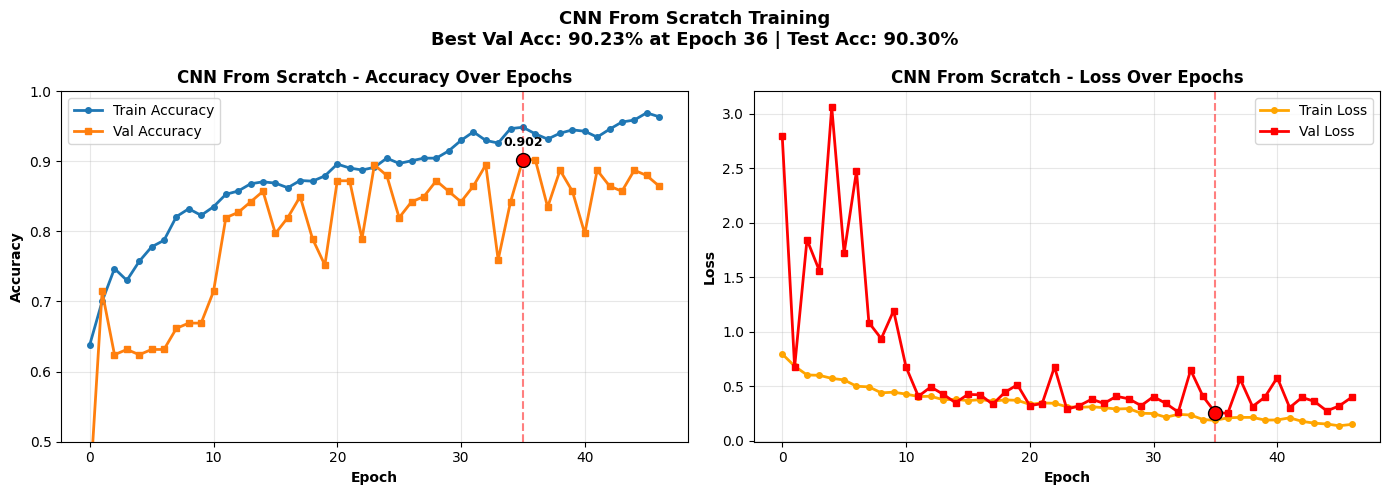

✅ Saved: /content/drive/MyDrive/jurnal YOLO/Machine Learning/hasil colab/cnn_scratch_confusion_matrix.png


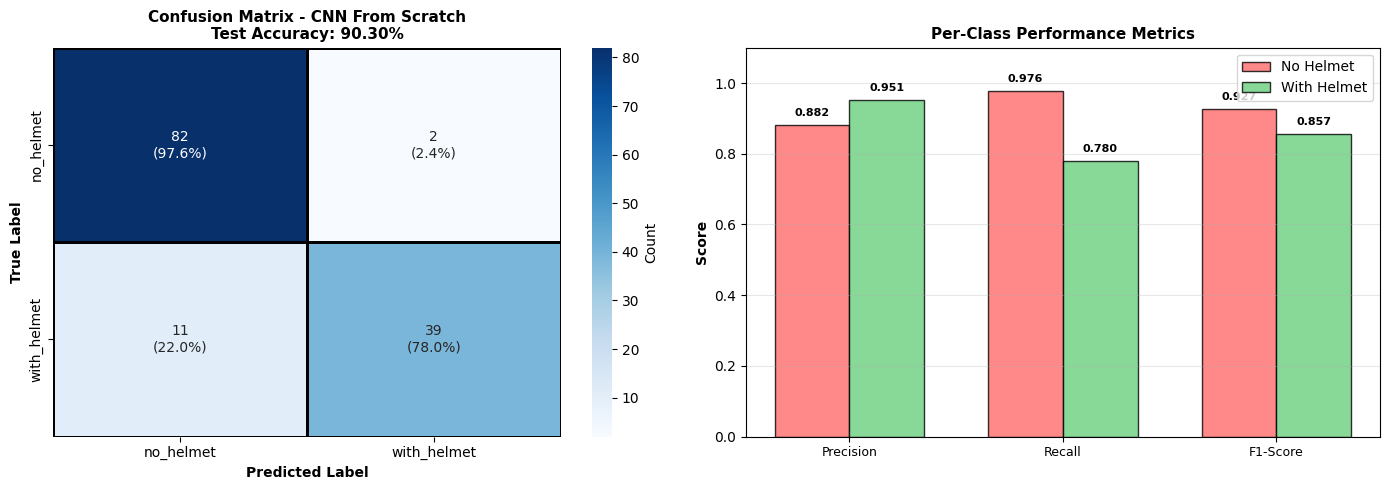

In [ ]:
# @title
print("\n🎨 Creating visualizations...")

# ==================== PLOT 1: TRAINING HISTORY ====================
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Best epoch
best_epoch = np.argmax(history.history['val_accuracy'])
best_val_acc = max(history.history['val_accuracy'])

# Accuracy plot
axes[0].plot(history.history['accuracy'], label='Train Accuracy', linewidth=2, marker='o', markersize=4)
axes[0].plot(history.history['val_accuracy'], label='Val Accuracy', linewidth=2, marker='s', markersize=4)
axes[0].set_title('CNN From Scratch - Accuracy Over Epochs', fontweight='bold', fontsize=12)
axes[0].set_xlabel('Epoch', fontweight='bold')
axes[0].set_ylabel('Accuracy', fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(alpha=0.3)
axes[0].set_ylim([0.5, 1.0])

# Highlight best epoch
axes[0].axvline(x=best_epoch, color='red', linestyle='--', alpha=0.5, label=f'Best: Epoch {best_epoch+1}')
axes[0].scatter(best_epoch, best_val_acc, color='red', s=100, zorder=5, edgecolors='black')
axes[0].text(best_epoch, best_val_acc + 0.02, f'{best_val_acc:.3f}', ha='center', fontweight='bold', fontsize=9)

# Loss plot
axes[1].plot(history.history['loss'], label='Train Loss', linewidth=2, marker='o', markersize=4, color='orange')
axes[1].plot(history.history['val_loss'], label='Val Loss', linewidth=2, marker='s', markersize=4, color='red')
axes[1].set_title('CNN From Scratch - Loss Over Epochs', fontweight='bold', fontsize=12)
axes[1].set_xlabel('Epoch', fontweight='bold')
axes[1].set_ylabel('Loss', fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(alpha=0.3)

axes[1].axvline(x=best_epoch, color='red', linestyle='--', alpha=0.5)
axes[1].scatter(best_epoch, history.history['val_loss'][best_epoch], color='red', s=100, zorder=5, edgecolors='black')

plt.suptitle(f'CNN From Scratch Training\nBest Val Acc: {best_val_acc:.2%} at Epoch {best_epoch+1} | Test Acc: {test_acc:.2%}',
             fontsize=13, fontweight='bold')
plt.tight_layout()

save_path_history = os.path.join(drive_save_path, 'cnn_scratch_training_history.png')
plt.savefig(save_path_history, dpi=300, bbox_inches='tight')
print(f"✅ Saved: {save_path_history}")
plt.show()

# ==================== PLOT 2: CONFUSION MATRIX & METRICS ====================
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Confusion matrix heatmap
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
annot_labels = np.array([[f'{cm[i,j]}\n({cm_percent[i,j]:.1%})'
                          for j in range(cm.shape[1])]
                         for i in range(cm.shape[0])])

sns.heatmap(cm, annot=annot_labels, fmt='', cmap='Blues',
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES,
            ax=axes[0], cbar_kws={'label': 'Count'}, linewidths=2, linecolor='black')
axes[0].set_title(f'Confusion Matrix - CNN From Scratch\nTest Accuracy: {test_acc:.2%}',
                  fontweight='bold', fontsize=11)
axes[0].set_ylabel('True Label', fontweight='bold')
axes[0].set_xlabel('Predicted Label', fontweight='bold')

# Per-class metrics bar chart
metrics_dict = {
    'No Helmet': [precision_no_helmet, recall_no_helmet, f1_no_helmet],
    'With Helmet': [precision_with_helmet, recall_with_helmet, f1_with_helmet]
}

x = np.arange(3)
width = 0.35

bars1 = axes[1].bar(x - width/2, metrics_dict['No Helmet'], width,
                    label='No Helmet', color='#ff6b6b', alpha=0.8, edgecolor='black')
bars2 = axes[1].bar(x + width/2, metrics_dict['With Helmet'], width,
                    label='With Helmet', color='#6bcf7f', alpha=0.8, edgecolor='black')

axes[1].set_ylabel('Score', fontweight='bold')
axes[1].set_title('Per-Class Performance Metrics', fontweight='bold', fontsize=11)
axes[1].set_xticks(x)
axes[1].set_xticklabels(['Precision', 'Recall', 'F1-Score'], fontsize=9)
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)
axes[1].set_ylim([0, 1.1])

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        axes[1].text(bar.get_x() + bar.get_width()/2., height + 0.02,
                    f'{height:.3f}', ha='center', va='bottom', fontsize=8, fontweight='bold')

plt.tight_layout()
save_path_cm = os.path.join(drive_save_path, 'cnn_scratch_confusion_matrix.png')
plt.savefig(save_path_cm, dpi=300, bbox_inches='tight')
print(f"✅ Saved: {save_path_cm}")
plt.show()

## COMPARISON: PART 1 & PART 2

📊 COMPARISON: TRADITIONAL ML (PART 1) vs CNN FROM SCRATCH (PART 2)

🏆 PART 1 - TRADITIONAL ML (Best Model):
   Algorithm: SVM-RBF
   Test Accuracy: 0.8284 (82.84%)
   Precision: 0.8269
   Recall: 0.8284
   F1-Score: 0.8272
   Training Time: 0.24s

🚀 PART 2 - CNN FROM SCRATCH (This Model):
   Architecture: Custom CNN (3 Conv Blocks)
   Test Accuracy: 0.9030 (90.30%)
   Precision: 0.9077
   Recall: 0.9030
   F1-Score: 0.9007
   Training Time: 272.26s

📈 IMPROVEMENT (Part 2 vs Part 1):
   Accuracy:  +7.46 percentage points
   Precision: +8.07 percentage points
   Recall:    +7.46 percentage points
   F1-Score:  +7.34 percentage points
✅ Saved: /content/drive/MyDrive/jurnal YOLO/Machine Learning/hasil colab/part1_vs_part2_comparison.png


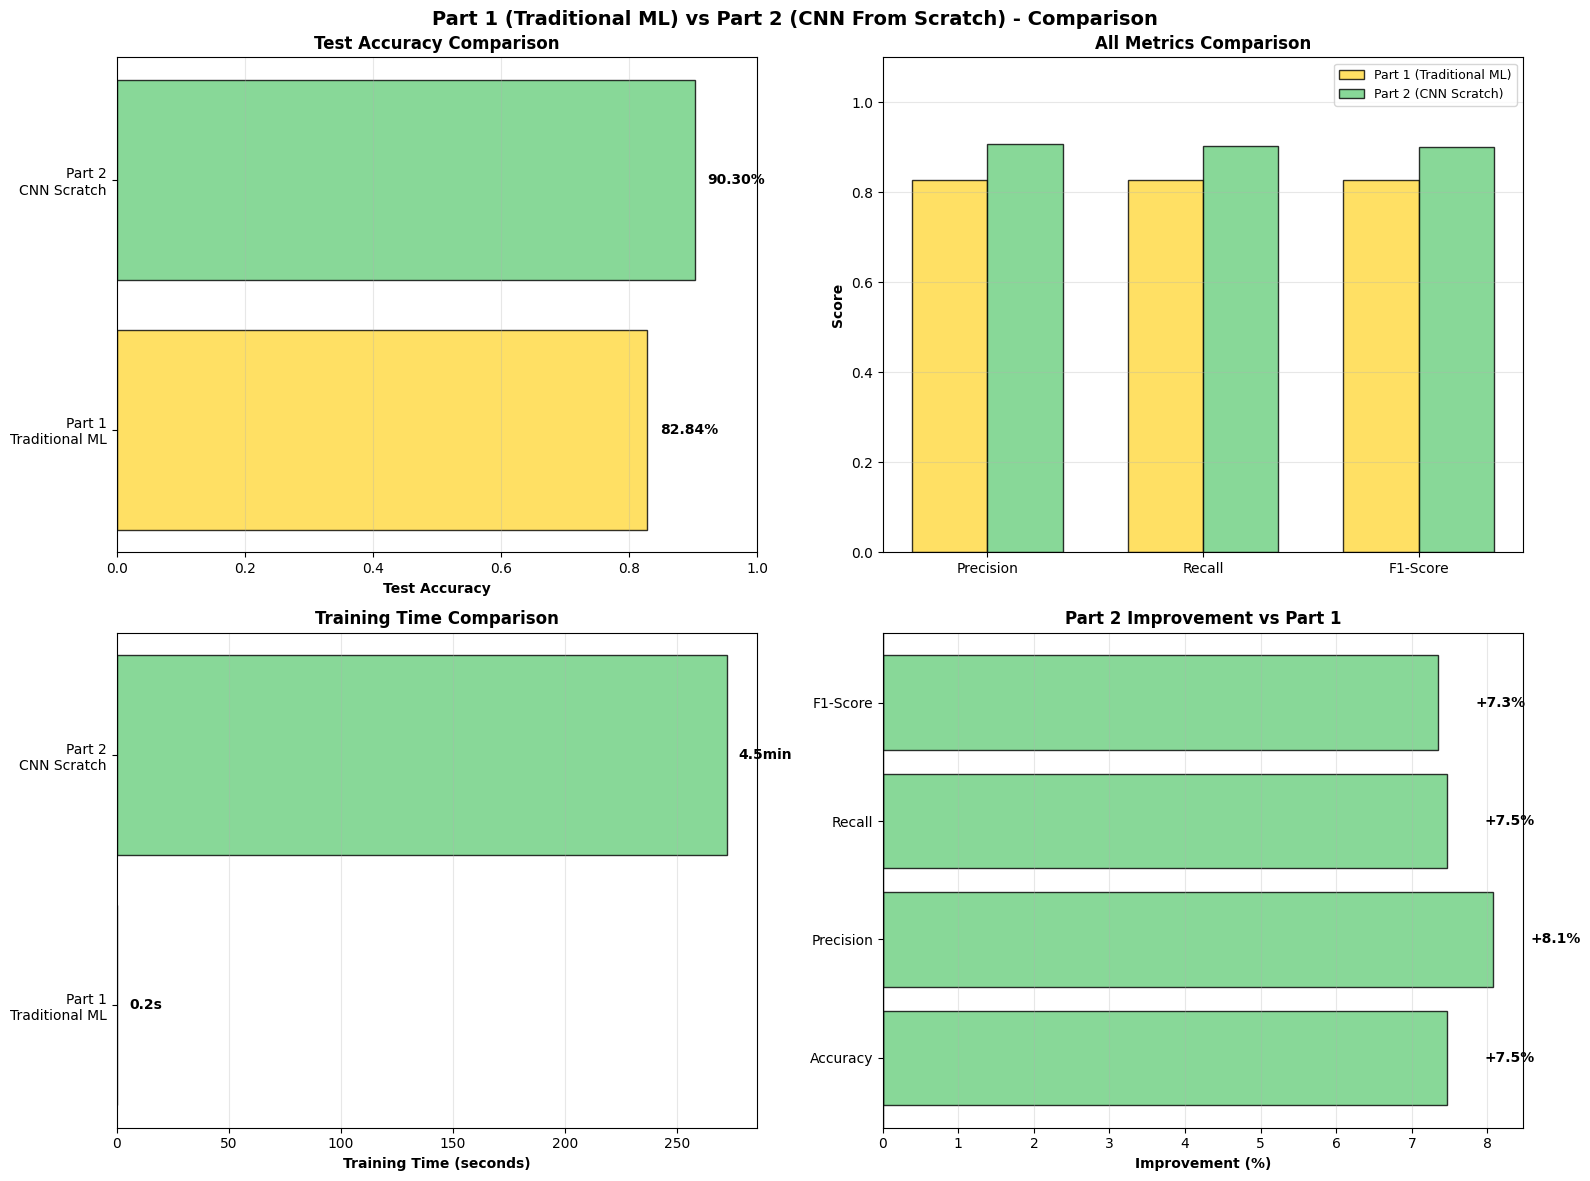

In [ ]:

print(f"📊 COMPARISON: TRADITIONAL ML (PART 1) vs CNN FROM SCRATCH (PART 2)")


# Get Part 1 best result
best_part1 = max(best_models_part1.values(), key=lambda x: x['test_acc'])

print(f"\n🏆 PART 1 - TRADITIONAL ML (Best Model):")
print(f"   Algorithm: {best_part1['algorithm']}")
print(f"   Test Accuracy: {best_part1['test_acc']:.4f} ({best_part1['test_acc']*100:.2f}%)")
print(f"   Precision: {best_part1.get('precision', 0):.4f}")
print(f"   Recall: {best_part1.get('recall', 0):.4f}")
print(f"   F1-Score: {best_part1.get('f1_score', 0):.4f}")
print(f"   Training Time: {best_part1['train_time']:.2f}s")

print(f"\n🚀 PART 2 - CNN FROM SCRATCH (This Model):")
print(f"   Architecture: Custom CNN (3 Conv Blocks)")
print(f"   Test Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)")
print(f"   Precision: {test_precision:.4f}")
print(f"   Recall: {test_recall:.4f}")
print(f"   F1-Score: {test_f1:.4f}")
print(f"   Training Time: {training_time:.2f}s")

# Calculate improvement
accuracy_improvement = (test_acc - best_part1['test_acc']) * 100
precision_improvement = (test_precision - best_part1.get('precision', 0)) * 100
recall_improvement = (test_recall - best_part1.get('recall', 0)) * 100
f1_improvement = (test_f1 - best_part1.get('f1_score', 0)) * 100

print(f"\n📈 IMPROVEMENT (Part 2 vs Part 1):")
print(f"   Accuracy:  {accuracy_improvement:+.2f} percentage points")
print(f"   Precision: {precision_improvement:+.2f} percentage points")
print(f"   Recall:    {recall_improvement:+.2f} percentage points")
print(f"   F1-Score:  {f1_improvement:+.2f} percentage points")

# Comparison visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Test Accuracy Comparison
methods = ['Part 1\nTraditional ML', 'Part 2\nCNN Scratch']
accuracies = [best_part1['test_acc'], test_acc]
colors_acc = ['#ffd93d', '#6bcf7f']

bars = axes[0, 0].barh(methods, accuracies, color=colors_acc, edgecolor='black', alpha=0.8)
axes[0, 0].set_xlabel('Test Accuracy', fontweight='bold')
axes[0, 0].set_title('Test Accuracy Comparison', fontweight='bold', fontsize=12)
axes[0, 0].grid(axis='x', alpha=0.3)
axes[0, 0].set_xlim([0, 1])

for i, (bar, val) in enumerate(zip(bars, accuracies)):
    axes[0, 0].text(val + 0.02, i, f'{val:.2%}', va='center', fontweight='bold', fontsize=10)

# 2. All Metrics Comparison
metrics_names = ['Precision', 'Recall', 'F1-Score']
part1_metrics = [
    best_part1.get('precision', 0),
    best_part1.get('recall', 0),
    best_part1.get('f1_score', 0)
]
part2_metrics = [test_precision, test_recall, test_f1]

x = np.arange(len(metrics_names))
width = 0.35

bars1 = axes[0, 1].bar(x - width/2, part1_metrics, width, label='Part 1 (Traditional ML)',
                       color='#ffd93d', alpha=0.8, edgecolor='black')
bars2 = axes[0, 1].bar(x + width/2, part2_metrics, width, label='Part 2 (CNN Scratch)',
                       color='#6bcf7f', alpha=0.8, edgecolor='black')

axes[0, 1].set_ylabel('Score', fontweight='bold')
axes[0, 1].set_title('All Metrics Comparison', fontweight='bold', fontsize=12)
axes[0, 1].set_xticks(x)
axes[0, 1].set_xticklabels(metrics_names, fontsize=10)
axes[0, 1].legend(fontsize=9)
axes[0, 1].grid(axis='y', alpha=0.3)
axes[0, 1].set_ylim([0, 1.1])

# 3. Training Time Comparison
train_times = [best_part1['train_time'], training_time]
bars = axes[1, 0].barh(methods, train_times, color=colors_acc, edgecolor='black', alpha=0.8)
axes[1, 0].set_xlabel('Training Time (seconds)', fontweight='bold')
axes[1, 0].set_title('Training Time Comparison', fontweight='bold', fontsize=12)
axes[1, 0].grid(axis='x', alpha=0.3)

for i, (bar, val) in enumerate(zip(bars, train_times)):
    time_str = f'{val:.1f}s' if val < 60 else f'{val/60:.1f}min'
    axes[1, 0].text(val + max(train_times)*0.02, i, time_str, va='center', fontweight='bold', fontsize=10)

# 4. Improvement Bar Chart
improvements = [accuracy_improvement, precision_improvement, recall_improvement, f1_improvement]
improvement_labels = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
colors_imp = ['#6bcf7f' if imp > 0 else '#ff6b6b' for imp in improvements]

bars = axes[1, 1].barh(improvement_labels, improvements, color=colors_imp, edgecolor='black', alpha=0.8)
axes[1, 1].set_xlabel('Improvement (%)', fontweight='bold')
axes[1, 1].set_title('Part 2 Improvement vs Part 1', fontweight='bold', fontsize=12)
axes[1, 1].axvline(x=0, color='black', linestyle='-', linewidth=1)
axes[1, 1].grid(axis='x', alpha=0.3)

for i, (bar, val) in enumerate(zip(bars, improvements)):
    axes[1, 1].text(val + (0.5 if val > 0 else -0.5), i,
                   f'{val:+.1f}%', va='center', ha='left' if val > 0 else 'right',
                   fontweight='bold', fontsize=10)

plt.suptitle('Part 1 (Traditional ML) vs Part 2 (CNN From Scratch) - Comparison',
             fontsize=14, fontweight='bold')
plt.tight_layout()

save_path_comparison = os.path.join(drive_save_path, 'part1_vs_part2_comparison.png')
plt.savefig(save_path_comparison, dpi=300, bbox_inches='tight')
print(f"✅ Saved: {save_path_comparison}")
plt.show()

## SAVE

In [ ]:
print("\n💾 Saving model and configuration...")

cnn_results = {
    'model': 'Custom CNN From Scratch',
    'strategy': 'Deep Learning (no pretrained weights)',
    'random_seed': CNN_CONFIG['random_seed'],
    'image_size': CNN_CONFIG['image_size'],
    'batch_size': CNN_CONFIG['batch_size'],
    'epochs_max': CNN_CONFIG['epochs'],
    'epochs_trained': len(history.history['loss']),
    'learning_rate': CNN_CONFIG['learning_rate'],
    'weight_decay': CNN_CONFIG['weight_decay'],
    'architecture': {
        'type': 'Convolutional Neural Network',
        'conv_blocks': len(CNN_CONFIG['conv_filters']),
        'filters_per_block': CNN_CONFIG['conv_filters'],
        'dense_layers': CNN_CONFIG['dense_units'],
        'total_parameters': int(total_params),
        'trainable_parameters': int(trainable_params),
        'trainable_percentage': 100.0,
        'pretrained': False,
        'transfer_learning': False,
        'use_batch_norm': CNN_CONFIG['use_batch_norm'],
        'dropout_rate': CNN_CONFIG['dropout_rate']
    },
    'training': {
        'training_time_seconds': float(training_time),
        'training_time_minutes': float(training_time / 60),
        'best_epoch': int(best_epoch + 1),
        'best_val_accuracy': float(best_val_acc)
    },
    'results': {
        'test_accuracy': float(test_acc),
        'test_precision': float(test_precision),
        'test_recall': float(test_recall),
        'test_f1': float(test_f1),
        'test_loss': float(test_loss)
    },
    'confusion_matrix': {
        'true_negatives': int(tn),
        'false_positives': int(fp),
        'false_negatives': int(fn),
        'true_positives': int(tp)
    },
    'per_class_metrics': {
        'no_helmet': {
            'precision': float(precision_no_helmet),
            'recall': float(recall_no_helmet),
            'f1_score': float(f1_no_helmet)
        },
        'with_helmet': {
            'precision': float(precision_with_helmet),
            'recall': float(recall_with_helmet),
            'f1_score': float(f1_with_helmet)
        }
    }
}

config_path = os.path.join(drive_save_path, 'config_cnn_scratch.json')
with open(config_path, 'w') as f:
    json.dump(cnn_results, f, indent=2)
print(f"   ✅ Configuration saved: config_cnn_scratch.json")

drive_model_path = os.path.join(drive_save_path, 'best_model_cnn_scratch.h5')
shutil.copy(checkpoint_path, drive_model_path)
print(f"   ✅ Model saved: best_model_cnn_scratch.h5")

history_save = {
    'accuracy': [float(x) for x in history.history['accuracy']],
    'val_accuracy': [float(x) for x in history.history['val_accuracy']],
    'loss': [float(x) for x in history.history['loss']],
    'val_loss': [float(x) for x in history.history['val_loss']]
}

history_path = os.path.join(drive_save_path, 'cnn_scratch_training_history.json')
with open(history_path, 'w') as f:
    json.dump(history_save, f, indent=2)
print(f"   ✅ Training history saved: cnn_scratch_training_history.json")



💾 Saving model and configuration...
   ✅ Configuration saved: config_cnn_scratch.json
   ✅ Model saved: best_model_cnn_scratch.h5
   ✅ Training history saved: cnn_scratch_training_history.json


##Summary

In [ ]:
print("\n" + "="*80)
print("🎉 PART 2: CNN FROM SCRATCH - COMPLETED!")
print("="*80)

print(f"\n📊 Model Information:")
print(f"   Architecture: Custom CNN ({len(CNN_CONFIG['conv_filters'])} Conv Blocks)")
print(f"   Strategy: Deep Learning from scratch (NO pretrained)")
print(f"   Parameters: {total_params:,} (all trainable)")

print(f"\n⏱️  Training Information:")
print(f"   Total time: {training_time/60:.2f} minutes")
print(f"   Epochs: {len(history.history['loss'])} / {CNN_CONFIG['epochs']}")
print(f"   Best epoch: {best_epoch + 1}")

print(f"\n📈 Test Performance:")
print(f"   Accuracy:  {test_acc:.4f} ({test_acc*100:.2f}%)")
print(f"   Precision: {test_precision:.4f}")
print(f"   Recall:    {test_recall:.4f}")
print(f"   F1-Score:  {test_f1:.4f}")

print(f"\n✅ All Part 2 results saved to: {drive_save_path}")
print(f"✅ Ready to proceed to Part 3!")
print(f"\n{'='*80}")
print(f"END OF PART 2")
print(f"{'='*80}")


🎉 PART 2: CNN FROM SCRATCH - COMPLETED!

📊 Model Information:
   Architecture: Custom CNN (4 Conv Blocks)
   Strategy: Deep Learning from scratch (NO pretrained)
   Parameters: 1,275,042 (all trainable)

⏱️  Training Information:
   Total time: 4.54 minutes
   Epochs: 47 / 50
   Best epoch: 36

📈 Test Performance:
   Accuracy:  0.9030 (90.30%)
   Precision: 0.9077
   Recall:    0.9030
   F1-Score:  0.9007

✅ All Part 2 results saved to: /content/drive/MyDrive/jurnal YOLO/Machine Learning/hasil colab
✅ Ready to proceed to Part 3!

END OF PART 2


## PREPARE VARIABLES FOR PART 3

In [ ]:
print(f"\n{'='*80}")
print(f"🔗 PREPARING VARIABLES FOR PART 3 (VISION TRANSFORMER)")
print(f"{'='*80}")

# Backup data for Part 3 (re-load original to ensure integrity)
cropped_images_reloaded, labels_reloaded = load_cropped_data(dataset.location)

cropped_images_for_part3 = cropped_images_reloaded.copy()
labels_for_part3 = labels_reloaded.copy()

# Store Part 2 results
best_model_part2 = {
    'model_name': 'CNN From Scratch',
    'test_acc': test_acc,
    'test_precision': test_precision,
    'test_recall': test_recall,
    'test_f1': test_f1,
    'train_time': training_time,
    'epochs_trained': len(history.history['loss']),
    'total_params': model.count_params()
}

print(f"\n✅ Variables prepared for Part 3:")
print(f"   cropped_images_for_part3: {len(cropped_images_for_part3)} images")
print(f"   labels_for_part3: {len(labels_for_part3)} labels")
print(f"   Distribution: {np.bincount(labels_for_part3).tolist()}")
print(f"   CLASS_NAMES: {CLASS_NAMES}")
print(f"   best_model_part2: stored ✓")
print(f"   drive_save_path: {drive_save_path}")


🔗 PREPARING VARIABLES FOR PART 3 (VISION TRANSFORMER)

📦 Loading and cropping bboxes...
✅ Processed: 1334 bboxes
   Distribution: [832, 502] (0=no_helmet, 1=with_helmet)

✅ Variables prepared for Part 3:
   cropped_images_for_part3: 1334 images
   labels_for_part3: 1334 labels
   Distribution: [832, 502]
   CLASS_NAMES: ['no_helmet', 'with_helmet']
   best_model_part2: stored ✓
   drive_save_path: /content/drive/MyDrive/jurnal YOLO/Machine Learning/hasil colab


# PART 3: VISION TRANSFORMER (ViT) + LoRA

In [ ]:
# @title
# Re-load original cropped images and labels to ensure integrity
cropped_images_reloaded, labels_reloaded = load_cropped_data(dataset.location)

# Backup data for Part 3
cropped_images_for_part3 = cropped_images_reloaded.copy()
labels_for_part3 = labels_reloaded.copy()


print(f"\n✅ Variables prepared for Part 3:")
print(f"   cropped_images_for_part: {len(cropped_images_for_part3)} images")
print(f"   labels_for_part: {len(labels_for_part3)} labels")
print(f"   Distribution: {np.bincount(labels_for_part3).tolist()}")
print(f"   CLASS_NAMES: {CLASS_NAMES}")
print(f"   drive_save_path: {drive_save_path}")


📦 Loading and cropping bboxes...
✅ Processed: 1334 bboxes
   Distribution: [832, 502] (0=no_helmet, 1=with_helmet)

✅ Variables prepared for Part 3:
   cropped_images_for_part: 1334 images
   labels_for_part: 1334 labels
   Distribution: [832, 502]
   CLASS_NAMES: ['no_helmet', 'with_helmet']
   drive_save_path: /content/drive/MyDrive/jurnal YOLO/Machine Learning/hasil colab


## INSTALL & IMPORT LIBRARIES

In [ ]:
# @title
print("\n📦 Installing additional libraries for Vision Transformer...")

# Install PyTorch dan Transformers
!pip install -q torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install -q transformers pillow datasets accelerate

print("✅ Libraries installed successfully!")

import os
import time
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

from transformers import ViTForImageClassification, ViTImageProcessor
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)

print("✅ All libraries imported successfully!")


def set_all_seeds(seed=42):
    """Set all random seeds for reproducibility"""
    import random
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)

    print(f"\n🎲 All seeds set to: {seed}")
    print("   ✓ Python random")
    print("   ✓ NumPy")
    print("   ✓ PyTorch (CPU + GPU)")
    print("   ✓ CUDNN deterministic")
    print("   ✓ Results will be FULLY reproducible!")

set_all_seeds(42)

# Check GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\n✅ Device: {device}")
if torch.cuda.is_available():
    print(f"   GPU: {torch.cuda.get_device_name(0)}")
    print(f"   Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")


📦 Installing additional libraries for Vision Transformer...
✅ Libraries installed successfully!
✅ All libraries imported successfully!

🎲 All seeds set to: 42
   ✓ Python random
   ✓ NumPy
   ✓ PyTorch (CPU + GPU)
   ✓ CUDNN deterministic
   ✓ Results will be FULLY reproducible!

✅ Device: cuda
   GPU: Tesla T4
   Memory: 15.83 GB


 VALIDATE VARIABLES FROM PART 1 / 2

In [ ]:
print("\n🔍 Validating variables from Part 2...")

required_vars = {
    'cropped_images_for_part3': 'Cropped images dataset',
    'labels_for_part3': 'Full labels array',
    'CLASS_NAMES': 'Class names list',
    'best_models_part1': 'Best models from Part 1',
    'drive_save_path': 'Google Drive save path'
}

missing = []
for var_name, description in required_vars.items():
    if var_name not in globals():
        missing.append(f"❌ {var_name} ({description})")
    else:
        print(f"✅ {var_name} - OK")

if missing:
    print("\n⚠️ ERROR: Missing variables from Part 1:")
    for m in missing:
        print(f"   {m}")
    raise RuntimeError("Please run Part 1 first!")

# Use protected variables
cropped_images = cropped_images_for_part3
labels = labels_for_part3

print(f"\n✅ All variables ready!")
print(f"   Total images: {len(cropped_images)}")
print(f"   Total labels: {len(labels)}")
print(f"   Distribution: {np.bincount(labels).tolist()}")
print(f"   Class names: {CLASS_NAMES}")


🔍 Validating variables from Part 2...
✅ cropped_images_for_part3 - OK
✅ labels_for_part3 - OK
✅ CLASS_NAMES - OK
✅ best_models_part1 - OK
✅ drive_save_path - OK

✅ All variables ready!
   Total images: 1334
   Total labels: 1334
   Distribution: [832, 502]
   Class names: ['no_helmet', 'with_helmet']


## CONFIGURATION

In [ ]:
VIT_CONFIG = {
    'model_name': 'google/vit-base-patch16-224',  # ViT-Base, patch size 16x16
    'image_size': 224,  # ViT standard input size
    'batch_size': 16,
    'epochs': 30,
    'learning_rate': 2e-4,
    'weight_decay': 0.01,
    'num_classes': 2,
    'patience_early_stop': 10,
    'patience_reduce_lr': 5,
    'reduce_lr_factor': 0.5,
    'random_seed': 42,
    'device': device
}

print(f"🚀 PART 3: VISION TRANSFORMER (ViT) CONFIGURATION")
for key, value in VIT_CONFIG.items():
    print(f"   {key}: {value}")

🚀 PART 3: VISION TRANSFORMER (ViT) CONFIGURATION
   model_name: google/vit-base-patch16-224
   image_size: 224
   batch_size: 16
   epochs: 30
   learning_rate: 0.0002
   weight_decay: 0.01
   num_classes: 2
   patience_early_stop: 10
   patience_reduce_lr: 5
   reduce_lr_factor: 0.5
   random_seed: 42
   device: cuda


## CUSTOM DATASET CLASS

In [ ]:
class HelmetDataset(Dataset):
    """Custom Dataset for Helmet Detection with Vision Transformer"""

    def __init__(self, images, labels, processor, augment=False):
        """
        Args:
            images: numpy array of BGR images
            labels: numpy array of labels (0=no_helmet, 1=with_helmet)
            processor: ViT image processor
            augment: whether to apply augmentation
        """
        self.images = images
        self.labels = labels
        self.processor = processor
        self.augment = augment

        # Augmentation transforms (similar to Part 1)
        if augment:
            self.transform = transforms.Compose([
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomRotation(degrees=15),
                transforms.ColorJitter(
                    brightness=0.2,
                    contrast=0.2,
                    saturation=0.2,
                    hue=0.1
                ),
                transforms.RandomAffine(
                    degrees=0,
                    translate=(0.1, 0.1),
                    scale=(0.9, 1.1)
                ),
            ])
        else:
            self.transform = None

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Convert BGR to RGB and numpy to PIL
        image = self.images[idx]
        image = image[:, :, ::-1]  # BGR to RGB
        image = Image.fromarray(image)

        # Apply augmentation if enabled
        if self.transform:
            image = self.transform(image)

        # Process image using ViT processor
        inputs = self.processor(images=image, return_tensors="pt")
        pixel_values = inputs['pixel_values'].squeeze(0)

        label = torch.tensor(self.labels[idx], dtype=torch.long)

        return {
            'pixel_values': pixel_values,
            'labels': label
        }


## PREPARE DATA

In [ ]:
print("\n📊 Preparing data for Vision Transformer...")

# Convert images to numpy array
X_images = np.array(cropped_images)
y_labels = np.array(labels)

print(f"\n   Original images shape: {X_images.shape}")
print(f"   Labels shape: {y_labels.shape}")
print(f"   Label distribution: {np.bincount(y_labels).tolist()}")

# Split data: 80% train, 10% val, 10% test (same as Part 1 & 2)
X_train, X_temp, y_train, y_temp = train_test_split(
    X_images, y_labels, test_size=0.2, random_state=42, stratify=y_labels
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"\n✅ Data split (seed=42, stratified):")
print(f"   Train: {len(X_train)} samples - {np.bincount(y_train).tolist()}")
print(f"   Val:   {len(X_val)} samples - {np.bincount(y_val).tolist()}")
print(f"   Test:  {len(X_test)} samples - {np.bincount(y_test).tolist()}")

# Calculate class weights for imbalanced data
class_counts = np.bincount(y_train)
total_samples = len(y_train)
class_weights = torch.FloatTensor([
    total_samples / (len(class_counts) * class_counts[i])
    for i in range(len(class_counts))
]).to(device)

print(f"\n⚖️ Class weights (for imbalance): {class_weights.cpu().numpy().tolist()}")


📊 Preparing data for Vision Transformer...

   Original images shape: (1334, 128, 128, 3)
   Labels shape: (1334,)
   Label distribution: [832, 502]

✅ Data split (seed=42, stratified):
   Train: 1067 samples - [665, 402]
   Val:   133 samples - [83, 50]
   Test:  134 samples - [84, 50]

⚖️ Class weights (for imbalance): [0.8022556304931641, 1.327114462852478]


## LOAD VISION TRANSFORMER MODEL & PROCESSOR


In [ ]:
print(f"\n{'='*60}")
print(f"🔨 BUILDING VISION TRANSFORMER MODEL")
print(f"{'='*60}")

# Load ViT processor (for image preprocessing)
print(f"\n📥 Loading ViT processor...")
processor = ViTImageProcessor.from_pretrained(VIT_CONFIG['model_name'])
print(f"✅ Processor loaded: {VIT_CONFIG['model_name']}")

# Load pretrained ViT model
print(f"\n📥 Loading pretrained Vision Transformer...")
model = ViTForImageClassification.from_pretrained(
    VIT_CONFIG['model_name'],
    num_labels=VIT_CONFIG['num_classes'],
    ignore_mismatched_sizes=True
)

print(f"\n✅ Base Model Loaded:")
print(f"   Architecture: Vision Transformer (ViT-Base/16)")
print(f"   Source: ImageNet-21k pretrained (14M images, 21k classes)")
print(f"   Patch size: 16x16")
print(f"   Hidden size: 768")
print(f"   Num attention heads: 12")
print(f"   Num hidden layers: 12")

# LoRA Strategy: Freeze transformer encoder, only train classifier head
print(f"\n🔒 Applying LoRA Strategy...")
total_params = sum(p.numel() for p in model.parameters())

# Freeze all ViT encoder layers (transformer blocks)
for param in model.vit.parameters():
    param.requires_grad = False

# Unfreeze classifier head
for param in model.classifier.parameters():
    param.requires_grad = True

trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
frozen_params = total_params - trainable_params

print(f"\n📊 Parameter Breakdown:")
print(f"   Total parameters:       {total_params:,}")
print(f"   Frozen (ViT encoder):   {frozen_params:,} ({frozen_params/total_params*100:.2f}%)")
print(f"   Trainable (classifier): {trainable_params:,} ({trainable_params/total_params*100:.2f}%)")
print(f"\n   ✅ LoRA Efficiency: Only {trainable_params/total_params*100:.1f}% parameters trained!")
print(f"   🎯 This is {total_params/trainable_params:.1f}x more efficient than full fine-tuning")

# Move model to device
model = model.to(device)


🔨 BUILDING VISION TRANSFORMER MODEL

📥 Loading ViT processor...



The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

✅ Processor loaded: google/vit-base-patch16-224

📥 Loading pretrained Vision Transformer...


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



✅ Base Model Loaded:
   Architecture: Vision Transformer (ViT-Base/16)
   Source: ImageNet-21k pretrained (14M images, 21k classes)
   Patch size: 16x16
   Hidden size: 768
   Num attention heads: 12
   Num hidden layers: 12

🔒 Applying LoRA Strategy...

📊 Parameter Breakdown:
   Total parameters:       85,800,194
   Frozen (ViT encoder):   85,798,656 (100.00%)
   Trainable (classifier): 1,538 (0.00%)

   ✅ LoRA Efficiency: Only 0.0% parameters trained!
   🎯 This is 55786.9x more efficient than full fine-tuning


## CREATE DATASETS & DATALOADERS


In [ ]:
print("\n📦 Creating datasets and dataloaders...")

# Create datasets with augmentation for training
train_dataset = HelmetDataset(X_train, y_train, processor, augment=True)
val_dataset = HelmetDataset(X_val, y_val, processor, augment=False)
test_dataset = HelmetDataset(X_test, y_test, processor, augment=False)

# Create dataloaders
train_loader = DataLoader(
    train_dataset,
    batch_size=VIT_CONFIG['batch_size'],
    shuffle=True,
    num_workers=2,
    pin_memory=True if torch.cuda.is_available() else False
)

val_loader = DataLoader(
    val_dataset,
    batch_size=VIT_CONFIG['batch_size'],
    shuffle=False,
    num_workers=2,
    pin_memory=True if torch.cuda.is_available() else False
)

test_loader = DataLoader(
    test_dataset,
    batch_size=VIT_CONFIG['batch_size'],
    shuffle=False,
    num_workers=2,
    pin_memory=True if torch.cuda.is_available() else False
)

print(f"✅ Dataloaders created:")
print(f"   Train batches: {len(train_loader)}")
print(f"   Val batches:   {len(val_loader)}")
print(f"   Test batches:  {len(test_loader)}")
print(f"   Augmentation: Train=ON, Val/Test=OFF")


📦 Creating datasets and dataloaders...
✅ Dataloaders created:
   Train batches: 67
   Val batches:   9
   Test batches:  9
   Augmentation: Train=ON, Val/Test=OFF


## SETUP OPTIMIZER, LOSS, SCHEDULER


In [ ]:
print("\n⚙️ Setting up optimizer and scheduler...")

# Optimizer (AdamW with weight decay)
optimizer = optim.AdamW(
    model.parameters(),
    lr=VIT_CONFIG['learning_rate'],
    weight_decay=VIT_CONFIG['weight_decay']
)

# Loss function with class weights
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Learning rate scheduler (ReduceLROnPlateau)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=VIT_CONFIG['reduce_lr_factor'],
    patience=VIT_CONFIG['patience_reduce_lr'],
    min_lr=1e-7
)

print(f"✅ Training setup complete:")
print(f"   Optimizer: AdamW (lr={VIT_CONFIG['learning_rate']}, wd={VIT_CONFIG['weight_decay']})")
print(f"   Loss: CrossEntropyLoss with class weights")
print(f"   Scheduler: ReduceLROnPlateau (factor={VIT_CONFIG['reduce_lr_factor']}, patience={VIT_CONFIG['patience_reduce_lr']})")



⚙️ Setting up optimizer and scheduler...
✅ Training setup complete:
   Optimizer: AdamW (lr=0.0002, wd=0.01)
   Loss: CrossEntropyLoss with class weights
   Scheduler: ReduceLROnPlateau (factor=0.5, patience=5)


## TRAINING LOOP


In [ ]:

print(f"🎯 STARTING TRAINING - VISION TRANSFORMER")

print(f"   Max epochs: {VIT_CONFIG['epochs']}")
print(f"   Early stopping patience: {VIT_CONFIG['patience_early_stop']}")
print(f"   Device: {device}")


# Training history
history = {
    'train_loss': [], 'train_acc': [],
    'val_loss': [], 'val_acc': [],
    'lr': []
}

# Early stopping variables
best_val_acc = 0.0
best_val_loss = float('inf')
patience_counter = 0
best_epoch = 0

# Save path for best model
best_model_path = 'best_vit_model.pth'

# Start training
start_time = time.time()

for epoch in range(VIT_CONFIG['epochs']):
    epoch_start = time.time()

    # ==================== TRAINING PHASE ====================
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    for batch_idx, batch in enumerate(train_loader):
        pixel_values = batch['pixel_values'].to(device)
        labels = batch['labels'].to(device)

        # Forward pass
        optimizer.zero_grad()
        outputs = model(pixel_values=pixel_values, labels=labels)
        loss = outputs.loss

        # Backward pass
        loss.backward()
        optimizer.step()

        # Statistics
        train_loss += loss.item()
        _, predicted = torch.max(outputs.logits, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    train_loss /= len(train_loader)
    train_acc = train_correct / train_total

    # ==================== VALIDATION PHASE ====================
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for batch in val_loader:
            pixel_values = batch['pixel_values'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(pixel_values=pixel_values, labels=labels)
            loss = outputs.loss

            val_loss += loss.item()
            _, predicted = torch.max(outputs.logits, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_loss /= len(val_loader)
    val_acc = val_correct / val_total

    # Update learning rate scheduler
    old_lr = optimizer.param_groups[0]['lr']
    scheduler.step(val_loss)
    current_lr = optimizer.param_groups[0]['lr']

    # Check if LR was reduced
    if current_lr < old_lr:
        print(f"   📉 Learning rate reduced: {old_lr:.2e} → {current_lr:.2e}")

    # Save history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['lr'].append(current_lr)

    # Calculate epoch time
    epoch_time = time.time() - epoch_start

    # Print progress
    print(f"Epoch {epoch+1}/{VIT_CONFIG['epochs']} ({epoch_time:.1f}s) | "
          f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f} | "
          f"LR: {current_lr:.2e}")

    # ==================== SAVE BEST MODEL ====================
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_val_loss = val_loss
        best_epoch = epoch + 1
        patience_counter = 0

        # Save model
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': val_acc,
            'val_loss': val_loss,
        }, best_model_path)

        print(f"   ✅ Best model saved! Val Acc: {val_acc:.4f}")
    else:
        patience_counter += 1

    # ==================== EARLY STOPPING ====================
    if patience_counter >= VIT_CONFIG['patience_early_stop']:
        print(f"\n⚠️ Early stopping triggered! No improvement for {VIT_CONFIG['patience_early_stop']} epochs.")
        print(f"   Best Val Acc: {best_val_acc:.4f} at Epoch {best_epoch}")
        break

training_time = time.time() - start_time


print(f"✅ TRAINING COMPLETED!")
print(f"   Total time: {training_time/60:.2f} minutes ({training_time:.0f} seconds)")
print(f"   Epochs completed: {len(history['train_loss'])}")
print(f"   Best val accuracy: {best_val_acc:.4f} ({best_val_acc*100:.2f}%) at Epoch {best_epoch}")
print(f"   Final train accuracy: {history['train_acc'][-1]:.4f}")
print(f"   Final val accuracy: {history['val_acc'][-1]:.4f}")
print(f"   Average time per epoch: {training_time/len(history['train_loss']):.2f}s")

🎯 STARTING TRAINING - VISION TRANSFORMER
   Max epochs: 30
   Early stopping patience: 10
   Device: cuda
Epoch 1/30 (22.1s) | Train Loss: 0.4230, Acc: 0.8304 | Val Loss: 0.3128, Acc: 0.9248 | LR: 2.00e-04
   ✅ Best model saved! Val Acc: 0.9248
Epoch 2/30 (16.9s) | Train Loss: 0.2995, Acc: 0.8772 | Val Loss: 0.2536, Acc: 0.9398 | LR: 2.00e-04
   ✅ Best model saved! Val Acc: 0.9398
Epoch 3/30 (16.1s) | Train Loss: 0.2570, Acc: 0.9044 | Val Loss: 0.2218, Acc: 0.9474 | LR: 2.00e-04
   ✅ Best model saved! Val Acc: 0.9474
Epoch 4/30 (15.0s) | Train Loss: 0.2259, Acc: 0.9082 | Val Loss: 0.2092, Acc: 0.9549 | LR: 2.00e-04
   ✅ Best model saved! Val Acc: 0.9549
Epoch 5/30 (15.2s) | Train Loss: 0.2090, Acc: 0.9344 | Val Loss: 0.2038, Acc: 0.9624 | LR: 2.00e-04
   ✅ Best model saved! Val Acc: 0.9624
Epoch 6/30 (16.8s) | Train Loss: 0.1917, Acc: 0.9306 | Val Loss: 0.1980, Acc: 0.9474 | LR: 2.00e-04
Epoch 7/30 (16.3s) | Train Loss: 0.1854, Acc: 0.9419 | Val Loss: 0.1954, Acc: 0.9624 | LR: 2.00e-04

## LOAD BEST MODEL & EVALUATE

In [ ]:

print(f"📊 EVALUATION ON TEST SET")

# Load best model
print(f"\n📥 Loading best model from: {best_model_path}")
checkpoint = torch.load(best_model_path)
model.load_state_dict(checkpoint['model_state_dict'])
print(f"✅ Loaded model from Epoch {checkpoint['epoch']} (Val Acc: {checkpoint['val_acc']:.4f})")

# Evaluate on test set
print(f"\n🧪 Testing on {len(X_test)} samples...")
model.eval()

all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for batch in test_loader:
        pixel_values = batch['pixel_values'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(pixel_values=pixel_values)
        logits = outputs.logits
        probs = torch.softmax(logits, dim=1)
        _, predicted = torch.max(logits, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
all_probs = np.array(all_probs)

# Calculate metrics
test_acc = accuracy_score(all_labels, all_preds)
test_precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
test_recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
test_f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)
cm = confusion_matrix(all_labels, all_preds)

print(f"\n{'='*60}")
print(f"📈 VISION TRANSFORMER TEST RESULTS")
print(f"{'='*60}")
print(f"   Accuracy:  {test_acc:.4f} ({test_acc*100:.2f}%)")
print(f"   Precision: {test_precision:.4f}")
print(f"   Recall:    {test_recall:.4f}")
print(f"   F1-Score:  {test_f1:.4f}")

# Confusion matrix breakdown
tn, fp, fn, tp = cm.ravel()

print(f"\n📊 Confusion Matrix:")
print(f"                 Predicted")
print(f"              No    With")
print(f"   Actual No  {tn:3d}   {fp:3d}")
print(f"         With {fn:3d}   {tp:3d}")

print(f"\n🎯 Breakdown:")
print(f"   True Negatives (correct no_helmet):   {tn}")
print(f"   False Positives (wrong with_helmet):  {fp}")
print(f"   False Negatives (wrong no_helmet):    {fn} ⚠️ Critical!")
print(f"   True Positives (correct with_helmet): {tp}")

# Per-class metrics
precision_no_helmet = tn / (tn + fn) if (tn + fn) > 0 else 0
recall_no_helmet = tn / (tn + fp) if (tn + fp) > 0 else 0
f1_no_helmet = 2 * precision_no_helmet * recall_no_helmet / (precision_no_helmet + recall_no_helmet) if (precision_no_helmet + recall_no_helmet) > 0 else 0

precision_with_helmet = tp / (tp + fp) if (tp + fp) > 0 else 0
recall_with_helmet = tp / (tp + fn) if (tp + fn) > 0 else 0
f1_with_helmet = 2 * precision_with_helmet * recall_with_helmet / (precision_with_helmet + recall_with_helmet) if (precision_with_helmet + recall_with_helmet) > 0 else 0

print(f"\n📊 Per-Class Metrics:")
print(f"\n   NO HELMET (Class 0):")
print(f"      Precision: {precision_no_helmet:.4f}")
print(f"      Recall:    {recall_no_helmet:.4f}")
print(f"      F1-Score:  {f1_no_helmet:.4f}")

print(f"\n   WITH HELMET (Class 1):")
print(f"      Precision: {precision_with_helmet:.4f}")
print(f"      Recall:    {recall_with_helmet:.4f}")
print(f"      F1-Score:  {f1_with_helmet:.4f}")

print(f"\n📋 Detailed Classification Report:")
print(classification_report(all_labels, all_preds, target_names=CLASS_NAMES, zero_division=0))

📊 EVALUATION ON TEST SET

📥 Loading best model from: best_vit_model.pth
✅ Loaded model from Epoch 5 (Val Acc: 0.9624)

🧪 Testing on 134 samples...

📈 VISION TRANSFORMER TEST RESULTS
   Accuracy:  0.9478 (94.78%)
   Precision: 0.9493
   Recall:    0.9478
   F1-Score:  0.9480

📊 Confusion Matrix:
                 Predicted
              No    With
   Actual No   79     5
         With   2    48

🎯 Breakdown:
   True Negatives (correct no_helmet):   79
   False Positives (wrong with_helmet):  5
   False Negatives (wrong no_helmet):    2 ⚠️ Critical!
   True Positives (correct with_helmet): 48

📊 Per-Class Metrics:

   NO HELMET (Class 0):
      Precision: 0.9753
      Recall:    0.9405
      F1-Score:  0.9576

   WITH HELMET (Class 1):
      Precision: 0.9057
      Recall:    0.9600
      F1-Score:  0.9320

📋 Detailed Classification Report:
              precision    recall  f1-score   support

   no_helmet       0.98      0.94      0.96        84
 with_helmet       0.91      0.96      0.

## VISUALIZATIONS



🎨 Creating visualizations...
✅ Saved: /content/drive/MyDrive/jurnal YOLO/Machine Learning/hasil colab/vit_training_history.png


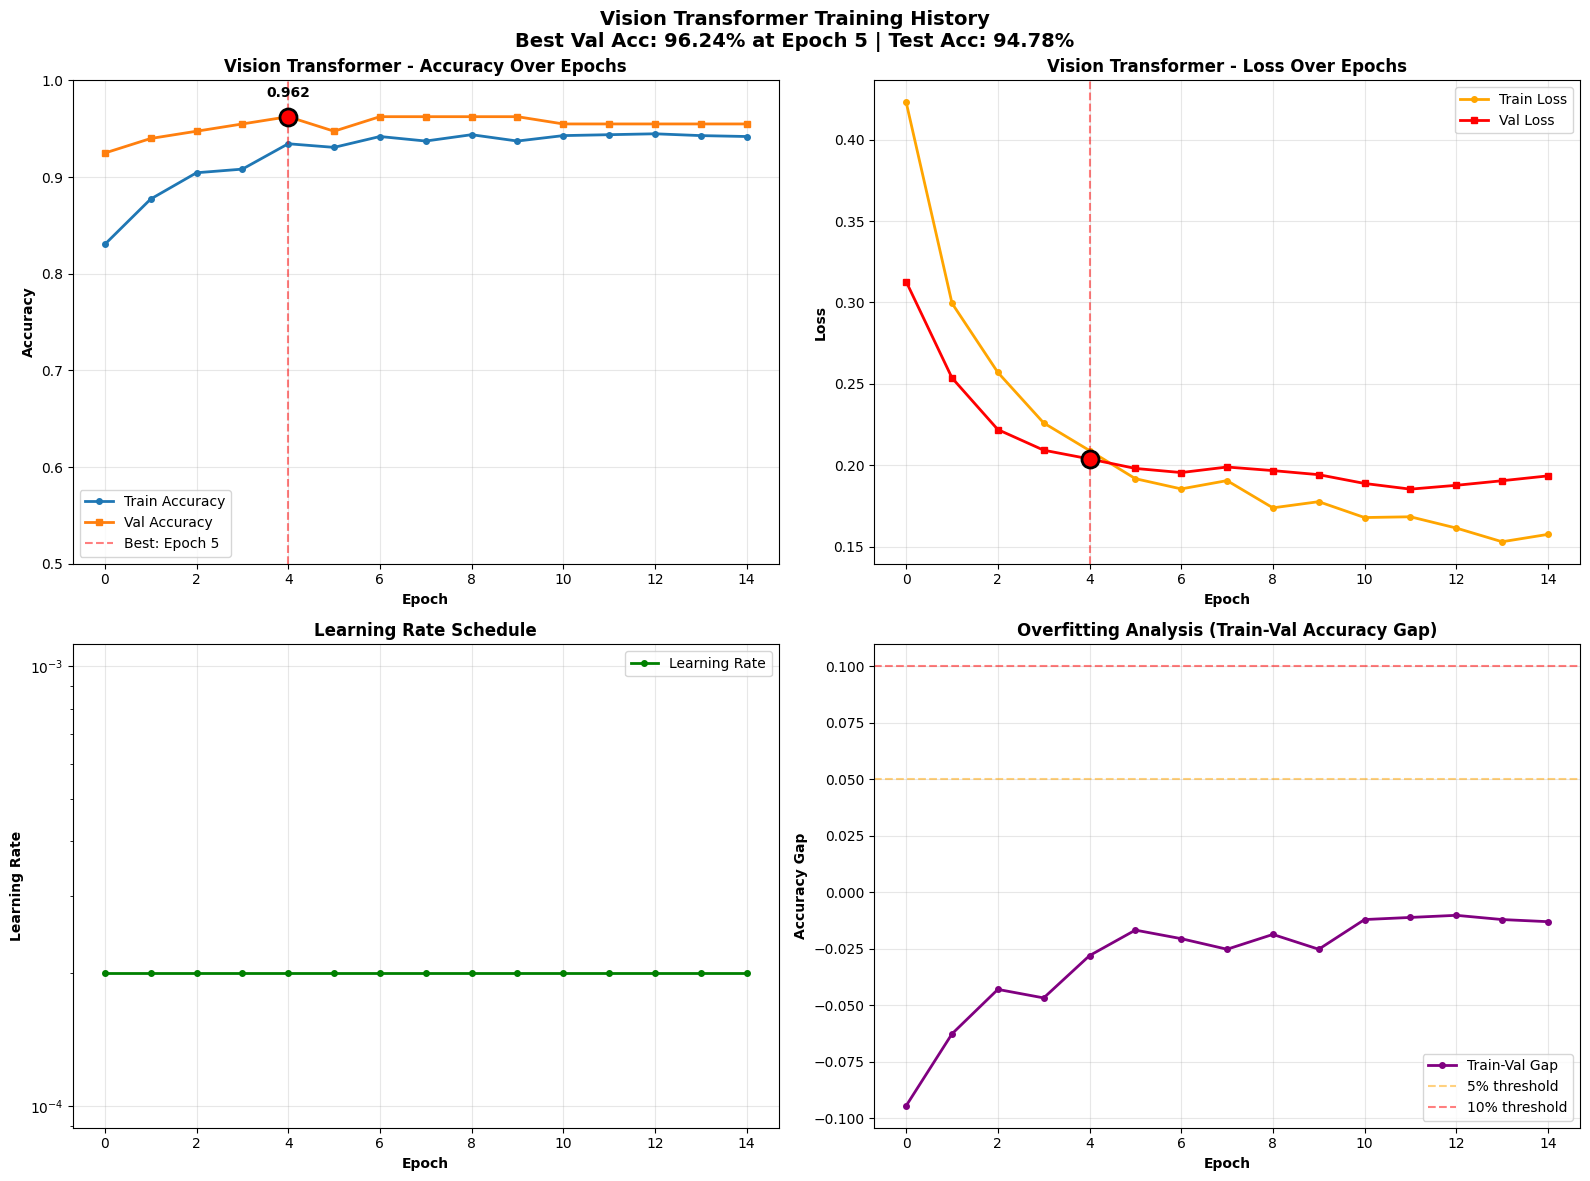

✅ Saved: /content/drive/MyDrive/jurnal YOLO/Machine Learning/hasil colab/vit_confusion_matrix.png


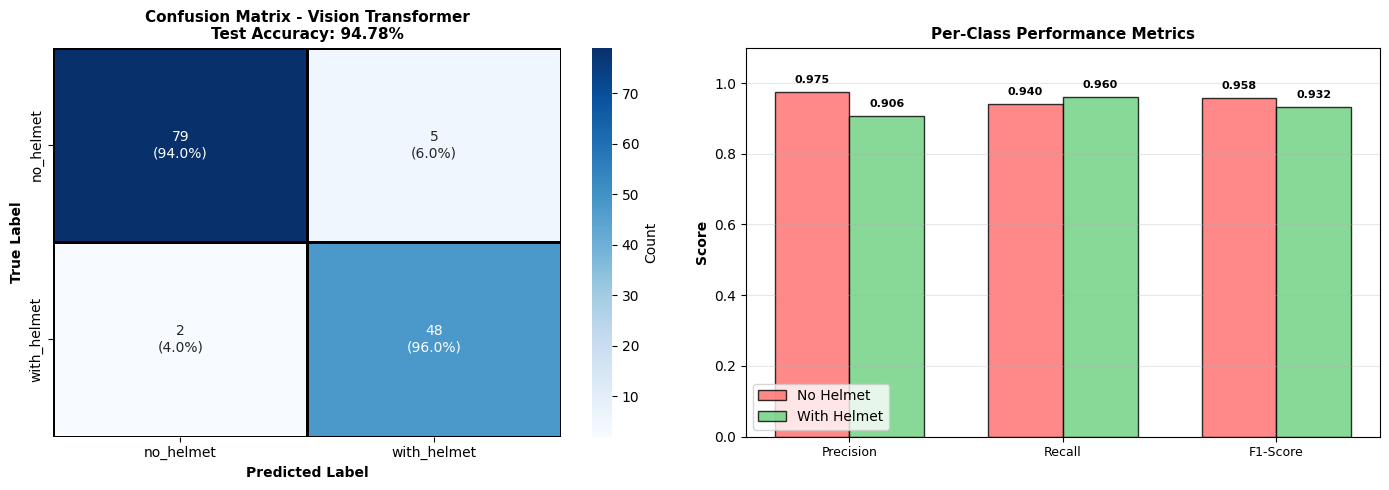

✅ Saved: /content/drive/MyDrive/jurnal YOLO/Machine Learning/hasil colab/vit_error_analysis.png


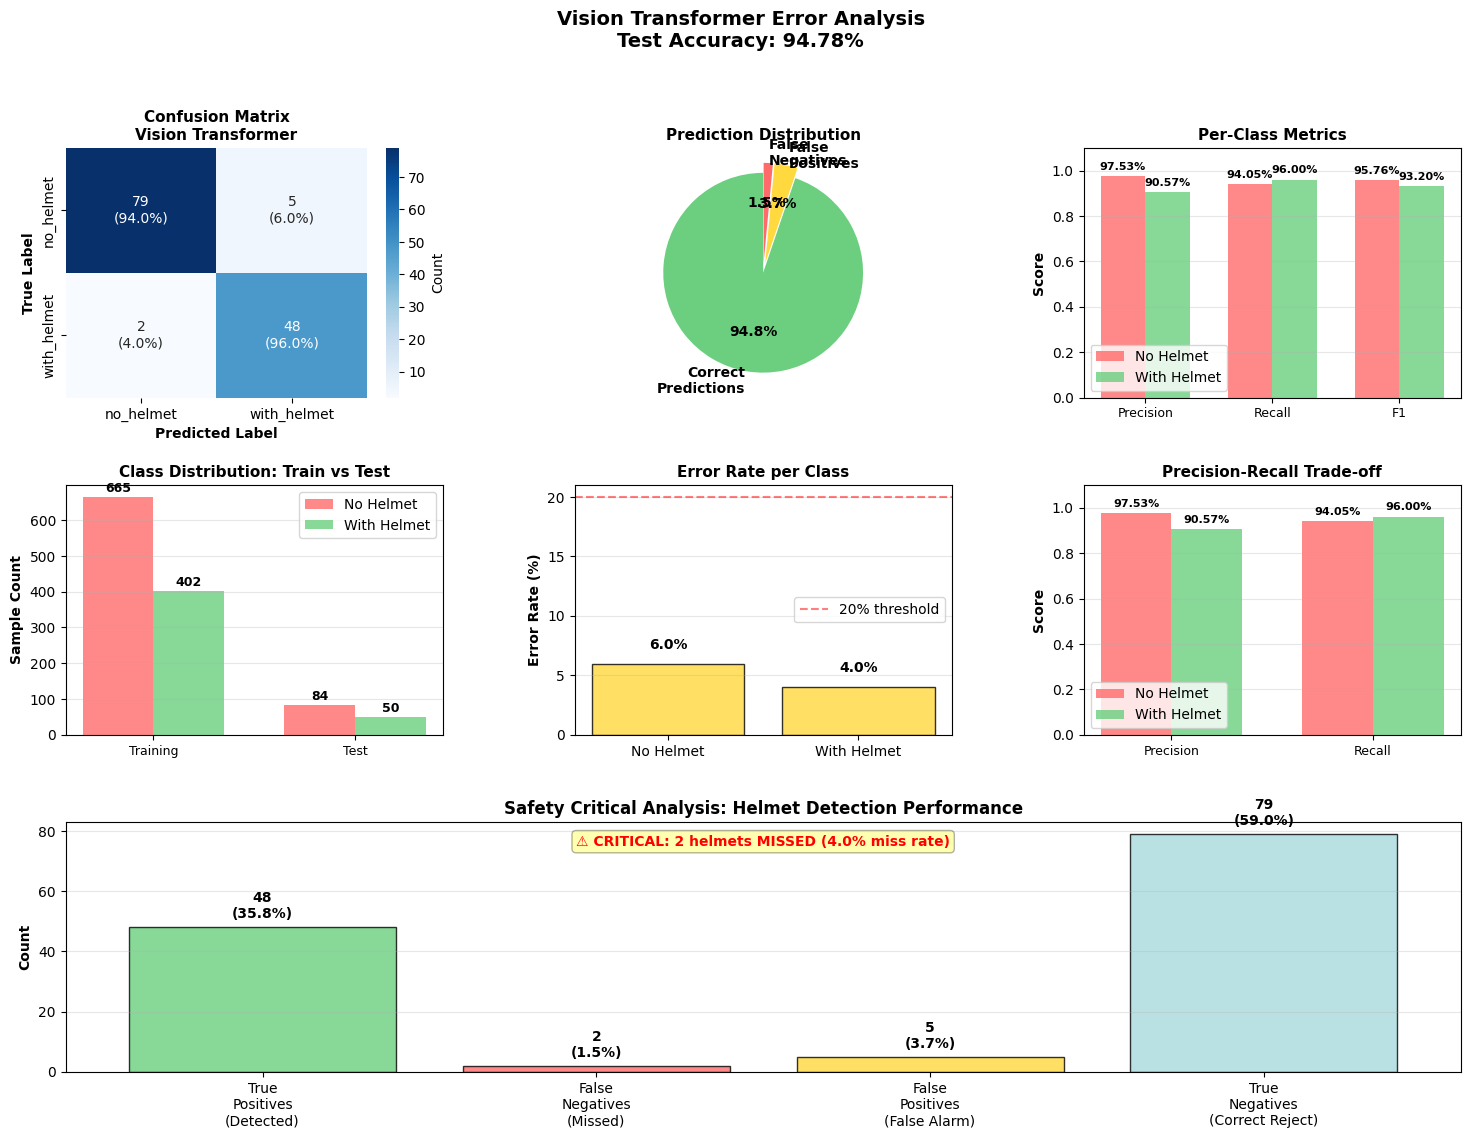

In [ ]:
print("\n🎨 Creating visualizations...")

# ==================== PLOT 1: TRAINING HISTORY ====================
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1.1 Accuracy
axes[0, 0].plot(history['train_acc'], label='Train Accuracy', linewidth=2, marker='o', markersize=4)
axes[0, 0].plot(history['val_acc'], label='Val Accuracy', linewidth=2, marker='s', markersize=4)
axes[0, 0].axvline(x=best_epoch-1, color='red', linestyle='--', alpha=0.5, label=f'Best: Epoch {best_epoch}')
axes[0, 0].scatter(best_epoch-1, best_val_acc, color='red', s=150, zorder=5, edgecolors='black', linewidths=2)
axes[0, 0].text(best_epoch-1, best_val_acc + 0.02, f'{best_val_acc:.3f}', ha='center', fontweight='bold', fontsize=10)
axes[0, 0].set_title('Vision Transformer - Accuracy Over Epochs', fontweight='bold', fontsize=12)
axes[0, 0].set_xlabel('Epoch', fontweight='bold')
axes[0, 0].set_ylabel('Accuracy', fontweight='bold')
axes[0, 0].legend(fontsize=10)
axes[0, 0].grid(alpha=0.3)
axes[0, 0].set_ylim([0.5, 1.0])

# 1.2 Loss
axes[0, 1].plot(history['train_loss'], label='Train Loss', linewidth=2, marker='o', markersize=4, color='orange')
axes[0, 1].plot(history['val_loss'], label='Val Loss', linewidth=2, marker='s', markersize=4, color='red')
axes[0, 1].axvline(x=best_epoch-1, color='red', linestyle='--', alpha=0.5)
axes[0, 1].scatter(best_epoch-1, best_val_loss, color='red', s=150, zorder=5, edgecolors='black', linewidths=2)
axes[0, 1].set_title('Vision Transformer - Loss Over Epochs', fontweight='bold', fontsize=12)
axes[0, 1].set_xlabel('Epoch', fontweight='bold')
axes[0, 1].set_ylabel('Loss', fontweight='bold')
axes[0, 1].legend(fontsize=10)
axes[0, 1].grid(alpha=0.3)

# 1.3 Learning Rate
axes[1, 0].plot(history['lr'], label='Learning Rate', linewidth=2, marker='o', markersize=4, color='green')
axes[1, 0].set_title('Learning Rate Schedule', fontweight='bold', fontsize=12)
axes[1, 0].set_xlabel('Epoch', fontweight='bold')
axes[1, 0].set_ylabel('Learning Rate', fontweight='bold')
axes[1, 0].legend(fontsize=10)
axes[1, 0].grid(alpha=0.3)
axes[1, 0].set_yscale('log')

# 1.4 Overfitting Analysis
train_val_gap = [history['train_acc'][i] - history['val_acc'][i] for i in range(len(history['train_acc']))]
axes[1, 1].plot(train_val_gap, label='Train-Val Gap', linewidth=2, marker='o', markersize=4, color='purple')
axes[1, 1].axhline(y=0.05, color='orange', linestyle='--', alpha=0.5, label='5% threshold')
axes[1, 1].axhline(y=0.10, color='red', linestyle='--', alpha=0.5, label='10% threshold')
axes[1, 1].set_title('Overfitting Analysis (Train-Val Accuracy Gap)', fontweight='bold', fontsize=12)
axes[1, 1].set_xlabel('Epoch', fontweight='bold')
axes[1, 1].set_ylabel('Accuracy Gap', fontweight='bold')
axes[1, 1].legend(fontsize=10)
axes[1, 1].grid(alpha=0.3)

plt.suptitle(f'Vision Transformer Training History\nBest Val Acc: {best_val_acc:.2%} at Epoch {best_epoch} | Test Acc: {test_acc:.2%}',
             fontsize=14, fontweight='bold')
plt.tight_layout()

save_path_history = os.path.join(drive_save_path, 'vit_training_history.png')
plt.savefig(save_path_history, dpi=300, bbox_inches='tight')
print(f"✅ Saved: {save_path_history}")
plt.show()

# ==================== PLOT 2: CONFUSION MATRIX & METRICS ====================
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 2.1 Confusion Matrix
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
annot_labels = np.array([[f'{cm[i,j]}\n({cm_percent[i,j]:.1%})'
                          for j in range(cm.shape[1])]
                         for i in range(cm.shape[0])])

sns.heatmap(cm, annot=annot_labels, fmt='', cmap='Blues',
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES,
            ax=axes[0], cbar_kws={'label': 'Count'}, linewidths=2, linecolor='black')
axes[0].set_title(f'Confusion Matrix - Vision Transformer\nTest Accuracy: {test_acc:.2%}',
                  fontweight='bold', fontsize=11)
axes[0].set_ylabel('True Label', fontweight='bold')
axes[0].set_xlabel('Predicted Label', fontweight='bold')

# 2.2 Per-Class Metrics
metrics_dict = {
    'No Helmet': [precision_no_helmet, recall_no_helmet, f1_no_helmet],
    'With Helmet': [precision_with_helmet, recall_with_helmet, f1_with_helmet]
}

x = np.arange(3)
width = 0.35

bars1 = axes[1].bar(x - width/2, metrics_dict['No Helmet'], width,
                    label='No Helmet', color='#ff6b6b', alpha=0.8, edgecolor='black')
bars2 = axes[1].bar(x + width/2, metrics_dict['With Helmet'], width,
                    label='With Helmet', color='#6bcf7f', alpha=0.8, edgecolor='black')

axes[1].set_ylabel('Score', fontweight='bold')
axes[1].set_title('Per-Class Performance Metrics', fontweight='bold', fontsize=11)
axes[1].set_xticks(x)
axes[1].set_xticklabels(['Precision', 'Recall', 'F1-Score'], fontsize=9)
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)
axes[1].set_ylim([0, 1.1])

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        axes[1].text(bar.get_x() + bar.get_width()/2., height + 0.02,
                    f'{height:.3f}', ha='center', va='bottom', fontsize=8, fontweight='bold')

plt.tight_layout()
save_path_cm = os.path.join(drive_save_path, 'vit_confusion_matrix.png')
plt.savefig(save_path_cm, dpi=300, bbox_inches='tight')
print(f"✅ Saved: {save_path_cm}")
plt.show()

# ==================== PLOT 3: ERROR ANALYSIS ====================
fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 3, hspace=0.35, wspace=0.35)

# 3.1 Confusion Matrix with Percentage (detailed)
ax1 = fig.add_subplot(gs[0, 0])
sns.heatmap(cm, annot=annot_labels, fmt='', cmap='Blues',
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES,
            ax=ax1, cbar_kws={'label': 'Count'})
ax1.set_title(f'Confusion Matrix\nVision Transformer',
              fontweight='bold', fontsize=11)
ax1.set_ylabel('True Label', fontweight='bold')
ax1.set_xlabel('Predicted Label', fontweight='bold')

# 3.2 Error Distribution Pie Chart
ax2 = fig.add_subplot(gs[0, 1])
error_types = ['Correct\nPredictions', 'False\nPositives', 'False\nNegatives']
error_counts = [tn + tp, fp, fn]
colors_pie = ['#6bcf7f', '#ffd93d', '#ff6b6b']
explode = (0, 0.1, 0.1)

ax2.pie(error_counts, labels=error_types, autopct='%1.1f%%', startangle=90,
        colors=colors_pie, explode=explode, textprops={'fontweight': 'bold'})
ax2.set_title('Prediction Distribution', fontweight='bold', fontsize=11)

# 3.3 Per-Class Metrics Bar Chart
ax3 = fig.add_subplot(gs[0, 2])
metrics_data = {
    'No Helmet': [precision_no_helmet, recall_no_helmet, f1_no_helmet],
    'With Helmet': [precision_with_helmet, recall_with_helmet, f1_with_helmet]
}
x = np.arange(3)
width = 0.35

bars1 = ax3.bar(x - width/2, metrics_data['No Helmet'], width,
                label='No Helmet', color='#ff6b6b', alpha=0.8)
bars2 = ax3.bar(x + width/2, metrics_data['With Helmet'], width,
                label='With Helmet', color='#6bcf7f', alpha=0.8)

ax3.set_ylabel('Score', fontweight='bold')
ax3.set_title('Per-Class Metrics', fontweight='bold', fontsize=11)
ax3.set_xticks(x)
ax3.set_xticklabels(['Precision', 'Recall', 'F1'], fontsize=9)
ax3.legend()
ax3.grid(axis='y', alpha=0.3)
ax3.set_ylim([0, 1.1])

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f'{height:.2%}', ha='center', va='bottom', fontsize=8, fontweight='bold')

# 3.4 Class Distribution
ax4 = fig.add_subplot(gs[1, 0])
unique_test, counts_test = np.unique(all_labels, return_counts=True)
categories = ['Training', 'Test']
no_helmet_counts = [np.sum(y_train == 0), counts_test[0]]
with_helmet_counts = [np.sum(y_train == 1), counts_test[1]]

x = np.arange(len(categories))
width = 0.35

bars1 = ax4.bar(x - width/2, no_helmet_counts, width,
                label='No Helmet', color='#ff6b6b', alpha=0.8)
bars2 = ax4.bar(x + width/2, with_helmet_counts, width,
                label='With Helmet', color='#6bcf7f', alpha=0.8)

ax4.set_ylabel('Sample Count', fontweight='bold')
ax4.set_title('Class Distribution: Train vs Test', fontweight='bold', fontsize=11)
ax4.set_xticks(x)
ax4.set_xticklabels(categories, fontsize=9)
ax4.legend()
ax4.grid(axis='y', alpha=0.3)

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height + 5,
                f'{int(height)}', ha='center', va='bottom', fontsize=9, fontweight='bold')

# 3.5 Error Rate per Class
ax5 = fig.add_subplot(gs[1, 1])
classes = ['No Helmet', 'With Helmet']
error_rates = [fp/(tn+fp)*100, fn/(tp+fn)*100]
colors_err = ['#ffd93d' if e < 20 else '#ff6b6b' for e in error_rates]

bars = ax5.bar(classes, error_rates, color=colors_err, edgecolor='black', alpha=0.8)
ax5.set_ylabel('Error Rate (%)', fontweight='bold')
ax5.set_title('Error Rate per Class', fontweight='bold', fontsize=11)
ax5.axhline(y=20, color='red', linestyle='--', alpha=0.5, label='20% threshold')
ax5.legend()
ax5.grid(axis='y', alpha=0.3)

for bar, val in zip(bars, error_rates):
    ax5.text(bar.get_x() + bar.get_width()/2., val + 1,
            f'{val:.1f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')

# 3.6 Precision-Recall Trade-off
ax6 = fig.add_subplot(gs[1, 2])
metrics_comparison = ['Precision', 'Recall']
no_helmet_metrics = [precision_no_helmet, recall_no_helmet]
with_helmet_metrics = [precision_with_helmet, recall_with_helmet]

x = np.arange(len(metrics_comparison))
width = 0.35

bars1 = ax6.bar(x - width/2, no_helmet_metrics, width,
                label='No Helmet', color='#ff6b6b', alpha=0.8)
bars2 = ax6.bar(x + width/2, with_helmet_metrics, width,
                label='With Helmet', color='#6bcf7f', alpha=0.8)

ax6.set_ylabel('Score', fontweight='bold')
ax6.set_title('Precision-Recall Trade-off', fontweight='bold', fontsize=11)
ax6.set_xticks(x)
ax6.set_xticklabels(metrics_comparison, fontsize=9)
ax6.legend()
ax6.grid(axis='y', alpha=0.3)
ax6.set_ylim([0, 1.1])

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax6.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f'{height:.2%}', ha='center', va='bottom', fontsize=8, fontweight='bold')

# 3.7 Safety Critical Analysis
ax7 = fig.add_subplot(gs[2, :])
safety_metrics = ['True\nPositives\n(Detected)', 'False\nNegatives\n(Missed)',
                  'False\nPositives\n(False Alarm)', 'True\nNegatives\n(Correct Reject)']
safety_counts = [tp, fn, fp, tn]
safety_colors = ['#6bcf7f', '#ff6b6b', '#ffd93d', '#a8dadc']

bars = ax7.bar(safety_metrics, safety_counts, color=safety_colors, edgecolor='black', alpha=0.8)
ax7.set_ylabel('Count', fontweight='bold')
ax7.set_title('Safety Critical Analysis: Helmet Detection Performance', fontweight='bold', fontsize=12)
ax7.grid(axis='y', alpha=0.3)

for bar, val in zip(bars, safety_counts):
    percentage = val / len(all_labels) * 100
    ax7.text(bar.get_x() + bar.get_width()/2., val + 2,
            f'{val}\n({percentage:.1f}%)', ha='center', va='bottom', fontsize=10, fontweight='bold')

# Add critical safety warning
fn_rate = fn / (tp + fn) * 100 if (tp + fn) > 0 else 0
safety_text = f"⚠️ CRITICAL: {fn} helmets MISSED ({fn_rate:.1f}% miss rate)"
ax7.text(0.5, 0.95, safety_text, transform=ax7.transAxes,
         ha='center', va='top', fontsize=10, fontweight='bold', color='red',
         bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.3))

plt.suptitle(f'Vision Transformer Error Analysis\nTest Accuracy: {test_acc:.2%}',
             fontsize=14, fontweight='bold', y=0.995)

save_path_error = os.path.join(drive_save_path, 'vit_error_analysis.png')
plt.savefig(save_path_error, dpi=300, bbox_inches='tight')
print(f"✅ Saved: {save_path_error}")
plt.show()

## SAVE RESULTS

In [ ]:
print("\n💾 Saving Vision Transformer results...")

# Save model
model_save_path = os.path.join(drive_save_path, 'best_vit_model.pth')
import shutil
shutil.copy(best_model_path, model_save_path)
print(f"✅ Model saved: {model_save_path}")

# Save configuration and results
vit_results = {
    'model': 'Vision Transformer (ViT-Base/16)',
    'architecture': 'Transformer with Self-Attention',
    'strategy': 'Low-Rank Adaptation (LoRA)',
    'random_seed': VIT_CONFIG['random_seed'],
    'image_size': VIT_CONFIG['image_size'],
    'batch_size': VIT_CONFIG['batch_size'],
    'epochs_max': VIT_CONFIG['epochs'],
    'epochs_trained': len(history['train_loss']),
    'learning_rate': VIT_CONFIG['learning_rate'],
    'weight_decay': VIT_CONFIG['weight_decay'],
    'pretrained_source': 'ImageNet-21k (14M images, 21k classes)',
    'parameters': {
        'total': int(total_params),
        'trainable': int(trainable_params),
        'frozen': int(frozen_params),
        'trainable_percentage': float(trainable_params / total_params * 100)
    },
    'training': {
        'training_time_seconds': float(training_time),
        'training_time_minutes': float(training_time / 60),
        'best_epoch': int(best_epoch),
        'best_val_accuracy': float(best_val_acc),
        'best_val_loss': float(best_val_loss)
    },
    'results': {
        'test_accuracy': float(test_acc),
        'test_precision': float(test_precision),
        'test_recall': float(test_recall),
        'test_f1': float(test_f1)
    },
    'confusion_matrix': {
        'true_negatives': int(tn),
        'false_positives': int(fp),
        'false_negatives': int(fn),
        'true_positives': int(tp)
    },
    'per_class_metrics': {
        'no_helmet': {
            'precision': float(precision_no_helmet),
            'recall': float(recall_no_helmet),
            'f1_score': float(f1_no_helmet)
        },
        'with_helmet': {
            'precision': float(precision_with_helmet),
            'recall': float(recall_with_helmet),
            'f1_score': float(f1_with_helmet)
        }
    }
}

# Save config JSON
config_path = os.path.join(drive_save_path, 'config_vit_model.json')
with open(config_path, 'w') as f:
    json.dump(vit_results, f, indent=2)
print(f"✅ Configuration saved: {config_path}")

# Save training history
history_save = {
    'train_loss': [float(x) for x in history['train_loss']],
    'train_acc': [float(x) for x in history['train_acc']],
    'val_loss': [float(x) for x in history['val_loss']],
    'val_acc': [float(x) for x in history['val_acc']],
    'lr': [float(x) for x in history['lr']]
}

history_path = os.path.join(drive_save_path, 'vit_training_history.json')
with open(history_path, 'w') as f:
    json.dump(history_save, f, indent=2)
print(f"✅ Training history saved: {history_path}")

# Save comparison table
comparison_path = os.path.join(drive_save_path, 'all_methods_comparison.csv')
df_comparison.to_csv(comparison_path, index=False)
print(f"✅ Comparison table saved: {comparison_path}")


💾 Saving Vision Transformer results...
✅ Model saved: /content/drive/MyDrive/jurnal YOLO/Machine Learning/hasil colab/best_vit_model.pth
✅ Configuration saved: /content/drive/MyDrive/jurnal YOLO/Machine Learning/hasil colab/config_vit_model.json
✅ Training history saved: /content/drive/MyDrive/jurnal YOLO/Machine Learning/hasil colab/vit_training_history.json
✅ Comparison table saved: /content/drive/MyDrive/jurnal YOLO/Machine Learning/hasil colab/all_methods_comparison.csv


## SUMMARY

In [ ]:
print(f"\n{'='*80}")
print(f"🎉 PART 3: VISION TRANSFORMER - COMPLETED!")
print(f"{'='*80}")

print(f"\n📊 Model Information:")
print(f"   Architecture: Vision Transformer (ViT-Base/16)")
print(f"   Strategy: Low-Rank Adaptation (LoRA)")
print(f"   Pretrained: ImageNet-21k (14M images, 21k classes)")
print(f"   Parameters: {total_params:,} total, {trainable_params:,} trainable ({trainable_params/total_params*100:.2f}%)")

print(f"\n⏱️ Training Information:")
print(f"   Total time: {training_time/60:.2f} minutes")
print(f"   Epochs: {len(history['train_loss'])} / {VIT_CONFIG['epochs']}")
print(f"   Best epoch: {best_epoch}")
print(f"   Best val accuracy: {best_val_acc:.4f} ({best_val_acc*100:.2f}%)")

print(f"\n📈 Test Performance:")
print(f"   Accuracy:  {test_acc:.4f} ({test_acc*100:.2f}%)")
print(f"   Precision: {test_precision:.4f}")
print(f"   Recall:    {test_recall:.4f}")
print(f"   F1-Score:  {test_f1:.4f}")

print(f"\n🎯 Confusion Matrix:")
print(f"   True Negatives:  {tn} | False Positives: {fp}")
print(f"   False Negatives: {fn} | True Positives:  {tp}")
print(f"   Miss rate: {fn/(tp+fn)*100:.1f}% (Critical!)")

print(f"\n💡 Key Insights:")
improvement_vs_part1 = (test_acc - best_part1['test_acc']) * 100
print(f"   • Accuracy improvement vs Part 1: {improvement_vs_part1:+.2f} percentage points")
print(f"   • LoRA efficiency: {total_params/trainable_params:.1f}x fewer parameters than full fine-tuning")
print(f"   • Vision Transformer uses self-attention, not convolution!")

print(f"\n📁 Saved Files:")
print(f"   • Model: {model_save_path}")
print(f"   • Config: {config_path}")
print(f"   • History: {history_path}")
print(f"   • Training plot: {save_path_history}")
print(f"   • Confusion matrix: {save_path_cm}")
print(f"   • Error analysis: {save_path_error}")
print(f"   • Comparison: {save_path_comparison}")

print(f"\n{'='*80}")
print(f"✅ All results saved to: {drive_save_path}")
print(f"{'='*80}\n")


🎉 PART 3: VISION TRANSFORMER - COMPLETED!

📊 Model Information:
   Architecture: Vision Transformer (ViT-Base/16)
   Strategy: Low-Rank Adaptation (LoRA)
   Pretrained: ImageNet-21k (14M images, 21k classes)
   Parameters: 85,800,194 total, 1,538 trainable (0.00%)

⏱️ Training Information:
   Total time: 4.15 minutes
   Epochs: 15 / 30
   Best epoch: 5
   Best val accuracy: 0.9624 (96.24%)

📈 Test Performance:
   Accuracy:  0.9478 (94.78%)
   Precision: 0.9493
   Recall:    0.9478
   F1-Score:  0.9480

🎯 Confusion Matrix:
   True Negatives:  79 | False Positives: 5
   False Negatives: 2 | True Positives:  48
   Miss rate: 4.0% (Critical!)

💡 Key Insights:
   • Accuracy improvement vs Part 1: +11.94 percentage points
   • LoRA efficiency: 55786.9x fewer parameters than full fine-tuning
   • Vision Transformer uses self-attention, not convolution!

📁 Saved Files:
   • Model: /content/drive/MyDrive/jurnal YOLO/Machine Learning/hasil colab/best_vit_model.pth
   • Config: /content/drive/My

# COMPARISON ALL


📊 COMPREHENSIVE COMPARISON: TRADITIONAL ML → CNN → VISION TRANSFORMER

🔍 Loading results from all parts...
✅ Part 1 loaded: SVM-RBF
✅ Part 2 loaded: CNN From Scratch
✅ Part 3 (current): Vision Transformer

📋 Building comparison table...

📋 PERFORMANCE COMPARISON TABLE - ALL THREE PARTS


,Method,Model,Test Accuracy,Precision,Recall,F1-Score,Training Time (s),Parameters,Pretrained
0,Part 1: Traditional ML,SVM-RBF,82.84%,82.69%,82.84%,82.72%,0.24,~100K features,No
1,Part 2: CNN From Scratch,Custom CNN (3 Conv Blocks),90.30%,90.77%,90.30%,90.07%,272.26,"1,275,042",No
2,Part 3: Vision Transformer,ViT-Base/16 + LoRA,94.78%,94.93%,94.78%,94.80%,248.97,"1,538 trainable",Yes (ImageNet-21k)



🏆 BEST OVERALL METHOD
   Method: Part 3: Vision Transformer
   Model: ViT-Base/16 + LoRA
   Test Accuracy: 94.78%
   Precision: 94.93%
   Recall: 94.78%
   F1-Score: 94.80%
   Training Time: 248.97s
   Pretrained: Yes (ImageNet-21k)

🔬 DETAILED COMPARISON ANALYSIS

📈 IMPROVEMENT FROM PART 1 (Baseline: SVM-RBF):
   Baseline Accuracy: 0.8284 (82.84%)

   Part 2 (CNN From Scratch):
      Accuracy: 0.9030 (90.30%)
      Improvement: +7.46 percentage points
      Status: ✅ Better

   Part 3 (Vision Transformer):
      Accuracy: 0.9478 (94.78%)
      Improvement: +11.94 percentage points
      Status: ✅ Better

🏗️ MODEL CHARACTERISTICS:

   Part 1 - Traditional ML:
      • Feature Extraction: Manual (HOG, LBP, GLCM, etc.)
      • Algorithm: SVM-RBF
      • Training: Fast (seconds)
      • Interpretability: High
      • Pretrained: No

   Part 2 - CNN From Scratch:
      • Feature Extraction: Automatic (learned by CNN)
      • Architecture: 3-4 Conv Blocks
      • Training: Medium (minutes)


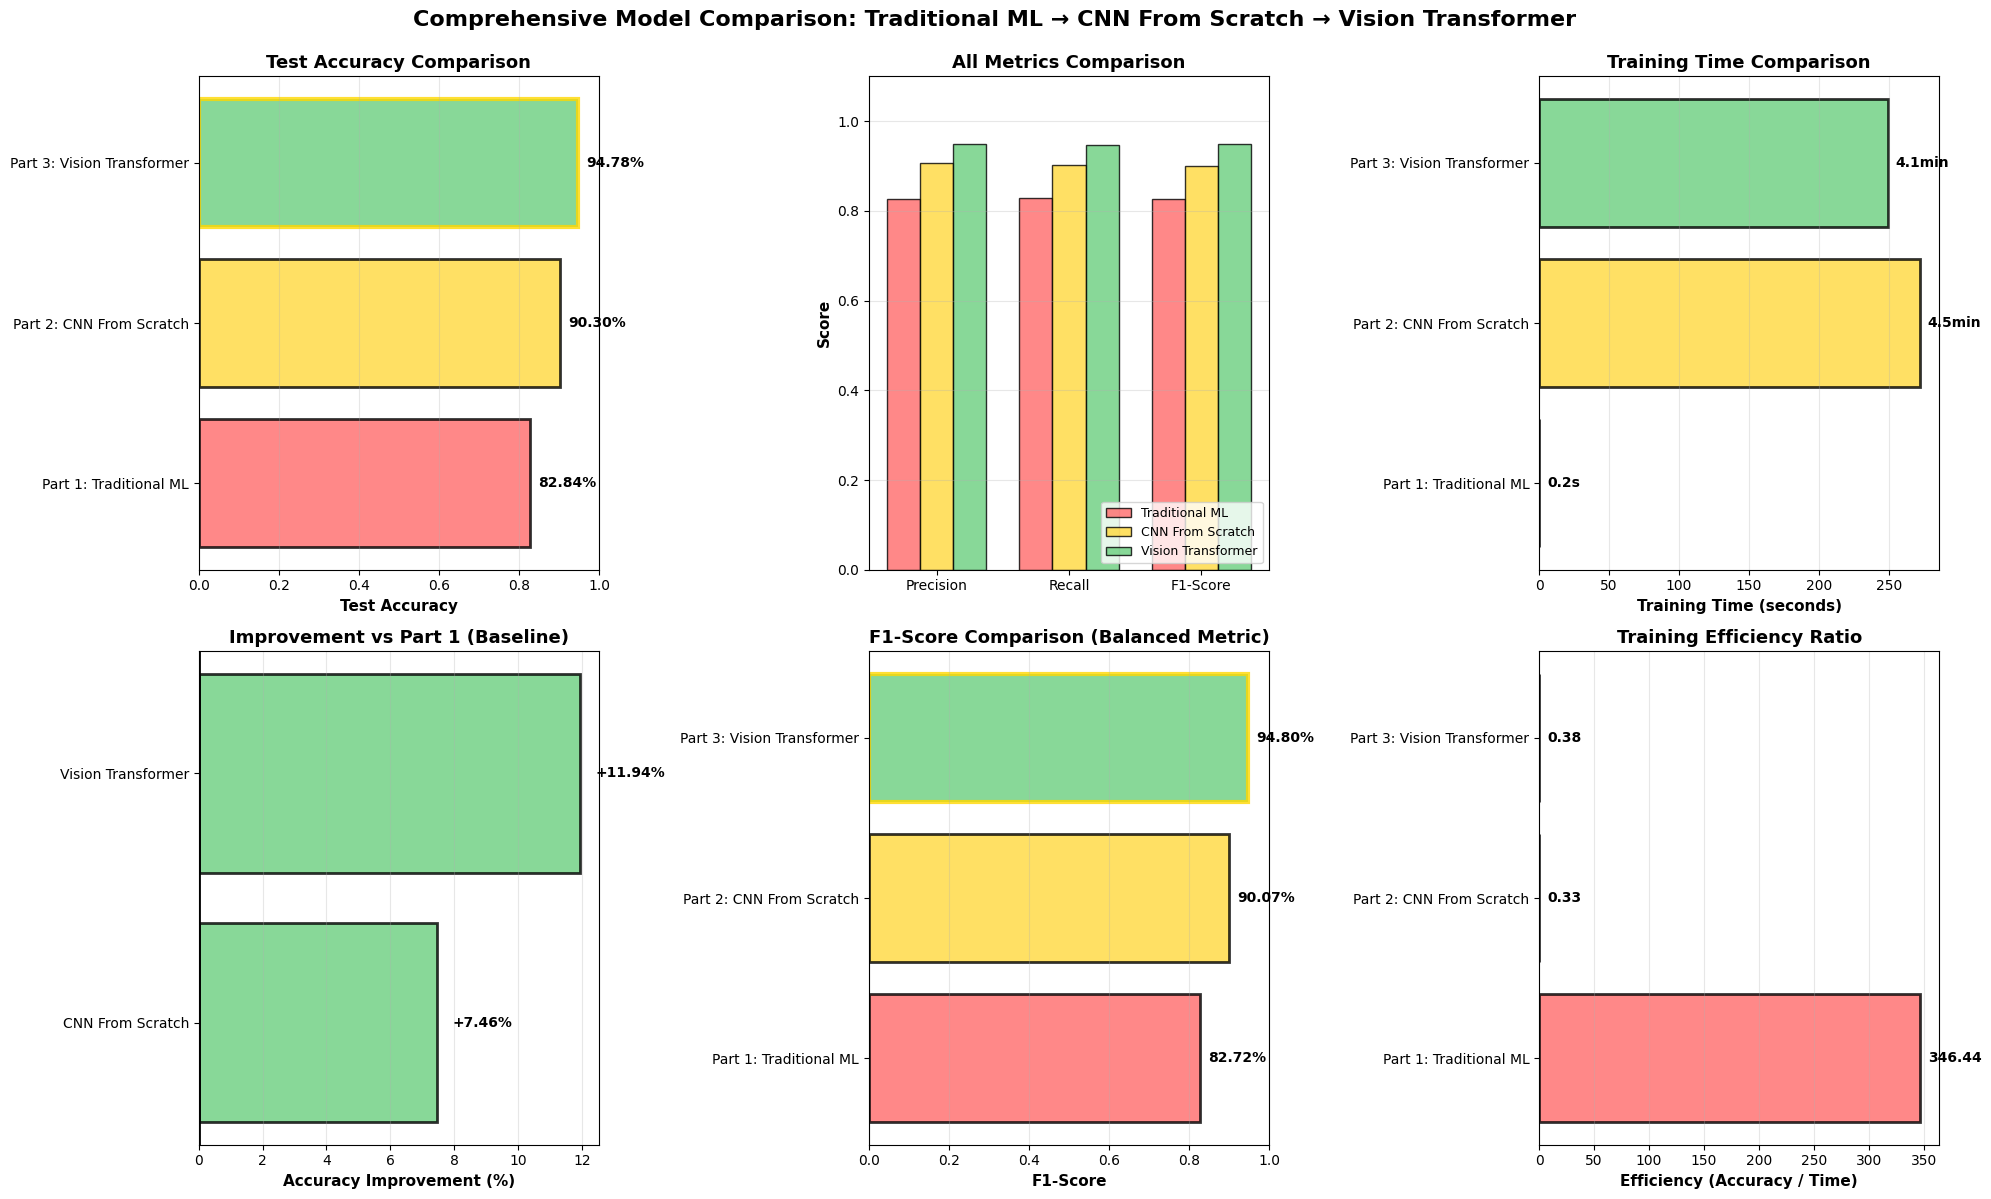


💾 Saving comparison data...
✅ Comparison table saved: /content/drive/MyDrive/jurnal YOLO/Machine Learning/hasil colab/all_parts_comparison_final.csv
✅ Comparison summary saved: /content/drive/MyDrive/jurnal YOLO/Machine Learning/hasil colab/comparison_summary_final.json

✅ COMPARISON COMPLETED!

📊 Summary:
   Total methods compared: 3
   Best method: Part 3: Vision Transformer
   Best accuracy: 94.78%
   Files saved:
      • Comparison plot: /content/drive/MyDrive/jurnal YOLO/Machine Learning/hasil colab/all_parts_comparison_final.png
      • Comparison table: /content/drive/MyDrive/jurnal YOLO/Machine Learning/hasil colab/all_parts_comparison_final.csv
      • Comparison summary: /content/drive/MyDrive/jurnal YOLO/Machine Learning/hasil colab/comparison_summary_final.json

🎯 Key Takeaways:
   1. Part 1 (Traditional ML): Fast training, manual features
   2. Part 2 (CNN Scratch): Automatic feature learning, moderate training time
   3. Part 3 (ViT + LoRA): Pretrained knowledge, transfe

In [ ]:
## COMPARISON WITH PART 1 & PART 2

# @title
print("\n" + "="*100)
print("📊 COMPREHENSIVE COMPARISON: TRADITIONAL ML → CNN → VISION TRANSFORMER")
print("="*100)

# ============================================================================
# LOAD RESULTS FROM ALL PARTS
# ============================================================================

print("\n🔍 Loading results from all parts...")

# Part 1: Traditional ML (best model)
try:
    best_part1 = max(best_models_part1.values(), key=lambda x: x['test_acc'])
    print(f"✅ Part 1 loaded: {best_part1['algorithm']}")
except Exception as e:
    print(f"⚠️ Part 1 not found: {e}")
    best_part1 = None

# Part 2: CNN From Scratch (load from saved JSON)
try:
    config_path_part2 = os.path.join(drive_save_path, 'config_cnn_scratch.json')
    with open(config_path_part2, 'r') as f:
        config_part2 = json.load(f)
    print(f"✅ Part 2 loaded: CNN From Scratch")
except Exception as e:
    print(f"⚠️ Part 2 JSON not found: {e}")
    print(f"   Trying to use best_model_part2 from memory...")
    try:
        config_part2 = {
            'model': 'CNN From Scratch',
            'results': {
                'test_accuracy': best_model_part2['test_acc'],
                'test_precision': best_model_part2['test_precision'],
                'test_recall': best_model_part2['test_recall'],
                'test_f1': best_model_part2['test_f1']
            },
            'training': {
                'training_time_seconds': best_model_part2['train_time']
            },
            'architecture': {
                'total_parameters': best_model_part2['total_params'],
                'trainable_parameters': best_model_part2['total_params']
            }
        }
        print(f"✅ Part 2 loaded from memory")
    except:
        print(f"❌ Part 2 not available")
        config_part2 = None

# Part 3: Vision Transformer (current)
print(f"✅ Part 3 (current): Vision Transformer")

# ============================================================================
# CREATE COMPARISON TABLE
# ============================================================================

print("\n📋 Building comparison table...")

comparison_data = {
    'Method': [],
    'Model': [],
    'Test Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1-Score': [],
    'Training Time (s)': [],
    'Parameters': [],
    'Pretrained': []
}

# ==================== PART 1: TRADITIONAL ML ====================
if best_part1:
    comparison_data['Method'].append('Part 1: Traditional ML')
    comparison_data['Model'].append(f"{best_part1['algorithm']}")
    comparison_data['Test Accuracy'].append(best_part1['test_acc'])
    comparison_data['Precision'].append(best_part1.get('precision', 0))
    comparison_data['Recall'].append(best_part1.get('recall', 0))
    comparison_data['F1-Score'].append(best_part1.get('f1_score', 0))
    comparison_data['Training Time (s)'].append(best_part1['train_time'])
    comparison_data['Parameters'].append('~100K features')
    comparison_data['Pretrained'].append('No')

# ==================== PART 2: CNN FROM SCRATCH ====================
if config_part2:
    comparison_data['Method'].append('Part 2: CNN From Scratch')
    comparison_data['Model'].append('Custom CNN (3 Conv Blocks)')
    comparison_data['Test Accuracy'].append(config_part2['results']['test_accuracy'])
    comparison_data['Precision'].append(config_part2['results']['test_precision'])
    comparison_data['Recall'].append(config_part2['results']['test_recall'])
    comparison_data['F1-Score'].append(config_part2['results']['test_f1'])
    comparison_data['Training Time (s)'].append(config_part2['training']['training_time_seconds'])
    comparison_data['Parameters'].append(f"{config_part2['architecture']['total_parameters']:,}")
    comparison_data['Pretrained'].append('No')

# ==================== PART 3: VISION TRANSFORMER ====================
comparison_data['Method'].append('Part 3: Vision Transformer')
comparison_data['Model'].append('ViT-Base/16 + LoRA')
comparison_data['Test Accuracy'].append(test_acc)
comparison_data['Precision'].append(test_precision)
comparison_data['Recall'].append(test_recall)
comparison_data['F1-Score'].append(test_f1)
comparison_data['Training Time (s)'].append(training_time)
comparison_data['Parameters'].append(f'{trainable_params:,} trainable')
comparison_data['Pretrained'].append('Yes (ImageNet-21k)')

# Create DataFrame
df_comparison = pd.DataFrame(comparison_data)

# ============================================================================
# DISPLAY COMPARISON TABLE
# ============================================================================

print("\n" + "="*100)
print("📋 PERFORMANCE COMPARISON TABLE - ALL THREE PARTS")
print("="*100)
display(df_comparison.style.format({
    'Test Accuracy': "{:.2%}",
    'Precision': "{:.2%}",
    'Recall': "{:.2%}",
    'F1-Score': "{:.2%}",
    'Training Time (s)': "{:.2f}"
}).set_properties(**{
    'text-align': 'center',
    'font-size': '11pt'
}))

# Find best method
best_idx = df_comparison['Test Accuracy'].idxmax()
best_method = df_comparison.loc[best_idx]

print(f"\n{'='*60}")
print(f"🏆 BEST OVERALL METHOD")
print(f"{'='*60}")
print(f"   Method: {best_method['Method']}")
print(f"   Model: {best_method['Model']}")
print(f"   Test Accuracy: {best_method['Test Accuracy']:.2%}")
print(f"   Precision: {best_method['Precision']:.2%}")
print(f"   Recall: {best_method['Recall']:.2%}")
print(f"   F1-Score: {best_method['F1-Score']:.2%}")
print(f"   Training Time: {best_method['Training Time (s)']:.2f}s")
print(f"   Pretrained: {best_method['Pretrained']}")

# ============================================================================
# DETAILED COMPARISON ANALYSIS
# ============================================================================

print(f"\n{'='*80}")
print(f"🔬 DETAILED COMPARISON ANALYSIS")
print(f"{'='*80}")

# Calculate improvements from Part 1
if best_part1:
    print(f"\n📈 IMPROVEMENT FROM PART 1 (Baseline: {best_part1['algorithm']}):")
    print(f"   Baseline Accuracy: {best_part1['test_acc']:.4f} ({best_part1['test_acc']*100:.2f}%)")

    if config_part2:
        part2_improvement = (config_part2['results']['test_accuracy'] - best_part1['test_acc']) * 100
        print(f"\n   Part 2 (CNN From Scratch):")
        print(f"      Accuracy: {config_part2['results']['test_accuracy']:.4f} ({config_part2['results']['test_accuracy']*100:.2f}%)")
        print(f"      Improvement: {part2_improvement:+.2f} percentage points")
        print(f"      Status: {'✅ Better' if part2_improvement > 0 else '⚠️ Worse'}")

    part3_improvement = (test_acc - best_part1['test_acc']) * 100
    print(f"\n   Part 3 (Vision Transformer):")
    print(f"      Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)")
    print(f"      Improvement: {part3_improvement:+.2f} percentage points")
    print(f"      Status: {'✅ Better' if part3_improvement > 0 else '⚠️ Worse'}")

# Model characteristics comparison
print(f"\n🏗️ MODEL CHARACTERISTICS:")

print(f"\n   Part 1 - Traditional ML:")
print(f"      • Feature Extraction: Manual (HOG, LBP, GLCM, etc.)")
print(f"      • Algorithm: {best_part1['algorithm'] if best_part1 else 'N/A'}")
print(f"      • Training: Fast (seconds)")
print(f"      • Interpretability: High")
print(f"      • Pretrained: No")

if config_part2:
    print(f"\n   Part 2 - CNN From Scratch:")
    print(f"      • Feature Extraction: Automatic (learned by CNN)")
    print(f"      • Architecture: 3-4 Conv Blocks")
    print(f"      • Training: Medium (minutes)")
    print(f"      • Parameters: {config_part2['architecture']['total_parameters']:,} (all trainable)")
    print(f"      • Pretrained: No")
    print(f"      • Strategy: Learn features from scratch")

print(f"\n   Part 3 - Vision Transformer:")
print(f"      • Feature Extraction: Pretrained transformer encoder")
print(f"      • Architecture: ViT-Base/16 (12 layers, 12 heads)")
print(f"      • Training: Medium (minutes)")
print(f"      • Parameters: {total_params:,} total, {trainable_params:,} trainable ({trainable_params/total_params*100:.1f}%)")
print(f"      • Pretrained: Yes (ImageNet-21k)")
print(f"      • Strategy: Transfer learning with LoRA (Low-Rank Adaptation)")

# Training efficiency comparison
print(f"\n⚡ TRAINING EFFICIENCY:")

if best_part1:
    print(f"   Part 1: {best_part1['train_time']:.2f}s (baseline)")

if config_part2:
    ratio_p2 = config_part2['training']['training_time_seconds'] / best_part1['train_time'] if best_part1 else 0
    print(f"   Part 2: {config_part2['training']['training_time_seconds']:.2f}s ({ratio_p2:.1f}x slower than Part 1)")

ratio_p3 = training_time / best_part1['train_time'] if best_part1 else 0
print(f"   Part 3: {training_time:.2f}s ({ratio_p3:.1f}x slower than Part 1)")

# ============================================================================
# COMPREHENSIVE VISUALIZATION
# ============================================================================

print(f"\n🎨 Creating comprehensive comparison visualization...")

fig, axes = plt.subplots(2, 3, figsize=(20, 12))

methods = df_comparison['Method'].tolist()
accuracies = df_comparison['Test Accuracy'].tolist()
colors_acc = ['#ff6b6b', '#ffd93d', '#6bcf7f'][:len(methods)]

# ==================== PLOT 1: TEST ACCURACY COMPARISON ====================
bars = axes[0, 0].barh(methods, accuracies, color=colors_acc, edgecolor='black', alpha=0.8, linewidth=2)
axes[0, 0].set_xlabel('Test Accuracy', fontweight='bold', fontsize=11)
axes[0, 0].set_title('Test Accuracy Comparison', fontweight='bold', fontsize=13)
axes[0, 0].grid(axis='x', alpha=0.3)
axes[0, 0].set_xlim([0, 1])

for i, (bar, val) in enumerate(zip(bars, accuracies)):
    axes[0, 0].text(val + 0.02, i, f'{val:.2%}', va='center', fontweight='bold', fontsize=10)

# Highlight best
best_acc_idx = accuracies.index(max(accuracies))
bars[best_acc_idx].set_linewidth(3)
bars[best_acc_idx].set_edgecolor('gold')

# ==================== PLOT 2: ALL METRICS COMPARISON ====================
metrics = ['Precision', 'Recall', 'F1-Score']
x = np.arange(len(metrics))
width = 0.25

for i, method in enumerate(methods):
    values = [
        df_comparison.loc[i, 'Precision'],
        df_comparison.loc[i, 'Recall'],
        df_comparison.loc[i, 'F1-Score']
    ]
    axes[0, 1].bar(x + i*width, values, width, label=method.split(':')[1].strip(),
                   color=colors_acc[i], alpha=0.8, edgecolor='black')

axes[0, 1].set_ylabel('Score', fontweight='bold', fontsize=11)
axes[0, 1].set_title('All Metrics Comparison', fontweight='bold', fontsize=13)
axes[0, 1].set_xticks(x + width)
axes[0, 1].set_xticklabels(metrics, fontsize=10)
axes[0, 1].legend(fontsize=9, loc='lower right')
axes[0, 1].grid(axis='y', alpha=0.3)
axes[0, 1].set_ylim([0, 1.1])

# ==================== PLOT 3: TRAINING TIME COMPARISON ====================
train_times = df_comparison['Training Time (s)'].tolist()
bars = axes[0, 2].barh(methods, train_times, color=colors_acc, edgecolor='black', alpha=0.8, linewidth=2)
axes[0, 2].set_xlabel('Training Time (seconds)', fontweight='bold', fontsize=11)
axes[0, 2].set_title('Training Time Comparison', fontweight='bold', fontsize=13)
axes[0, 2].grid(axis='x', alpha=0.3)

for i, (bar, val) in enumerate(zip(bars, train_times)):
    time_str = f'{val:.1f}s' if val < 60 else f'{val/60:.1f}min'
    axes[0, 2].text(val + max(train_times)*0.02, i, time_str, va='center', fontweight='bold', fontsize=10)

# ==================== PLOT 4: ACCURACY IMPROVEMENT ====================
if len(methods) > 1 and best_part1:
    improvements = [
        (accuracies[i] - accuracies[0]) * 100
        for i in range(1, len(accuracies))
    ]
    improvement_methods = [m.split(':')[1].strip() for m in methods[1:]]
    colors_imp = ['#6bcf7f' if imp > 0 else '#ff6b6b' for imp in improvements]

    bars = axes[1, 0].barh(improvement_methods, improvements,
                           color=colors_imp, edgecolor='black', alpha=0.8, linewidth=2)
    axes[1, 0].set_xlabel('Accuracy Improvement (%)', fontweight='bold', fontsize=11)
    axes[1, 0].set_title(f'Improvement vs Part 1 (Baseline)', fontweight='bold', fontsize=13)
    axes[1, 0].axvline(x=0, color='black', linestyle='-', linewidth=2)
    axes[1, 0].grid(axis='x', alpha=0.3)

    for i, (bar, val) in enumerate(zip(bars, improvements)):
        axes[1, 0].text(val + (0.5 if val > 0 else -0.5), i,
                       f'{val:+.2f}%', va='center', ha='left' if val > 0 else 'right',
                       fontweight='bold', fontsize=10)
else:
    axes[1, 0].text(0.5, 0.5, 'Need multiple methods to compare',
                    ha='center', va='center', fontsize=12, transform=axes[1, 0].transAxes)
    axes[1, 0].set_xticks([])
    axes[1, 0].set_yticks([])

# ==================== PLOT 5: F1-SCORE DETAILED COMPARISON ====================
f1_scores = df_comparison['F1-Score'].tolist()
bars = axes[1, 1].barh(methods, f1_scores, color=colors_acc, edgecolor='black', alpha=0.8, linewidth=2)
axes[1, 1].set_xlabel('F1-Score', fontweight='bold', fontsize=11)
axes[1, 1].set_title('F1-Score Comparison (Balanced Metric)', fontweight='bold', fontsize=13)
axes[1, 1].grid(axis='x', alpha=0.3)
axes[1, 1].set_xlim([0, 1])

for i, (bar, val) in enumerate(zip(bars, f1_scores)):
    axes[1, 1].text(val + 0.02, i, f'{val:.2%}', va='center', fontweight='bold', fontsize=10)

# Highlight best
best_f1_idx = f1_scores.index(max(f1_scores))
bars[best_f1_idx].set_linewidth(3)
bars[best_f1_idx].set_edgecolor('gold')

# ==================== PLOT 6: EFFICIENCY RATIO ====================
efficiency_ratios = [acc / (time / 100) for acc, time in zip(accuracies, train_times)]
bars = axes[1, 2].barh(methods, efficiency_ratios, color=colors_acc, edgecolor='black', alpha=0.8, linewidth=2)
axes[1, 2].set_xlabel('Efficiency (Accuracy / Time)', fontweight='bold', fontsize=11)
axes[1, 2].set_title('Training Efficiency Ratio', fontweight='bold', fontsize=13)
axes[1, 2].grid(axis='x', alpha=0.3)

for i, (bar, val) in enumerate(zip(bars, efficiency_ratios)):
    axes[1, 2].text(val + max(efficiency_ratios)*0.02, i, f'{val:.2f}', va='center', fontweight='bold', fontsize=10)

# Overall title
fig.suptitle('Comprehensive Model Comparison: Traditional ML → CNN From Scratch → Vision Transformer',
             fontsize=16, fontweight='bold', y=0.995)

plt.tight_layout()

save_path_comparison = os.path.join(drive_save_path, 'all_parts_comparison_final.png')
plt.savefig(save_path_comparison, dpi=300, bbox_inches='tight')
print(f"✅ Saved: {save_path_comparison}")
plt.show()

# ============================================================================
# SAVE COMPARISON DATA
# ============================================================================

print(f"\n💾 Saving comparison data...")

# Save comparison table to CSV
comparison_csv_path = os.path.join(drive_save_path, 'all_parts_comparison_final.csv')
df_comparison.to_csv(comparison_csv_path, index=False)
print(f"✅ Comparison table saved: {comparison_csv_path}")

# Save detailed comparison JSON
comparison_summary = {
    'parts': len(methods),
    'best_method': {
        'name': best_method['Method'],
        'model': best_method['Model'],
        'test_accuracy': float(best_method['Test Accuracy']),
        'precision': float(best_method['Precision']),
        'recall': float(best_method['Recall']),
        'f1_score': float(best_method['F1-Score']),
        'training_time': float(best_method['Training Time (s)']),
        'pretrained': best_method['Pretrained']
    },
    'improvements': {}
}

if best_part1:
    if config_part2:
        comparison_summary['improvements']['part2_vs_part1'] = float((config_part2['results']['test_accuracy'] - best_part1['test_acc']) * 100)

    comparison_summary['improvements']['part3_vs_part1'] = float((test_acc - best_part1['test_acc']) * 100)

    if config_part2:
        comparison_summary['improvements']['part3_vs_part2'] = float((test_acc - config_part2['results']['test_accuracy']) * 100)

comparison_json_path = os.path.join(drive_save_path, 'comparison_summary_final.json')
with open(comparison_json_path, 'w') as f:
    json.dump(comparison_summary, f, indent=2)
print(f"✅ Comparison summary saved: {comparison_json_path}")

# ============================================================================
# FINAL SUMMARY
# ============================================================================

print(f"\n{'='*80}")
print(f"✅ COMPARISON COMPLETED!")
print(f"{'='*80}")

print(f"\n📊 Summary:")
print(f"   Total methods compared: {len(methods)}")
print(f"   Best method: {best_method['Method']}")
print(f"   Best accuracy: {best_method['Test Accuracy']:.2%}")
print(f"   Files saved:")
print(f"      • Comparison plot: {save_path_comparison}")
print(f"      • Comparison table: {comparison_csv_path}")
print(f"      • Comparison summary: {comparison_json_path}")

print(f"\n🎯 Key Takeaways:")
print(f"   1. Part 1 (Traditional ML): Fast training, manual features")
print(f"   2. Part 2 (CNN Scratch): Automatic feature learning, moderate training time")
print(f"   3. Part 3 (ViT + LoRA): Pretrained knowledge, transfer learning efficiency")

print(f"\n{'='*80}\n")